# FDA Food Adverse Events - Data Exploration

This notebook explores the FDA openFDA food adverse event reports dataset to understand:
- Dataset structure and quality
- Temporal patterns in adverse event reports
- Most common reactions and outcomes
- Consumer demographics
- Product categories involved

**Goal**: Identify patterns that will inform our anomaly detection approach for outbreak identification.

In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [25]:
# Import our custom data loader
import sys
sys.path.append('../src')
from data_loader import FDADataLoader

## 1. Load the Data

We'll start by loading a subset of the data to explore its structure. The full dataset contains 2.6M+ records, so we'll initially work with a manageable sample.

In [26]:
# Initialize data loader
data_path = '../data/raw/food-event-0001-of-0001.json'
loader = FDADataLoader(data_path)

# Load sample of data (adjust max_records as needed)
print("Loading data sample...")
df = loader.load_to_dataframe(max_records=50000)
print(f"Loaded {len(df):,} records")

INFO:data_loader:Loading FDA data to DataFrame...


Loading data sample...


INFO:data_loader:Processed 10000 records...
INFO:data_loader:Processed 20000 records...
INFO:data_loader:Processed 30000 records...
INFO:data_loader:Processed 40000 records...
INFO:data_loader:Processed 50000 records...
INFO:data_loader:Loaded 50000 records into DataFrame


Loaded 50,000 records


In [27]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names and types:")
df.info()

Dataset shape: (50000, 13)

Column names and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   report_number      50000 non-null  object
 1   date_created       50000 non-null  object
 2   date_started       31018 non-null  object
 3   outcomes           50000 non-null  object
 4   reactions          50000 non-null  object
 5   reaction_count     50000 non-null  int64 
 6   consumer_age       29057 non-null  object
 7   consumer_age_unit  29057 non-null  object
 8   consumer_gender    45469 non-null  object
 9   product_name       50000 non-null  object
 10  product_role       50000 non-null  object
 11  industry_code      50000 non-null  object
 12  industry_name      50000 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.0+ MB


In [28]:
# View first few records
df.head(10)

,report_number,date_created,date_started,outcomes,reactions,reaction_count,consumer_age,consumer_age_unit,consumer_gender,product_name,product_role,industry_code,industry_name
0,102518,20080404,20080327,Visited a Health Care Provider,"ABDOMINAL PAIN,DIARRHOEA,NAUSEA,VOMITING",4,None,None,None,"OMEGA BERRY FISH OIL TABLETS, SOFT GEL CAPSULE...",SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
1,103085,20080507,20080320,Hospitalization,"BLISTER,ECCHYMOSIS,EPISTAXIS,GASTROINTESTINAL ...",7,69.00,year(s),Female,NUTRITIONAL SCIENCE LABS HYPERZOSIN,SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
2,107997,20081121,None,"Other Serious or Important Medical Event,Other...","CHOKING,REMOVAL OF FOREIGN BODY FROM THROAT",2,84.00,year(s),Female,OS CAL (CALCIUM CARBONATE PLUS VITAMIN D),SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
3,104921,20080710,None,Visited a Health Care Provider,"BREATH ODOUR,HYPERSENSITIVITY",2,None,None,Female,STOFFER'S FRENCH BREAD PIZZA - GRILLED VEGETABLES,SUSPECT,37,Mult Food Dinner/Grav/Sauce/Special
4,110847,20090303,None,Other Outcome,"BURNING SENSATION,HYPOAESTHESIA",2,None,None,Female,MAGNETIC SPRINGS DISTILLED WATER,SUSPECT,29,Soft Drink/Water
5,108592,20081217,20081203,"Other Serious or Important Medical Event,Other...","ABDOMINAL DISTENSION,FAECES DISCOLOURED,HAEMAT...",3,73.00,year(s),Female,PHILLIPS' COLON HEALTH (LACTOBACILLUS COMPOUND),SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
6,107203,20081016,20081011,"Hospitalization,Other Serious or Important Med...",ABORTION SPONTANEOUS,1,28.00,year(s),Female,NATAFORT PRENATAL VITAMINS,SUSPECT,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
7,109576,20090127,20090111,Other Outcome,"DIARRHOEA,MALAISE,VOMITING",3,None,None,Male,AUSTIN PEANUT BUTTER CRACKERS (CHEESE AND TOASTY),SUSPECT,03,Bakery Prod/Dough/Mix/Icing
8,118649,20081209,20081203,Other Outcome,"DIZZINESS,NAUSEA,PARAESTHESIA",3,None,None,Male,PEPSI COLA DR PEPPER,SUSPECT,29,Soft Drink/Water
9,111858,20090121,20090120,Other Outcome,"ABDOMINAL PAIN,DIARRHOEA,MALAISE,VOMITING",4,None,None,Male,PILLSBURY BIG DELUXE PEANUT BUTTER CUP COOKIES,SUSPECT,03,Bakery Prod/Dough/Mix/Icing


## 2. Data Quality Assessment

In [29]:
# Check for missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Data Summary:")
print(missing_data[missing_data['Missing_Count'] > 0])

Missing Data Summary:
                              Column  Missing_Count  Missing_Percentage
consumer_age            consumer_age          20943               41.89
consumer_age_unit  consumer_age_unit          20943               41.89
date_started            date_started          18982               37.96
consumer_gender      consumer_gender           4531                9.06


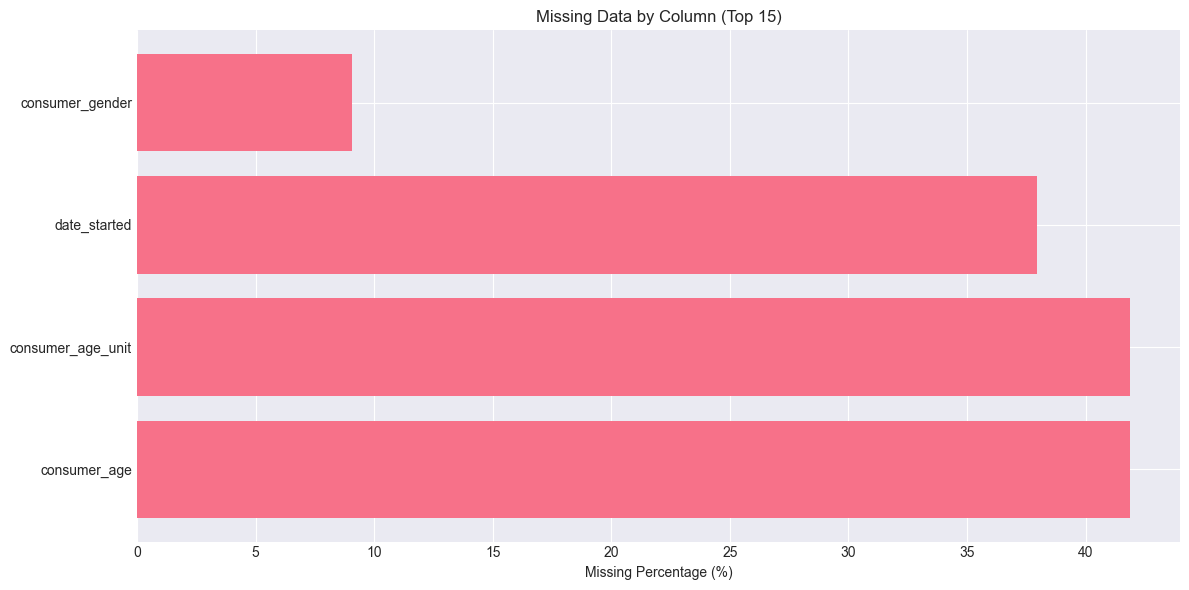

In [30]:
# Visualize missing data
plt.figure(figsize=(12, 6))
missing_cols = missing_data[missing_data['Missing_Percentage'] > 0].head(15)
plt.barh(missing_cols['Column'], missing_cols['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column (Top 15)')
plt.tight_layout()
plt.show()

In [31]:
# Check for duplicate report numbers
duplicates = df['report_number'].duplicated().sum()
print(f"Duplicate report numbers: {duplicates:,}")
print(f"Unique reports: {df['report_number'].nunique():,}")

Duplicate report numbers: 0
Unique reports: 50,000


## 3. Temporal Analysis

Understanding the time distribution of reports is crucial for outbreak detection.

In [32]:
# Convert date_started to datetime
df['date_started'] = pd.to_datetime(df['date_started'], errors='coerce')

# Extract temporal features
df['year'] = df['date_started'].dt.year
df['month'] = df['date_started'].dt.month
df['day_of_week'] = df['date_started'].dt.dayofweek
df['quarter'] = df['date_started'].dt.quarter

print("Date range:")
print(f"Earliest: {df['date_started'].min()}")
print(f"Latest: {df['date_started'].max()}")
print(f"Missing dates: {df['date_started'].isna().sum():,}")

Date range:
Earliest: 1925-01-23 00:00:00
Latest: 2025-03-29 00:00:00
Missing dates: 18,982


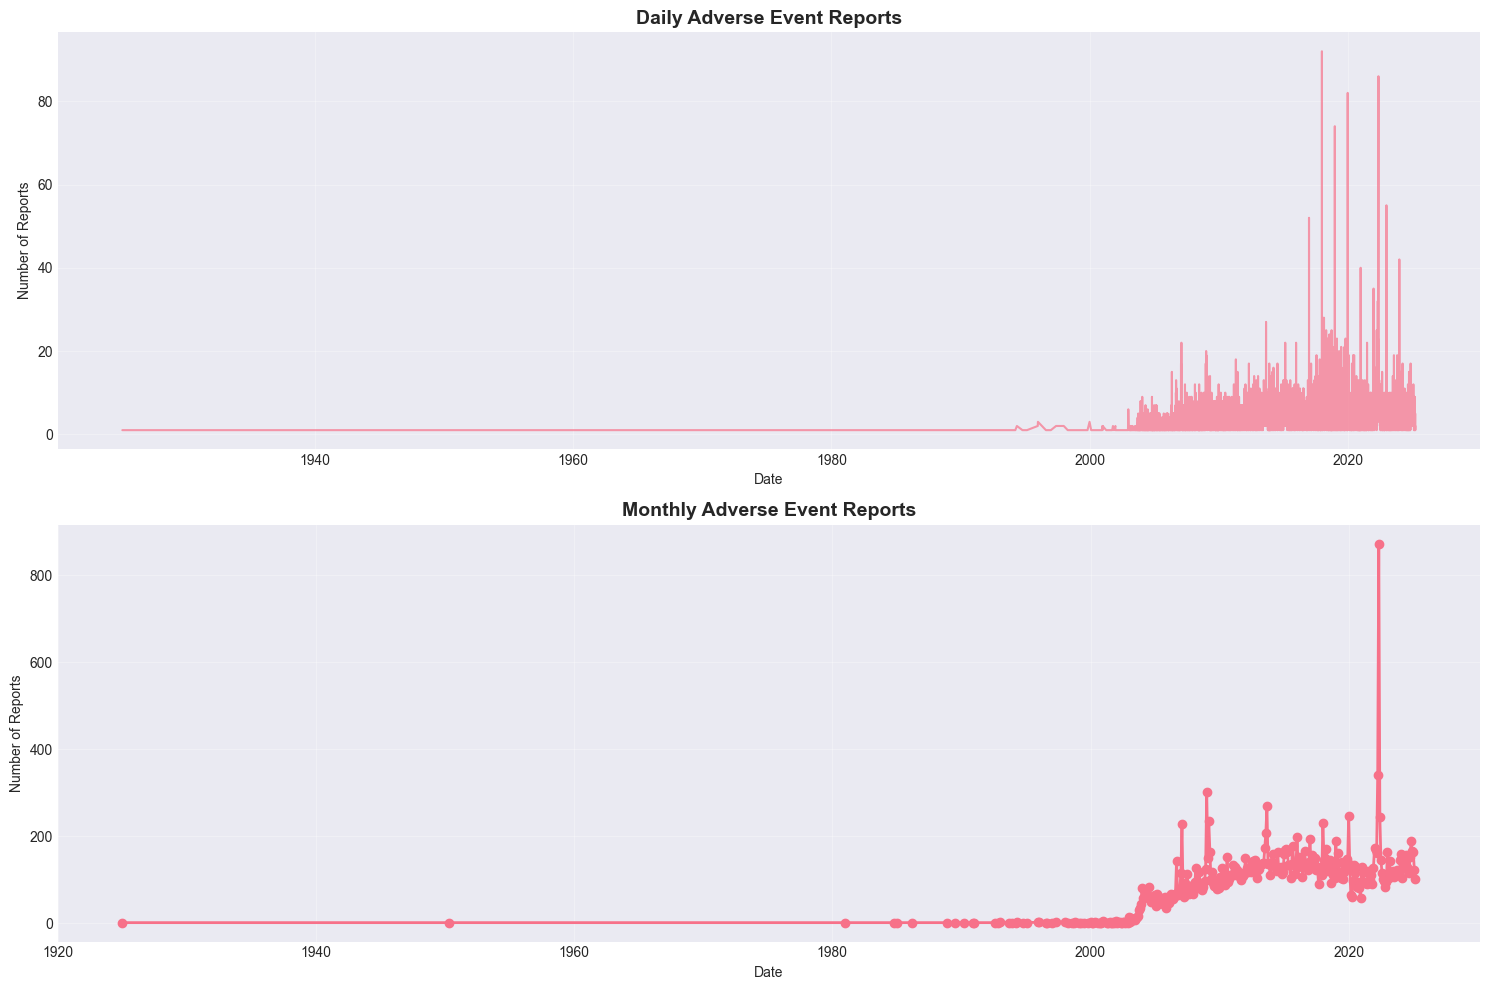

In [33]:
# Plot reports over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily counts
daily_counts = df.groupby(df['date_started'].dt.date).size()
axes[0].plot(daily_counts.index, daily_counts.values, alpha=0.7)
axes[0].set_title('Daily Adverse Event Reports', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Reports')
axes[0].grid(True, alpha=0.3)

# Monthly counts
monthly_counts = df.groupby(df['date_started'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()
axes[1].plot(monthly_counts.index, monthly_counts.values, marker='o', linewidth=2)
axes[1].set_title('Monthly Adverse Event Reports', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Reports')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

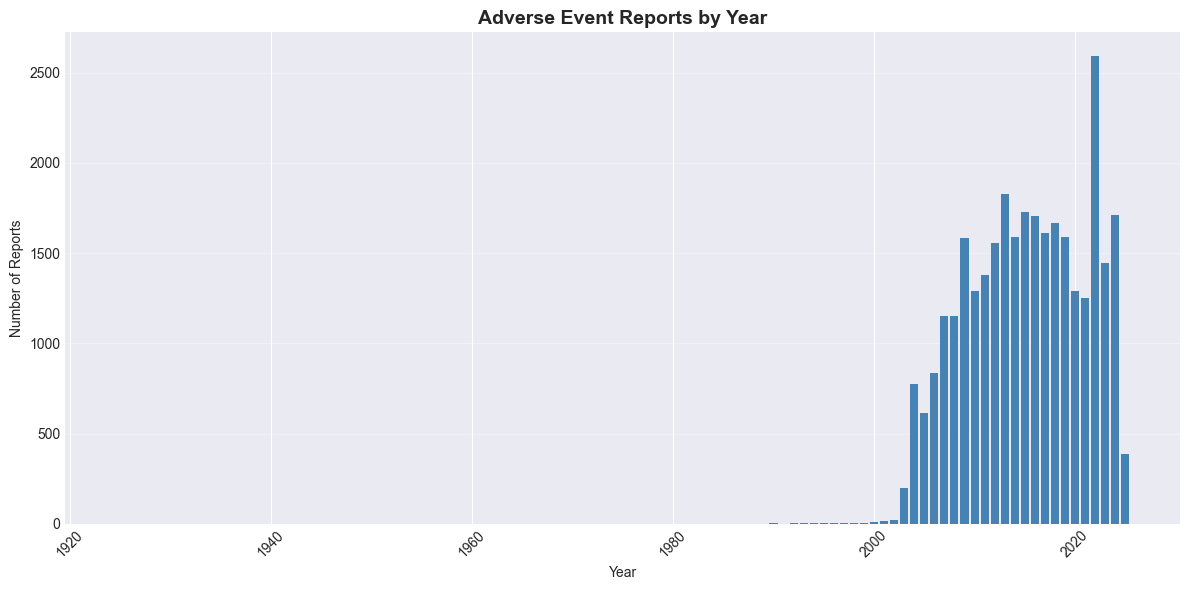


Yearly Report Counts:
year
1925.0       1
1950.0       1
1981.0       1
1984.0       1
1985.0       1
1986.0       1
1988.0       1
1989.0       1
1990.0       2
1991.0       1
1992.0       2
1993.0       4
1994.0       4
1995.0       3
1996.0       5
1997.0       3
1998.0       7
1999.0       4
2000.0      12
2001.0      16
2002.0      19
2003.0     198
2004.0     774
2005.0     616
2006.0     838
2007.0    1149
2008.0    1153
2009.0    1583
2010.0    1291
2011.0    1380
2012.0    1556
2013.0    1826
2014.0    1591
2015.0    1728
2016.0    1704
2017.0    1610
2018.0    1667
2019.0    1587
2020.0    1288
2021.0    1254
2022.0    2594
2023.0    1445
2024.0    1709
2025.0     387
Name: count, dtype: int64


In [34]:
# Yearly trend
yearly_counts = df['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='steelblue')
plt.title('Adverse Event Reports by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nYearly Report Counts:")
print(yearly_counts)

## 4. Reaction Analysis

Identifying the most common reactions will help us focus our anomaly detection efforts.

In [35]:
# Count reactions (handling lists)
from collections import Counter

all_reactions = []
for reactions in df['reactions'].dropna():
    if isinstance(reactions, list):
        all_reactions.extend(reactions)
    elif isinstance(reactions, str):
        all_reactions.append(reactions)

reaction_counts = Counter(all_reactions)
top_reactions = pd.DataFrame(reaction_counts.most_common(30), 
                             columns=['Reaction', 'Count'])

print(f"Total unique reactions: {len(reaction_counts):,}")
print(f"Total reaction occurrences: {len(all_reactions):,}")
print("\nTop 30 Most Common Reactions:")
print(top_reactions)

Total unique reactions: 27,230
Total reaction occurrences: 50,000

Top 30 Most Common Reactions:
                             Reaction  Count
0                             CHOKING    811
1                             Choking    586
2                           DIARRHOEA    579
3                            VOMITING    515
4                           Diarrhoea    429
5                              NAUSEA    424
6                  DIARRHOEA,VOMITING    365
7                   CHOKING,DYSPHAGIA    318
8                           DYSGEUSIA    317
9                             MALAISE    308
10           ABDOMINAL PAIN,DIARRHOEA    300
11                           Vomiting    289
12                            Malaise    264
13                 Diarrhoea,Vomiting    211
14                   Hypersensitivity    210
15                       Foreign body    182
16                    NAUSEA,VOMITING    171
17                     ABDOMINAL PAIN    164
18          DIARRHOEA,NAUSEA,VOMITING    157
19 

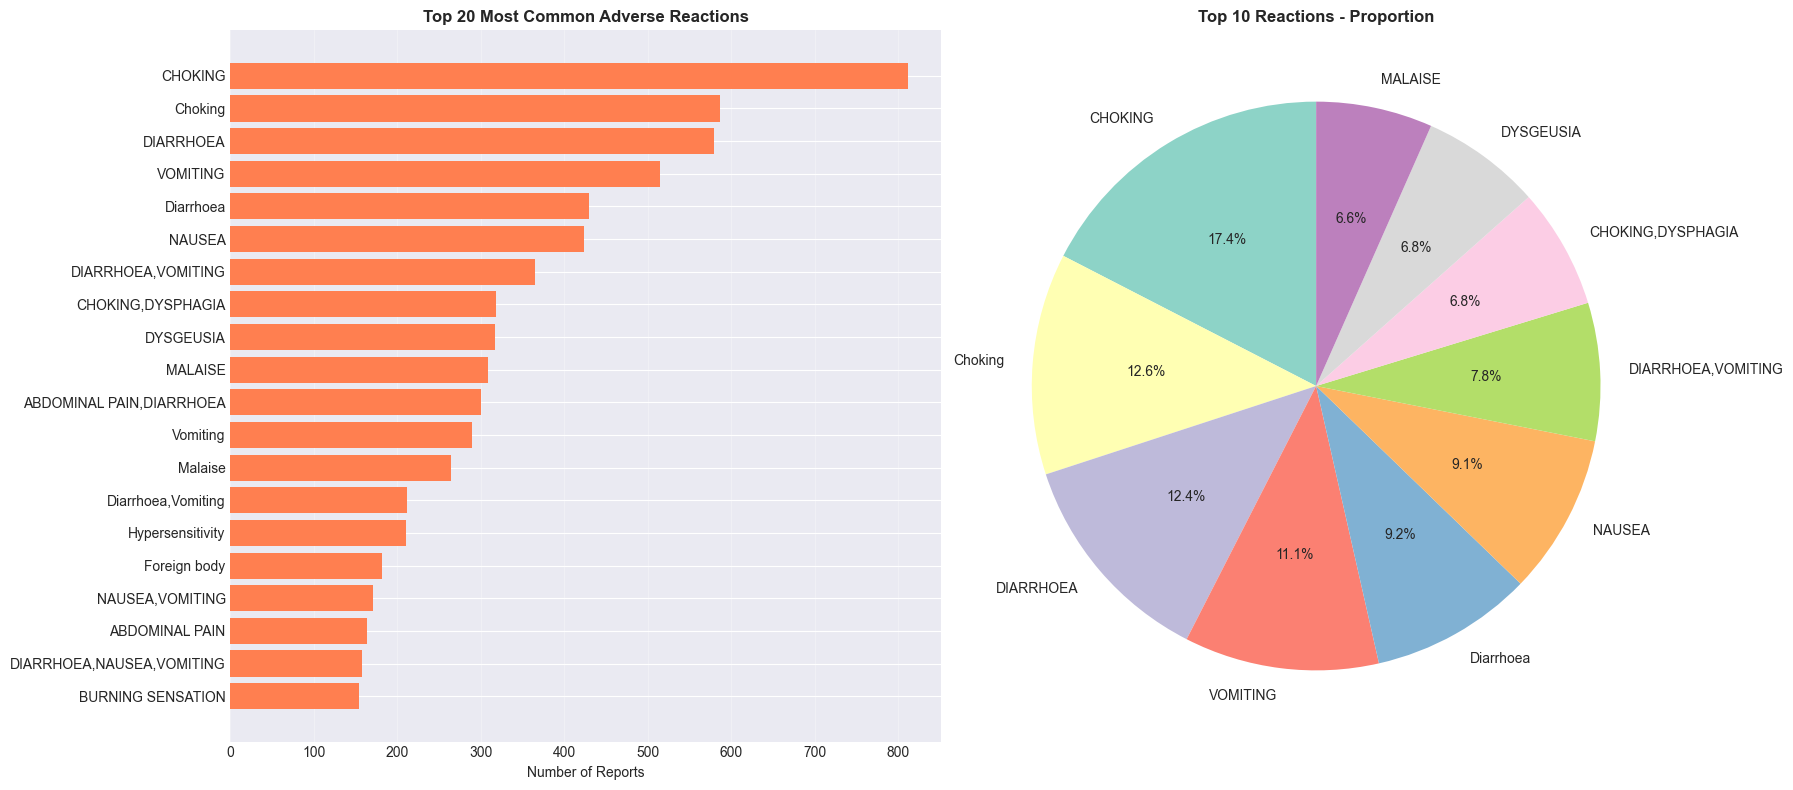

In [36]:
# Visualize top reactions
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 reactions
top_20 = top_reactions.head(20)
axes[0].barh(range(len(top_20)), top_20['Count'], color='coral')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['Reaction'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Number of Reports')
axes[0].set_title('Top 20 Most Common Adverse Reactions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 with percentages
top_10 = top_reactions.head(10).copy()
top_10['Percentage'] = (top_10['Count'] / len(all_reactions) * 100).round(2)
colors = plt.cm.Set3(range(len(top_10)))
axes[1].pie(top_10['Count'], labels=top_10['Reaction'], autopct='%1.1f%%',
           startangle=90, colors=colors)
axes[1].set_title('Top 10 Reactions - Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Outcome Analysis

In [37]:
# Analyze outcomes
all_outcomes = []
for outcomes in df['outcomes'].dropna():
    if isinstance(outcomes, list):
        all_outcomes.extend(outcomes)
    elif isinstance(outcomes, str):
        all_outcomes.append(outcomes)

outcome_counts = Counter(all_outcomes)
outcome_df = pd.DataFrame(outcome_counts.most_common(), 
                         columns=['Outcome', 'Count'])
outcome_df['Percentage'] = (outcome_df['Count'] / len(all_outcomes) * 100).round(2)

print("Outcome Distribution:")
print(outcome_df)

Outcome Distribution:
                                               Outcome  Count  Percentage
0             Other Serious or Important Medical Event  14581       29.16
1                                        Other Outcome  11521       23.04
2                                      Hospitalization   2643        5.29
3                       Visited a Health Care Provider   1988        3.98
4    Other Serious or Important Medical Event,Visit...   1890        3.78
..                                                 ...    ...         ...
313  Congenital Anomaly,Visited Emergency Room,Visi...      1        0.00
314  Life Threatening,Hospitalization,Disability,Co...      1        0.00
315  Hospitalization,Disability,Visited Emergency R...      1        0.00
316  Death,Other Serious or Important Medical Event...      1        0.00
317  Other Serious or Important Medical Event,Visit...      1        0.00

[318 rows x 3 columns]


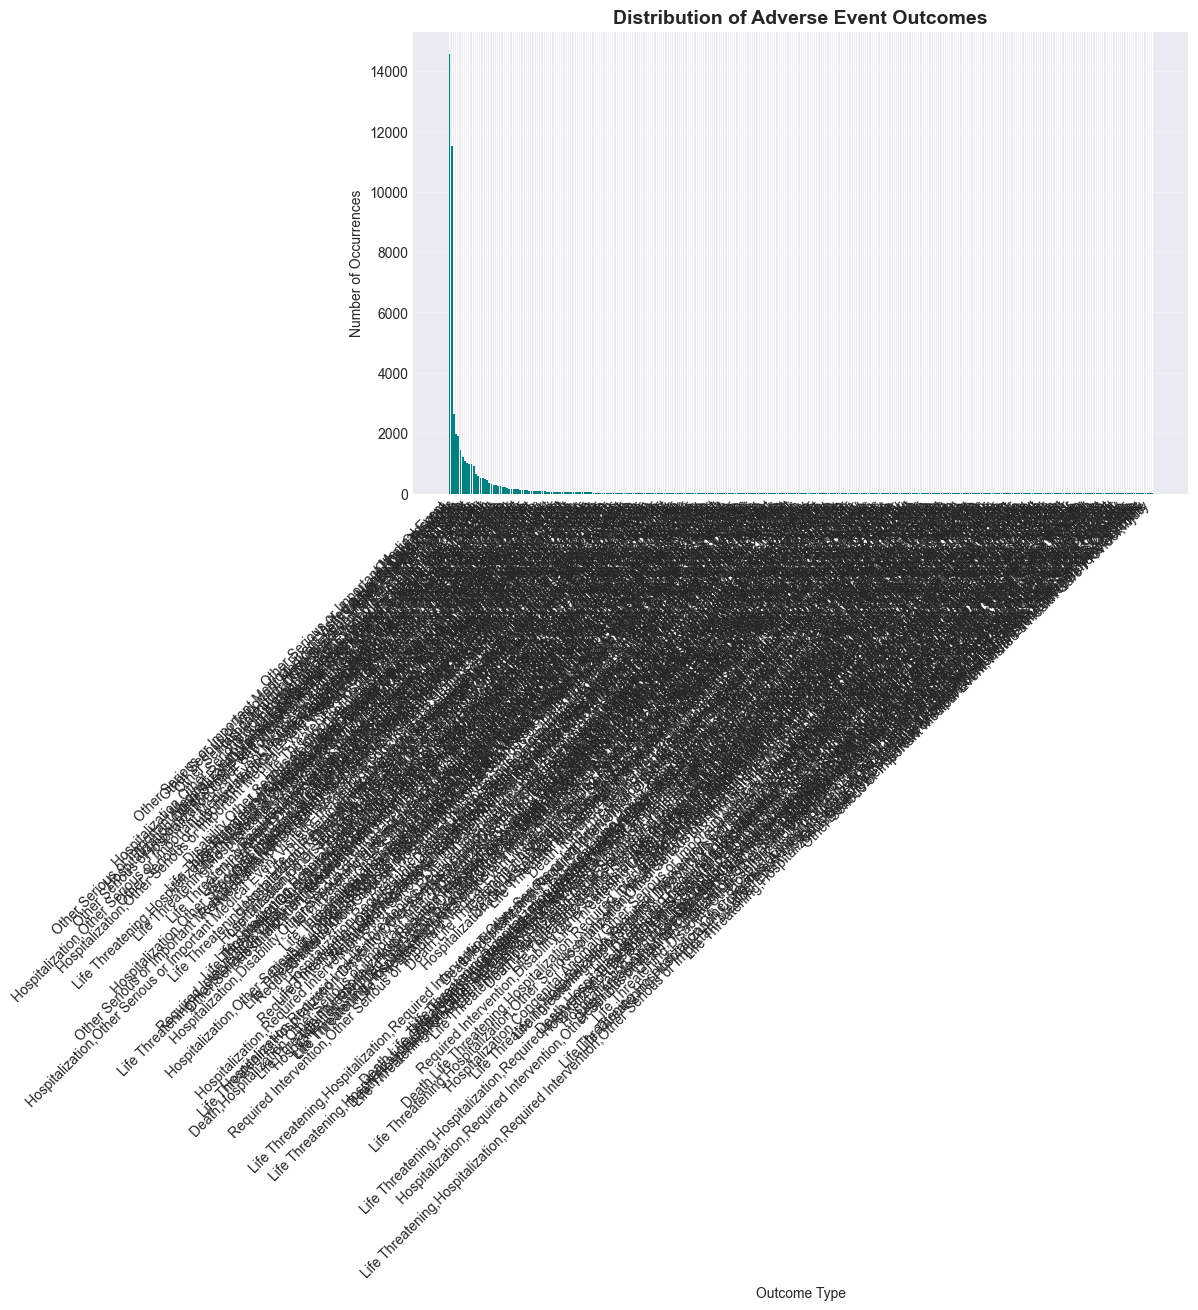

In [38]:
# Visualize outcomes
plt.figure(figsize=(10, 6))
plt.bar(outcome_df['Outcome'], outcome_df['Count'], color='teal')
plt.title('Distribution of Adverse Event Outcomes', fontsize=14, fontweight='bold')
plt.xlabel('Outcome Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. Consumer Demographics

In [39]:
# Age analysis
age_data = df['consumer_age'].dropna()

print(f"Age statistics:")
print(f"Mean: {age_data.mean():.1f} years")
print(f"Median: {age_data.median():.1f} years")
print(f"Min: {age_data.min():.1f} years")
print(f"Max: {age_data.max():.1f} years")
print(f"Std: {age_data.std():.1f} years")

Age statistics:


TypeError: Could not convert string '69.0084.0073.0028.0037.0064.526.007.0072.0045.0057.0059.003.0050.0068.0084.0061.0040.0055.0071.0036.0071.005.7159.0055.0047.0069.0019.0089.0068.0051.0059.0076.0072.0064.0070.0072.0035.0075.0078.0070.0031.0074.0070.6047.0028.0034.1028.0077.0059.0030.0062.0024.0030.0057.008.0049.0083.0051.0036.0097.0067.0052.0018.0054.0051.0015.0039.0061.0022.0025.005.0019.0030.0054.0070.0037.0091.0039.0055.004.0016.0047.0044.007.004.0065.0061.0057.0021.0067.004.0029.0049.0074.0055.0065.0034.008.0057.0088.0028.0074.0023.0036.006.0041.006.0035.7126.0035.0236.0043.0014.0060.0070.0063.0063.0055.0077.0055.0025.0079.0054.0036.0054.0067.0079.0015.0063.0037.0044.0047.0094.0075.0047.0063.0019.0056.0042.0020.0070.0061.0059.0026.0040.3917.0032.0054.0062.0051.0048.2159.0061.0037.0050.0042.001.0029.0059.0038.8454.0081.003.0044.4314.0023.0013.0044.006.0068.0043.0035.0020.002.0042.0023.0046.0014.0045.0015.0045.1644.0019.0017.0073.008.001.0063.0012.0048.3219.0016.0080.008.0069.0046.0061.0066.0013.0025.006.0031.0084.001.0035.0040.0044.002.0030.0050.0060.0059.6873.0052.0080.0055.0038.2078.0043.004.0027.0015.0029.0017.0032.0025.4214.0041.003.0083.0047.0019.005.0025.6843.0075.0037.0053.0024.4210.0090.0068.0072.4752.0081.0012.0050.0064.0032.0051.0059.0052.0049.0030.0065.0022.0081.0053.0086.0053.0063.0055.0085.0042.0030.006.0010.003.0070.0039.0034.0074.0074.0030.0040.0018.0059.0081.0010.0072.0087.006.0076.0065.0049.0042.0013.0038.1041.0075.0085.0057.0061.0069.0091.0068.0075.0043.0056.0050.0061.0042.0032.0055.0025.0058.0060.0070.0054.0080.0058.0051.0076.0064.0062.0051.007.0077.0054.0048.0036.6052.0052.0018.0037.0037.0059.0070.0079.0082.0034.3046.0025.0074.0090.0074.8610.0064.0042.0058.0022.0056.0056.2062.0070.0024.602.0082.0060.0047.0067.0041.0075.0034.0034.0092.0089.0021.0018.0057.0010.0070.8738.0035.0070.0081.0071.003.0022.0066.0054.0080.0055.1039.0085.0052.0062.0035.8057.0018.0045.0022.0043.0016.0073.0077.0017.9031.0040.0020.0035.0025.003.0019.1043.0072.0041.0066.0035.0032.002.0080.004.0020.0056.0061.0045.0059.0063.0063.0094.0084.0033.0039.0055.0061.0087.0026.0072.0036.0063.6063.0010.0036.0027.0011.0016.0031.0056.0058.0042.0022.0040.0097.0037.0065.0055.0062.5045.0027.0049.0094.0030.3036.0068.005.0059.0040.0049.0046.0052.0080.0015.0040.0027.0037.0030.0071.0077.0046.6533.0080.0079.0067.0023.0070.004.0022.0068.0083.0051.0024.0077.0031.0035.0053.0054.0062.0060.0072.0062.0033.0029.0052.0071.0049.0085.0026.0043.0050.0044.9032.1033.0082.0048.0016.005.0056.0049.0038.0055.0082.0092.0015.0038.008.0075.5076.0023.0074.0092.0061.0072.0031.0073.0085.0071.0039.0037.0051.0034.3076.0051.7033.8028.0021.0055.7024.0056.0030.0067.0053.0039.0031.0054.007.0046.0015.005.2043.002.0030.0063.0059.0038.0038.6063.1040.0068.0053.0031.0037.3061.0067.0080.0019.0062.0038.0065.0051.005.002.006.0031.0042.0034.0070.0026.0064.0055.0034.0036.008.0040.0059.0057.0033.0053.0018.0062.0014.0086.0037.0028.0014.0078.531.0036.0053.0083.007.002.0053.0032.0019.0037.0086.007.008.0078.005.0019.0080.0041.006.0061.0070.0066.0048.0070.0085.0030.0018.001.0075.0083.0040.0087.0059.0025.0076.0061.0074.0065.003.0016.0058.0068.0056.0079.0041.2243.0080.0058.0065.0044.0085.0056.0081.0037.0047.0034.0039.0064.0023.0059.0057.0054.0062.0044.0052.0020.0059.0053.0042.0039.0035.0081.0030.0031.0087.0084.0078.0011.0056.0076.0059.0042.003.0060.0035.0074.0080.0027.0041.0076.006.0078.0049.0031.0075.0044.0080.0047.3029.0019.0040.0064.0065.0021.0057.0064.0082.0063.5069.0045.0041.0028.0088.0091.0058.0040.0088.0031.0060.0081.0079.0022.0085.0054.006.0015.0050.0050.0082.0033.0058.0055.0020.0024.0050.0045.0080.0089.0075.0056.0083.0018.001.2630.0034.0030.0035.0049.0070.0049.0050.0060.0063.0046.0066.0049.0034.0013.0051.0038.0086.0033.0034.0032.0038.0064.0364.0068.0042.3064.5361.0074.0065.0073.0013.0073.0072.0037.0053.0056.0072.0079.0060.0067.0084.0058.0056.0064.0063.0086.0079.0042.0068.0063.0061.0048.0078.0059.0079.0085.0028.0080.0075.007.0035.7082.0088.0078.0076.0025.0035.0087.0029.0052.0053.0089.0062.0074.0035.0054.3089.0067.0031.0035.0089.0051.0057.0098.0064.0083.0013.0054.0072.0033.0055.004.006.0070.0060.0050.0033.002.0022.0079.0010.0073.0095.007.0039.0029.0058.0060.0067.0042.0080.0079.0066.0028.0069.0044.0026.0053.0034.0057.0028.0055.0075.0084.002.0051.0060.0044.0040.0016.0033.0051.0017.1930.0072.0024.0074.0034.0087.0017.0055.0024.0069.0035.0048.0043.0049.0071.0047.0036.0015.0050.0054.0067.0063.004.0049.0022.009.0025.006.006.0024.544.0041.7468.0055.0042.0048.0062.0038.0020.0059.0041.0045.0023.0054.0057.0044.0027.0037.003.0026.0065.0051.0061.0025.003.003.0064.0037.0017.0088.0065.0053.0059.0045.0076.0012.0088.0025.0076.0061.0017.0084.0082.0074.0063.0031.0030.0047.0062.0049.0081.0063.4663.0053.0033.0040.0068.006.0061.0028.0065.0043.0034.0058.0054.0068.0050.0026.0026.965.0020.0011.0079.0050.0062.0074.0068.0027.0082.0058.0079.0087.0086.0044.0076.0028.0081.0069.0080.0061.0011.0057.0071.0086.0063.0046.0038.0060.0026.0028.0052.0078.0044.0068.0057.7924.0039.0057.0016.0048.0083.009.0089.0992.0054.008.0075.0036.0093.0073.0050.0038.0045.3844.0048.107.0029.0058.0024.0027.0025.0091.0090.0077.0079.0044.0056.0030.0026.0053.0057.0062.0053.0048.5088.0058.004.0054.0052.0012.005.003.9046.8058.0056.0044.2172.2653.0034.0046.0019.004.0014.403.0050.0011.6074.0036.0024.0032.2080.0074.0063.0028.0064.0062.5015.0033.0018.0077.0019.0053.0055.0026.0026.0032.0045.005.0075.0048.0033.9076.0074.0063.0024.0059.0055.0026.0072.0053.0060.0082.0028.0032.0064.003.0039.0065.0078.001.0083.0059.0057.0028.0024.0034.0039.0070.0072.0059.0077.0053.0061.0084.0066.0039.003.0031.5056.0033.0054.0050.0071.0088.0051.0055.5961.0041.0036.0039.0068.0044.8064.0076.0045.0069.0054.0038.0029.005.0013.0027.0048.0013.008.0060.0020.0056.0021.0077.0072.0062.0027.0043.0033.0065.0030.0018.7035.0043.0028.0031.0039.0033.0078.0073.0019.0060.0027.0078.0031.0027.0039.0038.006.0043.0046.0050.0069.0064.0037.0047.0068.0051.0078.0037.0031.0076.0028.0064.0059.0021.0026.0022.0085.001.0049.009.0074.0043.0021.007.0049.0020.0024.0074.0025.0023.0034.5825.0030.923.0041.0072.0073.0021.0070.0052.0037.008.0037.0028.0020.0041.005.0014.0036.0077.0080.0093.0064.0045.0073.8010.004.0023.0069.0035.002.0073.0074.0036.0059.0051.0070.0043.0023.002.0048.994.0055.0030.0082.0034.004.0069.0065.0016.0082.0047.0057.0077.0017.0055.0065.5956.0084.0015.0016.0080.0080.0086.0010.0063.0070.0026.0037.0090.0044.0079.0039.0067.9558.0030.008.008.0051.0013.0058.0044.0082.0053.009.0082.0094.0064.0069.0052.0041.0020.0055.0077.003.0079.0065.006.0026.0094.0079.7260.0063.0039.0033.0040.0067.0055.0038.0021.0073.0082.0023.0049.003.0051.0036.0060.0035.0071.0035.9182.0058.0079.0069.0024.0082.0048.0031.1853.0085.0064.0019.0036.0087.0024.0040.0061.0074.0064.3253.0041.0033.0045.002.0055.0091.0076.0067.0070.0090.0030.0018.0037.0070.0059.0036.0052.0024.0069.0045.0044.0066.0055.0050.3074.0079.0083.0066.005.0067.0062.0072.0070.0058.0089.0064.0066.0049.0068.0070.0021.0022.0029.6035.1049.0021.0015.0069.0043.006.0047.0058.304.0041.003.0042.0032.0028.0052.0057.0040.0036.0051.0055.0073.0077.0052.1046.0050.0048.0016.0024.0045.0072.0054.6462.0035.0075.0058.0078.0081.0087.003.0075.0064.007.0056.0056.0015.009.1066.0060.0058.0063.6023.0036.0043.0079.4474.0068.0011.0046.0062.0070.0016.0052.007.0066.0036.0074.0060.0057.2343.0036.0089.0034.0027.0063.0066.0052.0085.0013.0066.0060.0016.0074.0057.0067.0046.0082.0032.0049.0088.0055.0060.0073.0065.0064.0035.002.0037.001.008.0049.0073.0059.0077.0033.2534.0025.658.0075.0025.6969.0022.0086.0036.0051.0058.0027.0059.0033.0075.0071.0034.0047.0082.0060.0036.0052.0025.0089.0025.0031.0053.003.0058.0051.0082.0032.0075.0076.0022.0058.0085.0015.0051.0023.0080.0515.0087.0087.0067.0022.0078.0043.0037.0015.0023.0037.0081.0074.0060.0076.0014.0065.0046.0092.0089.0045.0036.0064.0087.0050.0086.0045.0072.0091.0074.0070.0088.005.0011.0024.0046.0053.0041.004.008.0060.0042.0016.0026.0031.0079.005.0033.0025.0095.0083.0021.0048.0010.0082.0076.0059.0085.0040.0019.0017.2149.0049.0075.0020.0059.0034.0080.0043.0055.0017.0047.0094.0060.0054.0064.0045.0021.0072.0080.0057.004.0071.0027.0056.0053.0075.007.4075.0038.0066.2052.0084.0057.0070.0070.0052.408.0065.0068.0040.1051.5032.0049.0076.0067.004.007.0052.0062.0064.0079.0047.0022.0041.0083.0064.0050.0073.005.0043.0039.002.0056.9021.0049.0054.0023.005.0074.0051.0035.0031.002.0039.0034.008.006.006.6090.0046.0049.006.0024.0032.0032.0093.0070.0049.8017.0077.0068.005.005.0066.0055.0065.6061.0042.0061.0011.0059.003.6033.0035.001.001.0046.0035.0065.0061.0036.4033.0061.0046.0089.0015.0052.003.0056.0071.0075.0033.0069.0015.0036.0058.0078.0049.002.0067.0043.0050.0032.3221.0041.0049.0061.0010.0044.0043.0071.0081.0054.0037.0087.0042.0064.004.0074.0070.0054.00104.0037.002.0060.0057.0054.0024.0057.0057.0025.6754.0050.0063.0038.001.0035.0046.009.0026.001.0050.0046.0012.0035.0061.0033.9080.0090.0037.0067.0065.0020.0075.0010.0050.0040.0087.0049.0051.0084.0053.0057.0043.0033.003.0069.0088.006.8056.0026.3054.002.0018.0072.7084.0038.0043.0070.0013.0075.0054.005.0069.0073.0025.0029.0030.0029.001.0032.0039.007.0051.008.0026.0057.0049.0029.0054.0058.0070.0011.0087.0035.0079.0062.0087.0050.0041.0074.0039.0094.0043.005.0085.0050.001.0081.0014.0067.0042.0022.0064.0021.0038.0029.0078.0029.0076.0058.0033.0078.0046.0023.0078.0036.0026.0061.0053.0027.0038.0058.0060.0088.0051.0081.0083.0067.0026.3290.0044.0076.0032.0012.0081.0076.0065.0067.0081.4064.0062.0031.0077.0062.0056.0080.0083.0042.0066.0084.0038.2010.0030.6096.0043.0054.0022.0044.0062.0061.0064.0073.0078.0065.9464.009.005.0060.0074.0070.0072.0040.0066.0030.0088.0010.009.0046.9016.0025.0063.72101.0018.006.0035.0076.008.0061.2030.0031.0056.2058.0067.0023.0030.0062.3028.0047.0035.0011.0056.0057.009.0030.0025.005.0048.0063.0059.0071.0037.0084.0073.0064.0068.0048.2061.4034.0060.0055.0071.0077.0074.0066.0082.0030.002.0068.0075.0067.0082.0070.0090.0071.0063.0043.0063.0082.0070.0057.0065.0063.0061.0056.0064.0030.0072.0030.0091.0091.0010.0052.0050.0070.0082.0063.0055.0083.0040.0023.0042.004.0057.0067.0043.0025.0055.0066.0035.0037.0021.0073.0080.0065.0053.0064.0067.008.0060.0079.0073.0071.0082.0073.0053.0052.0039.0065.0032.0080.0086.0076.0075.001.0091.0072.0071.0051.0030.005.0055.0057.0055.0075.0061.0033.001.0033.0063.0045.007.0021.0062.0047.005.0036.6034.0081.0032.009.0077.6043.0026.0035.0056.0044.0047.0063.0081.0051.007.0034.8035.6072.9055.0049.0042.0061.0036.0050.0042.0055.0042.0033.0066.0033.0054.0070.0072.0064.0074.0052.0048.003.0061.0064.0076.0065.0069.3021.0034.0026.0049.0068.0083.0066.0064.0020.006.0034.0023.0071.0023.0068.0081.0035.0041.0048.0035.0056.0027.0056.0028.0031.0037.0010.0038.0042.0053.0062.004.0029.0020.00100.2330.0057.008.0027.0081.0029.0029.0057.0036.0028.005.0010.0020.0035.0031.007.00195.0045.004.0025.0024.001.0036.0032.0065.0080.0044.0064.009.005.0057.0024.0036.0062.0013.0079.0046.0022.0042.0075.0065.009.0028.0052.0075.0055.0031.0015.0026.0061.003.0086.0049.0072.009.0063.001.0059.0051.0041.0039.0042.0056.009.0052.0065.0021.0010.0077.0054.0015.003.0037.0035.0079.0059.0076.0059.0035.007.0020.0055.0067.0046.0063.007.0017.003.0011.0063.008.0060.0045.0026.0025.0072.0056.0030.004.00236.0061.0077.0018.0021.0056.0023.007.0021.0070.0091.0059.0050.0076.0021.005.0027.0053.0020.0031.0058.0065.0048.0061.007.0081.0083.0070.0063.0035.003.0075.0060.0070.0051.0050.0029.6081.0075.0072.0039.0086.0029.0075.0055.004.0057.0082.0073.0055.0063.0017.0050.0048.0020.0049.0061.0047.0014.0036.0068.0022.0055.0085.0059.0028.0018.0078.0024.0030.0031.0046.0014.0017.0041.3252.0041.0066.0059.0027.0067.0059.0013.0081.0083.0026.0070.0081.0074.0064.0039.0030.0070.0064.0065.0081.0094.0094.0013.0087.0034.0082.0085.0080.0055.0064.0054.2829.0035.0059.0054.0074.0090.0036.0015.0050.0066.0053.0011.0034.0049.002.0035.0058.0024.0087.0083.0057.0049.0053.0060.0062.6084.0038.0064.0053.4788.0040.0054.0076.0088.0046.0025.0086.0057.0027.0087.0050.0034.0078.0056.0022.0064.0020.0037.2030.6040.0046.0079.0017.0048.0020.0064.0059.0035.0063.0021.0035.007.0072.0032.0058.0048.0032.0083.0058.0031.2049.0072.0062.0039.0065.0068.0029.0050.0015.0027.0032.6053.0063.0023.0030.0019.006.0012.0077.0043.0064.7067.0045.0064.0037.008.0053.0054.9048.0078.0063.003.0042.0035.0054.0023.0089.0071.397.0069.6047.0064.0068.0075.0031.0059.0014.0035.0015.003.0028.0063.0036.0052.4071.0046.0046.3639.0037.0030.0031.0035.0011.0049.6065.0017.0063.0071.0020.0039.0059.0038.0036.0068.0065.0069.0080.005.005.004.0080.0028.003.0021.008.0034.0099.0034.0041.0044.0012.008.0034.0062.0063.0096.0072.0048.0081.0078.0048.0039.9021.0052.1033.0040.0035.3027.0054.0046.0034.906.0084.0011.0013.0012.0049.0041.0035.0043.0038.0024.0079.0035.007.0011.0057.9454.0048.0072.0066.0079.002.0050.0040.0014.001.005.0014.0052.007.0018.0034.0078.0040.009.002.0060.0065.0032.8612.0053.007.0088.0065.0053.0059.0078.0039.0065.0047.007.0046.009.0060.0049.0052.0070.0060.0025.0077.0060.0065.0064.0038.0084.0062.0071.0034.0023.0069.0055.0072.0015.0056.0053.0055.0065.0044.0064.0059.0063.0085.0057.0081.0056.0072.0060.0051.0069.008.0028.0065.0085.0025.0025.0046.0015.0052.0051.0028.0088.0090.0026.0033.0041.0031.0039.0072.0090.0086.0065.0044.0061.0038.0054.0069.0064.0072.0033.0029.9058.0063.0036.0074.0024.003.0034.0043.0047.0071.0039.8077.004.8019.5027.0033.7052.007.0045.0051.0050.0024.0026.0028.008.0074.0039.0049.0082.0041.0051.0047.0026.0083.0061.6036.0034.0033.007.0041.0083.803.0057.0040.006.0073.0089.0025.001.0039.8069.0035.0060.0072.0089.0028.0010.0059.0080.008.0056.0016.0041.2041.0059.5614.0036.0029.0084.0042.0059.0071.7085.0058.0053.0015.0077.0016.004.0026.0054.0057.0027.0066.0076.0070.0069.0054.002.0077.0010.0065.0063.0058.0059.0065.004.0090.0023.0054.00105.0023.0021.0076.0081.0067.0038.005.0075.0063.2041.0072.0019.0039.0074.0036.0053.0066.0030.0086.0058.0039.001.0055.0029.0011.0016.0081.0011.0066.0033.0011.0048.0016.0057.009.0028.001.0045.0034.0037.0042.0072.0056.006.0082.0029.0068.0037.003.0034.0044.0076.0065.0034.0048.0037.0075.0062.0011.0036.0034.0053.0020.0033.0069.0061.002.0060.0063.0027.0052.0085.0016.0010.004.0066.0077.0021.0062.00259.0077.0055.0061.005.0054.0010.0058.0071.0079.0067.0025.0080.004.006.0079.0065.0059.0066.0087.0050.0042.5066.0058.0071.0069.0082.0075.005.0019.004.0074.003.0030.0086.0019.0064.0042.0063.0055.0080.0071.0073.0056.0058.0078.002.0080.0052.0065.0028.0043.0018.0049.0029.0049.0087.003.0059.005.0022.0071.0085.0042.0021.0068.0038.0058.0039.0063.0078.0035.0084.0026.0030.0041.0065.0085.0075.0034.0038.0062.0087.004.0079.0066.0053.0069.0014.0071.0042.0077.0067.0043.0084.0076.0063.0078.0069.0074.005.0033.0083.0087.0025.0082.0076.0065.0048.0085.0053.9348.0026.0074.0043.0070.0251.0081.0029.0036.0046.0070.0061.0068.0025.0081.0052.0066.0064.0049.0046.0099.0077.0037.0047.0058.0080.0082.0041.003.0041.0066.0067.5027.0030.0054.0038.0047.007.0049.0029.0090.0077.0032.0075.0069.0020.0076.0086.0087.9870.0027.0080.0090.0054.0079.0078.0013.0023.0071.0057.0056.0041.0074.0080.0077.0044.0060.0049.0011.0066.0038.007.0057.0033.0048.0076.0035.0085.0068.0070.0026.0054.0033.0053.0032.0041.0017.0045.0031.0043.0084.0072.002.0078.0034.0074.0028.0022.0051.0084.0046.0016.0057.0059.0046.0038.0077.0093.0064.7339.0047.0092.0065.0032.0035.006.0067.0048.0030.0040.0031.0042.0019.0074.0081.0076.0075.006.0071.0083.0050.0059.0077.0020.0062.0061.0089.0080.0048.0045.003.0076.0025.0067.0033.0084.0076.0052.0048.0084.0046.0068.0069.0027.0073.0067.0052.0076.0084.0057.0064.0039.0018.0057.0067.0057.0020.0063.0087.0055.0075.0030.0035.005.0075.0060.0058.00129.0042.0028.006.0068.0073.0076.0018.0072.824.0018.0068.0067.0081.0050.002.0023.0078.0064.0035.0077.0021.0020.0075.0068.0070.0011.0084.0095.0076.0059.0057.0029.9032.0031.0020.0026.0065.0081.0074.0044.0058.0070.0076.0040.0069.0070.0073.0076.0021.0019.0037.0088.0045.0035.0088.0022.0049.0062.005.0074.0032.0056.0017.0062.0055.0058.0019.0089.0080.0060.0036.0034.0092.0014.0057.0031.0030.0090.0062.0021.0017.8059.002.0031.0026.0054.0010.0086.0037.5049.5012.0062.0071.0033.0054.0060.0060.0070.0025.3039.0081.0017.0067.0081.0028.0042.0024.0068.0088.0034.0080.0065.0045.0047.0079.0033.0041.0054.0039.0047.1050.0070.0072.0036.0056.0064.0033.0081.0054.0036.0062.0059.0082.003.0063.0051.0040.0081.0035.0013.0019.0043.0055.6035.8030.0013.0026.0017.0012.0018.0033.0042.0026.0068.0076.0061.0023.0031.0034.0046.0069.0078.0082.0018.0020.0033.0058.0016.0064.0074.0090.0034.0074.0065.0073.0050.0028.0024.0021.002.0034.0066.0017.0030.002.0015.009.0025.0051.0073.0080.0025.0069.001.0068.0043.0076.0034.0034.0019.0029.0035.0043.0057.001.007.0025.0022.0017.0073.0035.0018.0033.0025.0069.0058.9131.0059.0049.0042.0052.0029.0066.0072.0094.0079.6072.5041.0054.0041.0054.0023.0074.0047.0055.4018.009.0055.0029.7015.0090.0026.0053.0078.003.0053.0010.0021.0047.0069.007.006.0045.0054.0011.0053.0072.0020.0021.0064.001.0029.0046.0017.008.0068.0055.0040.2124.0084.0036.2418.0061.0027.0065.0058.0058.4049.0073.0067.0066.0035.0093.0011.0043.0065.0070.0044.0038.0040.0044.0023.002.0058.0072.0073.0061.0026.0071.616.0039.0056.0063.0014.001.0053.0066.0077.0033.0065.0071.0076.0041.0036.0072.0074.0031.0034.0074.0040.0092.0041.0054.0040.0040.0069.0088.0054.0030.003.0083.0025.0069.0062.0064.0084.0086.0083.0034.0083.0056.0081.0053.0091.5035.0039.0058.003.0025.0090.0035.0081.0063.0038.0050.0017.005.0093.324.0045.003.0011.004.0058.0060.0050.0038.0067.0016.0082.0039.0028.0090.0084.0059.0032.0055.002.0075.0010.0024.0059.0020.0023.0078.0058.0010.0068.0086.0034.0038.0089.007.0054.0076.0069.0083.0031.0047.0072.0012.0089.0013.0057.0060.0026.0049.0033.0048.7830.0065.0062.0022.0085.0035.0067.0039.0096.0026.8042.004.0021.0073.0078.004.0081.0056.0057.0036.9069.0019.0043.1024.0082.0063.0063.0071.0059.7026.0036.0022.0062.0034.003.0048.4057.7056.0051.0048.0057.0058.0050.0057.0052.0063.2345.0072.0065.0054.3037.0070.0070.0026.0034.0072.0038.0053.002.0027.0059.0071.0030.0061.002.0056.0071.0055.0022.008.0040.0041.4841.0084.0074.0077.0066.0080.0084.0035.3044.0037.0010.0052.004.0033.4445.0070.0071.0055.0043.0064.0071.0055.0025.0071.0080.0027.0054.6044.0065.0067.0061.0040.0085.0065.0032.0084.0053.5359.0075.002.0044.0010.0011.0086.0070.0060.0018.0083.0050.0050.0016.0074.0045.7069.0056.0045.0039.0042.9070.0066.0029.0062.0042.0057.0065.0049.0038.0034.0046.0075.0040.0020.0059.0013.0014.0038.0060.0047.0060.0052.0058.0031.007.0041.0069.0061.0087.0034.0011.0050.0062.0034.0061.0041.0062.0055.0030.0053.0038.0079.0059.0034.0030.0054.0046.0026.0046.0025.0051.0087.0069.007.004.0068.0061.002.0076.0035.0063.001.0015.0078.0052.006.0045.0077.0079.0028.0048.0024.0090.0075.0073.0063.005.0058.0079.0062.0030.0024.0063.0053.0067.0063.0068.0054.0051.0061.0051.0079.0013.0081.0070.0041.0070.0054.0050.0031.0038.0036.0041.0082.0042.0070.0087.0042.0077.0030.0013.0060.0053.0065.0071.0087.0090.0081.002.0075.0086.0021.0075.0079.0043.0082.0061.0071.0059.0087.006.009.0066.0065.0091.0031.0013.0050.0036.007.0022.003.0032.0082.0075.0060.0064.003.0090.0025.0036.0028.0083.0068.0035.4350.002.0064.0052.001.0077.0068.0048.0049.0019.0062.0059.0046.0030.0069.0060.0086.0076.0024.0022.3047.0034.0041.0082.0056.0057.0068.0086.0014.0010.0015.0053.0071.3053.0040.005.0033.0030.0019.9035.0093.0036.0032.0031.0052.0079.0049.0030.0075.0012.006.0072.0076.0040.504.004.0033.0039.006.0090.0069.0038.0031.0064.0052.0023.8071.0036.0027.8077.0030.4092.0069.0061.0046.0030.0029.0015.0019.0027.3029.006.0051.0081.0072.0053.0074.0085.0022.0046.0037.1026.0075.0038.0064.0059.5663.0057.3029.0084.0059.0063.0074.0070.0038.0038.0064.0030.0052.0036.0072.0037.009.0060.0056.007.0059.0071.0059.005.0035.0015.0036.0034.0037.0010.0026.0069.7955.0049.0041.0018.006.0037.0016.0061.0016.0060.0030.0064.0067.0027.0053.2369.0074.0037.003.0033.0050.0059.0081.004.0054.0017.0053.0016.0015.0048.0049.0066.0037.0050.0087.0042.0050.0084.0066.0065.0019.0065.0037.0052.0030.0021.0041.009.004.0045.5254.0089.0049.006.0084.0073.0075.0066.0024.0034.002.0089.0015.0023.0072.0068.0077.0033.0067.0091.0052.0049.0052.0087.004.0085.0078.0042.0074.0020.0079.0010.0026.0078.0060.0071.0073.0045.0068.0074.0048.0048.0058.0072.0051.0061.0061.0069.4260.0033.0070.0033.0078.0048.0066.1051.0042.0068.0070.0039.0090.0016.0015.0026.8029.0096.0070.0070.0024.0073.0072.0023.0025.0030.8080.0039.0032.0056.0070.008.0081.0063.0070.0059.0048.0013.0079.0018.007.0046.2033.0043.0087.0051.0030.005.0054.0083.0068.0074.0071.0039.0013.0061.0048.0077.0079.0045.0038.0051.0043.001.0042.003.0030.0032.003.004.0060.9060.6066.0062.008.008.0031.0062.0038.5048.0069.0028.7665.0079.0081.0059.0018.2445.0047.0062.0035.0051.0017.0059.0072.0064.0067.0029.0038.0062.009.0090.0021.4036.0042.0069.0037.0079.0043.0078.0084.0074.0060.0076.0038.0019.0025.209.007.005.0044.0086.0053.0063.0039.0036.0058.0065.0053.0049.0037.0020.3056.0040.006.0029.602.0045.0057.0069.0056.006.004.0060.008.0050.004.0057.0026.0065.0058.0064.0069.0076.0054.0060.0081.0029.0045.0073.0079.0026.0050.0067.0061.00108.0024.0049.0071.009.0093.0071.0071.0032.1060.0010.0062.0019.0038.0081.0055.0080.0023.005.7030.0064.0078.006.0082.0066.0053.003.0094.0026.0044.0025.002.0010.0065.0032.0022.0053.0035.0079.0029.0022.0078.0075.0056.0086.0072.0076.8223.0068.0057.0049.0085.0019.0035.0023.0081.0085.007.0034.0075.0068.0069.002.0049.0076.004.0070.0082.0084.0074.4869.0018.0067.0011.0064.0057.0045.0018.0056.0055.006.0061.0065.0030.0065.0059.004.0033.0048.0063.0025.0082.0055.0068.0065.0064.0077.0089.0020.0038.0024.0046.003.0060.0068.0060.0078.0078.0060.0065.0010.0026.0071.0078.6047.0047.0074.0026.0056.0054.0022.0063.0056.0043.005.0090.0031.0070.0074.0071.8478.0037.0061.0072.6171.0069.0028.0040.0030.0037.0041.0064.004.0071.0086.0057.0031.0044.0076.0049.0045.0043.0063.0079.0085.0047.0067.0033.0064.009.0077.0056.2081.0039.0075.0080.0087.0065.0069.0074.0040.0080.0038.0058.0068.004.0035.0063.0065.0042.0059.0060.0034.0056.0070.0044.0051.0037.8042.9083.0060.0079.0052.0079.0059.0049.0045.0058.0078.204.4058.0086.0035.0075.0024.0040.209.0043.0045.0063.0038.0067.0066.0067.004.0025.0079.0041.0090.0068.0037.0038.0061.0089.0068.0077.0058.00104.0066.0054.0043.6090.0061.0062.0078.0078.0064.0032.0073.0013.0076.0065.0032.0037.0065.0080.0036.708.0041.0062.0064.0045.009.0014.002.005.0045.0013.0031.9068.0085.002.0034.0063.0018.0085.0050.0051.0036.0054.009.0029.113.0059.0066.0029.0047.0051.0048.0035.9653.0018.0059.0084.003.0024.0045.0032.7066.0019.003.0073.0085.008.0030.0017.0061.0063.005.0046.0020.004.0014.0017.0054.0057.2244.0059.0010.0023.0060.0035.0084.0064.0034.0053.0033.0054.0031.0075.0074.0037.003.0070.0045.0027.0073.0015.0017.0037.0074.0028.0046.002.0059.0031.0075.00238.0026.0018.0076.0058.0048.0037.0071.0081.0037.0040.009.0060.5738.0027.4629.4615.001.0010.0045.0024.0023.1394.0049.0042.0052.0023.0034.004.0080.0040.0076.0044.0055.002.004.0042.0055.0059.0018.0027.0980.0066.0029.0098.0062.0032.0025.0027.0051.0068.0010.0014.0034.005.0033.0061.0024.0083.0020.0063.0013.0027.0074.0070.0017.0035.0034.0062.0062.0054.0017.0085.0049.0057.0036.0067.0047.0048.0069.002.0059.0046.0063.0054.006.0064.0015.004.0082.0051.0085.0089.0021.0075.0038.0078.0055.0063.0031.0050.0032.0080.0090.002.0072.1733.0061.0069.0079.006.0054.0082.0028.008.0077.0038.0029.0034.0042.0063.0030.0073.0053.0082.0024.0069.0083.0055.0084.0057.0069.0063.0061.0046.0048.0077.0070.0035.0067.0030.0073.0011.0034.0057.0077.0010.0069.0070.0077.0049.0066.0044.0050.007.0073.0094.0081.0032.0078.003.0071.0043.0069.0025.0065.0043.0026.0075.0064.0054.0064.5045.001.0044.0016.0049.0044.005.0042.4061.0083.0011.0041.0070.0079.0034.0070.0038.0061.0037.006.0027.0034.0060.0060.0030.009.0052.0032.707.0089.8034.5055.0038.3060.0051.0040.0056.0017.0052.0073.001.0074.003.0092.0025.0063.0057.0026.0077.0067.0092.0032.0057.0074.0010.005.0050.0026.0035.0031.0042.0011.3054.0065.0011.008.0058.0021.0045.0010.0061.0059.0014.0060.0054.0070.0048.0046.0036.8037.0023.0050.0030.004.0055.0071.0026.0049.0031.0084.0024.0065.0028.0024.0052.4044.0057.0083.0055.0025.0078.0048.0068.006.0015.0055.0036.0069.0040.0072.002.0034.0026.1535.004.0030.0041.0068.0041.0057.0046.0053.0062.0072.0070.0059.0041.1766.0020.0083.0041.0025.0041.0051.1862.0058.0058.0097.002.0071.0041.0075.0018.004.0055.0061.006.0077.0020.0055.0073.0065.005.0018.0032.008.0013.004.0083.0025.003.0045.0016.001.0060.0059.0027.5647.0039.0056.0023.0031.0055.0050.0064.0064.0048.7257.0057.0045.0070.0040.0080.0065.0043.008.007.004.0041.0090.0059.008.0077.0068.0022.006.0074.0081.0083.0050.0026.0022.0050.0019.0016.0028.0056.0038.008.0052.0057.008.0047.005.0057.5756.0065.0087.0057.0050.0078.0070.0077.0077.0078.0044.0086.0046.0046.0041.0046.0038.0059.0017.0047.003.0032.0068.0057.007.0070.003.0089.0040.0081.0089.0070.0021.0063.0085.0065.0052.1646.0061.004.0023.0050.0039.0059.0029.0045.0027.0025.0084.0082.0051.003.0085.0041.0090.0035.004.0029.0076.0077.004.0064.0072.0033.0090.0058.0012.0065.0038.0085.0065.0065.0078.0039.001.0047.0072.0055.0034.0075.0073.0033.0081.0068.0070.0073.0092.0037.0027.0058.007.0061.0052.0037.0050.0055.0046.0080.009.0038.0014.0092.0026.0040.0073.0041.0071.0045.0075.0042.0047.0040.303.5075.0087.0086.0050.0083.0053.0077.0022.0077.0043.0051.0063.0042.0056.0049.003.0049.0038.0056.9076.0033.0010.0037.0036.0072.0070.0055.0043.0077.4071.0074.0077.002.0025.0017.0063.0071.0034.0067.006.6070.9018.0061.0026.0027.0065.0058.0036.0098.0050.005.0035.0051.0043.0026.0042.0022.0035.0041.0061.0070.0053.0072.0035.0054.0033.0032.307.0086.0057.0026.0040.0038.0034.0054.0037.0042.0074.0012.0058.0051.0055.0025.0027.0068.0015.0034.0043.0012.0089.0067.004.0065.0099.0081.0058.0062.0061.0035.0046.0078.0044.0042.0063.0068.0039.0085.0050.0056.0034.0068.0079.0088.0042.0058.0082.003.0094.0086.007.0077.0065.002.0078.0047.0044.0063.0011.0049.0067.0038.6956.0052.0040.0066.0069.0095.0076.008.0043.0095.0078.0088.0021.0030.0052.0021.0056.0080.0036.0030.0026.002.0080.0073.0052.0090.002.0040.0038.0050.0021.006.0030.0039.0039.6066.0050.0052.8094.0076.0045.0010.0058.0053.3050.8031.8038.0059.7069.0033.0037.0031.0036.8041.0075.0063.0020.0062.0065.0065.0071.0053.0086.0055.0036.0044.0065.0046.2053.0027.0037.0017.0048.0643.1531.003.0010.0072.0068.0076.4438.0018.005.0078.004.002.0046.008.0049.0085.0032.0029.0039.0065.0048.0036.0013.0046.624.0043.4773.0081.0044.0079.0042.0025.0076.0012.0077.0052.0029.003.7337.0063.0077.0041.0050.0065.0055.0059.0037.0058.0020.0067.0041.0082.0018.0060.0036.0079.0044.004.0060.0071.0043.0065.0026.0071.0036.0036.0062.0059.0075.0081.0055.0046.0028.0070.0037.0043.0064.0020.0063.8376.0035.0027.0022.0024.0076.0066.0042.0071.0072.0072.0050.0066.0025.0039.0058.0080.0082.002.0021.0049.0065.0074.0029.0085.0072.0077.0079.0022.0038.0067.0023.0048.003.0067.0022.0068.0067.0043.0046.2355.0047.0054.0026.0063.0079.0036.0055.0066.0042.0013.0020.0074.0022.0034.0072.0048.0086.0081.008.0011.0036.0030.0094.004.0073.0034.0077.0075.0085.0079.0092.0052.0070.0040.0027.4244.0081.0063.0062.0054.0063.0070.004.0071.0069.0084.0020.0084.0060.0052.3045.0050.0040.0035.0059.0064.0041.0073.0046.0062.0060.0058.0027.0059.0082.0029.0022.0046.0011.0041.0090.0087.0053.0054.0063.4643.0052.0048.0026.0074.0086.0026.0044.0053.0062.0027.0044.0030.0012.0067.0050.0048.0066.203.0039.0054.6038.0060.0061.0044.0075.0032.001.0079.0030.0054.009.0062.0056.0045.0060.4072.0031.0044.0052.0058.0050.004.0041.9588.0063.0036.0039.0037.0049.0058.3263.0074.0086.0093.0010.001.0039.0061.0073.0068.0044.0042.0085.0031.0078.0037.0037.3022.0072.0071.0054.0019.0058.0036.0037.0066.0043.0052.0037.0039.0052.0070.001.0050.0062.0059.0077.0040.0057.0028.0066.0082.0027.0064.0034.0026.0074.0048.0084.0042.0062.0056.0048.0025.0060.001.0015.0063.0011.0061.0065.0032.0021.0032.0074.0037.002.0071.0016.0044.0057.0046.004.0079.0083.0026.0082.0070.0077.0031.0073.0086.0089.0076.0066.0073.0077.0031.0078.0065.5569.6378.0045.002.0065.0016.0052.009.0088.0067.0076.0071.0058.0081.0047.0040.0010.0039.0033.7721.0066.0030.0056.0080.0067.0052.0029.0036.0064.0078.0055.005.0059.0027.0067.0069.0011.0065.002.0011.0081.0027.0066.0073.0055.0070.0084.0050.0058.0061.0055.0023.0086.0064.004.0051.5086.0055.0070.0032.0057.0054.3012.6036.0063.0064.0034.4060.1042.0064.0021.8060.0070.0061.4021.0033.0061.0041.0020.0047.0024.0069.0037.0021.0083.0062.0065.0063.1046.0035.0045.0059.0026.0036.0063.0030.0066.0048.003.0034.0053.5518.1040.0068.0077.0047.0039.0086.3864.0074.0018.0081.0054.0031.0013.0010.0053.0031.0335.0077.0057.0051.0027.0026.0039.0056.0029.0045.0056.0021.6151.003.0067.0045.0081.006.0071.0021.0017.0043.0081.0033.0058.0010.0027.0047.0058.0010.0078.0084.0055.0052.0030.0053.0084.0056.0081.0057.0045.0081.0068.0084.0060.0037.0026.0036.0073.005.0043.0073.0089.0023.4158.0069.0085.0010.0060.0083.0047.0071.0089.0065.0068.0043.0018.0074.0071.0067.9078.0076.0047.0036.0082.0034.6073.0085.005.0024.0030.0058.3626.0037.0017.0064.0068.0077.0053.0059.0060.0074.5041.0030.0042.0076.0032.0010.0062.0048.0074.0011.0062.0038.0055.9084.008.0033.0081.0053.2047.0029.0036.0024.0019.0078.0049.0082.0032.009.0059.0025.8072.004.0053.0080.0066.0070.0077.0056.0094.0030.0053.0045.0022.0071.0045.0015.002.0084.0023.0031.007.0045.2055.0015.0030.0042.0042.0043.0032.0076.0080.0031.0044.0072.007.0050.0056.0044.0035.0069.0039.0065.0027.0032.0052.0048.0067.0068.0085.0025.005.0067.0054.0073.0027.0082.0067.0080.0016.0019.0063.0062.0083.0032.0084.0049.0070.0029.0010.0051.0068.006.0019.005.0070.0080.0040.0057.0078.003.0065.0016.0050.006.0035.0045.0060.0029.0064.0042.0022.0026.0048.007.006.0054.0044.1926.003.006.0025.0053.0016.002.0036.0019.0061.0056.0050.0042.0016.0058.0011.0055.0024.0013.0024.0069.0073.0043.0032.3858.0081.0026.0050.007.0068.0072.0069.0030.0052.0025.0062.0026.0030.0067.0057.0031.0069.0077.0079.0086.0032.0041.0031.0064.0046.0031.0082.0068.0048.0042.0087.0072.0064.0084.0040.009.007.0062.0013.0091.0067.0019.004.0067.0036.0040.0032.005.0072.0025.002.0068.0058.0063.0053.0016.0037.0034.002.0054.0024.0069.0061.0072.0019.0042.0043.0053.0014.0057.0062.0063.0035.0073.0062.0069.0061.0055.0035.0066.0083.0067.0033.0036.0080.0066.0064.0063.0028.002.0049.0053.0085.0036.0024.0088.0057.0041.0041.9039.0071.0030.0028.2024.0077.0082.7044.002.0037.0040.0037.0044.0047.0088.0036.0017.007.0068.0066.0031.0013.0059.0068.0076.0042.0076.005.0011.0024.0016.002.0047.0020.0023.003.0036.0040.0057.0061.0080.001.0067.0057.0076.005.0072.0077.0065.002.0064.0062.0090.0082.0073.0078.0010.0075.0038.0017.0061.0047.0069.4474.0058.0069.0078.0037.0054.0032.0056.0021.002.0086.007.0079.0080.0024.0081.0041.0021.0056.0047.0047.0070.0037.0075.0067.0052.0048.0031.0067.0053.0026.0082.0061.0072.0026.0080.0048.0058.0019.0035.6127.0069.0036.0047.0052.0049.003.0076.0046.0056.2041.0024.4259.7210.0044.0062.0062.0074.0065.0030.0071.009.60113.0065.0072.0065.0076.0016.1671.0057.0011.0028.0038.0063.0069.0040.0029.0048.0036.2060.0068.0053.0079.0047.9292.0030.3372.0024.0062.001.0054.0046.0048.0035.0069.0082.0014.0082.0069.0048.0031.3274.0055.0054.0096.0037.0035.0061.0059.0073.0074.007.0037.0044.8037.003.0053.0059.0055.008.0063.0053.008.0038.002.0087.0070.0075.0054.0080.0084.0047.0026.8042.8075.0077.0010.0039.0023.0061.0036.0047.0023.0079.0036.0041.0045.1051.0079.0042.0014.0059.0086.0041.0028.0038.0070.0020.0032.0050.9075.0021.0017.0022.0064.0076.0043.0067.0093.0026.2043.0057.0055.0055.0059.0063.0035.0055.0029.7060.0013.0025.0051.0028.0041.0062.0069.0068.0023.0062.0039.0082.0036.0054.0033.0029.0080.0012.0085.0030.0038.0029.006.00111.0019.0055.0030.0022.0037.0011.009.0041.0052.0061.0051.0071.0069.0025.0082.0034.2589.0072.0049.0061.007.007.0030.0070.902.001.0064.0026.0063.0014.0026.0024.0057.0051.0046.0045.0079.0049.0077.0031.7032.0087.0062.0046.0064.0072.0062.0053.0023.0052.0028.0081.0071.004.0062.0063.0081.0021.0055.0054.0072.0017.0088.0055.0064.7071.0077.0050.0010.0035.0069.0058.1083.0042.0070.0062.0077.0032.0070.0070.0064.0062.0057.007.0064.0036.0019.0050.0059.0073.001.0052.0067.0056.0076.0045.0022.0056.4740.0065.0084.0067.7476.005.0026.0078.0047.0086.0038.0020.004.0057.0055.0060.003.0073.0061.0058.4069.0054.0077.0031.005.0053.5051.0057.0016.0078.0031.0079.004.0039.0047.0074.0034.0043.0041.0057.0064.0029.0055.4044.0032.0072.0088.0073.0062.0072.0088.0087.0039.1063.0063.0058.0019.4054.0081.0065.0042.0054.008.0024.0079.0058.0058.7779.0064.0060.0054.0091.0055.0039.004.0010.0025.0037.0046.0069.0032.0050.0068.0050.0050.0063.0035.8572.005.0048.0064.0037.0052.003.0023.0028.0073.0048.0051.0045.0063.0040.0035.0061.0041.0014.0075.0056.0021.004.0084.0032.0066.0055.0085.0047.009.003.0077.0025.5425.4439.0065.0061.0066.0073.7878.0030.0084.0062.0041.001.0079.0047.0047.0085.0045.0070.0035.0074.0035.0052.0064.335.0077.0074.0050.008.008.0073.007.0063.0050.0016.0062.0071.0014.0058.0048.0062.0039.0057.0017.0082.0060.0083.0055.0073.0065.0046.0077.0088.0056.004.3657.0076.0060.0093.0046.0073.002.0036.0085.0069.0053.0037.0073.003.0084.0059.0076.0083.001.0032.0078.0014.0039.0052.0013.0059.0086.0066.0058.0065.0094.0024.0026.0033.0072.0017.0038.007.0056.004.0057.0030.0044.0084.0046.0026.0027.0077.0042.5087.0034.0028.0084.0048.0064.0069.0056.0032.0035.0039.0015.0058.0044.0044.0053.0029.0040.0077.0029.0048.0063.2051.0033.0050.0056.005.0051.007.0064.006.0075.0025.003.0085.0065.0018.0043.0059.0041.0038.0060.0084.0071.0071.0085.0069.0032.0034.0061.0070.0017.0023.0015.0054.0031.0063.006.0045.0050.0081.0078.0067.0077.0060.0059.0047.0010.0076.0092.0087.0064.0052.0050.0045.0058.0084.003.0024.0043.0072.0031.0073.0079.0057.0062.006.0074.0014.0037.007.0053.0019.0076.0062.0063.0051.0037.0083.0062.009.0028.0056.0070.0064.004.0017.0022.0062.0072.0037.0056.0063.0040.0027.0039.0091.0031.0039.0080.0064.0077.0065.0030.2078.0043.0072.0047.8069.0072.0023.004.0031.0036.0038.009.0054.0037.0054.0092.0059.0034.0034.503.006.0054.0038.0011.0062.3081.0063.0026.0043.009.0030.0084.0032.0029.0030.008.0051.001.003.0023.0057.0010.0033.0024.0033.707.0028.0019.9075.0065.0053.0093.0040.0043.0013.0069.0038.0041.5522.0059.0035.001.0033.0018.006.0054.009.0040.0060.0075.0030.0039.0056.0060.0031.0070.0035.008.0074.0055.0020.0045.0049.0049.0052.0067.0072.0088.0060.0065.0022.0058.0059.0079.0019.0082.0038.0046.0049.0058.0061.0080.0036.0014.0075.0082.0045.0018.0030.1032.0035.3038.0089.003.0056.0041.7033.1055.7070.0051.8069.006.0081.0068.0081.0062.0058.0089.0062.0048.0015.0047.0040.0076.0047.0044.0056.0049.0072.0060.0077.0028.002.0029.0066.0073.0052.0090.0050.0061.0046.0091.0058.0065.0075.0048.0056.0083.0033.0035.0035.0060.0043.0031.0062.0061.0035.1061.0027.0051.0080.0046.0038.0036.8087.0060.4080.0039.0029.0022.0060.0054.0052.0038.0093.0044.0026.0066.0090.0091.0075.009.0029.005.006.006.9031.003.005.0061.004.8053.0073.004.0064.0038.0063.0033.0038.0072.0058.007.0072.0038.004.0019.0084.0075.003.002.0041.0064.0034.0057.0067.0091.0062.0072.0051.0041.0070.0055.0087.0032.0069.0079.0066.0030.0088.0071.0040.0011.0012.0099.0060.0084.0067.0030.0074.0046.0011.0064.0078.0027.0064.0072.0068.0079.0068.0066.0027.0055.0058.0036.0036.0020.0070.0086.0060.9044.0079.0032.0069.0057.0035.3045.0055.0010.0069.0031.0055.0060.0041.008.009.0076.0053.7041.9044.4070.0033.003.0043.005.0053.0076.0071.0032.0078.0061.0043.0012.008.0077.0015.0060.0043.0019.0052.0064.0073.0021.0046.0073.0067.0028.0035.0060.0044.0059.007.0012.0068.0090.0054.0061.0070.009.0041.0026.0071.0064.003.0019.0076.0076.0097.0076.0061.0025.0029.0067.003.0030.005.0088.0079.0070.0087.0016.0069.0014.009.0087.0089.0048.0064.0053.0081.0056.0072.0059.0064.0073.001.0062.007.0031.0089.0057.0085.0043.0039.0070.0075.0074.0055.0067.0035.0039.0064.0054.0061.0053.0073.0071.0034.0044.0053.0076.0030.0084.0030.0068.0012.0023.0059.0033.0037.0093.0085.0058.0049.0026.0062.0056.0046.0092.0062.0034.0037.0051.0084.0045.0020.5757.0080.0056.0076.0076.0037.0060.0044.205.0054.0058.0053.0014.0060.0075.0040.0074.0071.0085.0040.0040.0058.0021.0064.0028.0043.0060.0036.0045.0073.0080.0064.0039.005.004.0042.0080.0045.0055.0039.0033.0043.007.0061.0037.0045.0039.0056.0020.0075.0035.0059.0049.0037.0058.0026.0023.0033.0039.0033.0053.0036.0031.0032.0044.0061.0035.0023.0059.0034.0063.0060.0040.007.0031.8072.0062.0077.0045.0035.0054.0050.0056.0085.0059.0037.9054.0032.4038.0033.0063.0085.0065.0067.0051.0064.0046.6041.0061.0060.0084.0069.0083.0073.0093.002.0035.0082.0073.0088.0039.0030.0043.0034.0039.0031.0052.0046.003.2032.0068.0023.001.0077.0075.0035.7628.0011.0051.0090.0075.0032.0045.003.0027.0067.0028.0028.0085.0056.0068.0017.0083.0069.0072.0082.0043.0074.1270.0075.0052.0065.0052.0040.0029.0025.0025.9033.0052.0054.0055.0069.0035.0073.0023.0052.0039.0025.5029.0065.0013.0023.0021.005.0065.0065.0035.0052.0025.0047.0055.0061.0026.0053.0042.0065.002.0026.0067.005.9063.0074.0084.0066.0059.0030.0027.0027.005.0072.0060.0037.0071.1096.0088.0069.006.0018.0034.0040.0011.0089.0083.0045.0070.0034.0033.0051.5076.1039.0070.0029.0059.0024.0044.0033.0058.0069.0028.0034.0054.0040.0046.0021.0067.0056.0081.0036.005.0057.002.007.0052.0057.0078.0088.0018.0040.0037.0092.0079.0046.0041.5044.0067.0035.0029.0067.0063.0040.0028.0055.0097.0051.5856.0069.0067.002.0086.002.0087.0034.0065.0054.0038.0045.0014.0037.0033.0052.0027.9349.313.0058.3141.0053.0090.0017.0070.298.0025.043.0072.0063.0086.0028.0020.0034.0084.0027.709.0066.5031.0063.0034.0024.0021.0028.0046.0036.002.0032.007.0058.0027.0054.0056.0523.0069.0073.0061.0011.0031.001.009.0089.006.0076.0040.005.0037.0017.0052.0027.005.0055.0032.0067.0070.0070.0058.0027.0062.0086.0069.0044.0025.0062.0040.0064.0090.0062.0017.0020.007.0019.0059.0071.0080.0043.0037.0050.0042.0019.0016.0032.0789.006.0089.0089.0087.0080.0072.0052.001.0065.0045.0052.0068.005.0059.0062.0071.0033.0030.0068.0054.0061.0059.0069.8257.0090.0021.0074.0058.0038.0073.0082.2524.0028.0064.0036.0045.0059.0011.0050.0037.0084.0030.0040.0077.0029.0064.0079.0035.0075.0069.0062.0064.0020.0073.0060.0072.0062.0085.0040.0024.0063.0083.0019.0048.0071.002.0080.0050.008.0032.0015.0054.0043.0037.0054.0063.0020.0050.0019.0052.0092.0071.0069.0057.0081.0029.0060.002.0057.0041.0041.0080.0051.0022.4068.0035.0081.004.003.0036.009.0023.0055.0036.0061.0022.0047.0084.5027.0095.0062.0034.0028.0021.0040.0030.0057.0053.008.0049.002.0042.0040.0087.007.0097.0047.0011.0068.0059.009.0054.0044.504.0037.0044.0066.0022.0031.0037.0058.0068.0027.0033.0038.0086.0086.0024.0052.0083.0073.0020.0018.0036.0053.0039.0056.0028.0044.0034.5723.0045.8257.0042.0075.0060.0067.0083.0022.0058.0067.0069.007.0058.0059.0069.0031.0025.0044.0025.0022.0020.0076.0049.0084.0069.0049.7714.604.0067.0064.0060.0044.0063.0040.0062.0045.009.0043.0082.0024.00101.0053.8064.0023.3070.003.0051.0025.0035.0072.0058.0040.0080.0059.9832.0059.0061.0031.0053.0053.1567.0044.0087.0035.3024.003.003.004.0061.0036.0028.0070.0049.0027.0075.0033.0052.001.0052.0039.0041.0080.5240.0051.0054.0071.0064.0027.0072.0075.0031.0036.0045.0052.006.0011.0036.0038.0047.0042.0018.0030.0041.0059.0036.0036.0066.0048.0069.0066.0017.9041.0057.0042.6359.0033.0036.0052.0085.0058.0039.0045.0047.0078.0048.0064.0048.0089.0067.0021.0061.0066.0036.0052.0080.0086.0030.0031.0024.0054.0065.0077.0072.0058.3229.0032.0035.0054.0038.0026.0039.006.0044.3223.0032.0021.0077.0047.0060.0036.0062.0085.0070.0033.0029.0031.0068.0023.0078.0057.0075.0072.0039.0050.0031.0050.0036.0050.0081.0014.0015.0023.0075.0018.003.0069.0046.0056.0071.0050.0075.0074.0085.0060.0022.0014.0040.0042.0061.0048.0016.0098.0069.0075.0061.0053.0049.0018.0049.0074.0080.0090.0049.0085.0060.0040.0069.0024.0029.0078.0078.0091.009.0041.0063.0044.0082.0074.0064.5122.0070.7779.0040.0079.0059.0060.0067.005.0052.0022.0038.0055.0071.0059.0043.0037.0062.0028.0086.0026.0029.004.0043.0057.0070.0015.002.0076.0024.0060.0032.006.0013.0055.0053.008.001.0045.0061.0025.0035.0035.0078.0090.0070.0044.8039.0080.0039.0062.003.0014.0047.0060.0068.0056.0032.0083.0036.0053.0031.0074.0058.0082.0038.5041.9073.0031.0027.0018.002.001.0060.0011.8040.0057.0017.4055.007.0021.003.0039.0060.007.5030.0072.0084.0059.0061.0026.1072.0057.0061.0067.0084.0021.0060.0046.0012.0069.0030.0085.0051.0044.0028.001.003.0042.0026.0060.009.0043.001.0059.0049.004.0046.0070.0057.0038.0074.0091.0043.0079.0082.0067.0034.0033.0051.0074.0097.0048.0035.0045.0080.0022.0078.008.003.0037.4927.001.0049.2337.0063.0047.6670.9057.008.0089.0068.0053.0047.0032.0039.5657.007.0080.5046.0037.0014.0076.0039.0044.0035.0061.0072.008.0045.0024.0079.0040.4021.002.0030.0012.0037.0029.2029.0076.0077.005.007.0077.0011.0049.0017.0058.0035.0055.0066.0082.0072.0071.0090.0034.0021.007.0013.005.0048.0066.7012.0029.0053.0071.5067.5038.0012.0031.0048.0054.0050.9021.0037.0041.7074.0091.0030.0037.0011.0087.0073.0022.0038.0081.0067.0070.0040.0054.0051.005.0045.7030.0064.0035.0041.0029.0049.0092.0040.0080.0050.0037.0056.0029.0028.0076.0060.0013.0045.009.0055.0067.0044.0065.0019.0085.0030.006.0015.0032.0050.0054.008.0065.0032.0085.0063.0062.0074.0054.0062.0040.0071.0024.0047.0045.0049.0071.0039.0074.0078.0089.0072.0067.0056.0073.0083.0081.0051.0038.0076.0063.0057.0029.0054.0050.009.0078.0078.0078.0033.0090.0048.0025.0050.009.0064.0070.0077.0070.0062.0047.0068.004.0048.0068.0064.0088.0014.0052.0053.0058.0084.0069.0074.0055.0012.0062.0059.0074.0076.3766.3026.0055.0086.0032.0048.004.1664.0034.0030.0052.0053.0059.0033.7077.0076.0037.0080.0065.0076.0077.0054.6037.0070.0028.0062.0054.0068.0068.0051.0090.0040.2071.0081.0065.0048.0027.0028.0027.0063.0092.0035.0077.0020.0038.0044.0059.0022.0060.0073.0062.001.0039.0065.0048.0068.0022.0054.0036.0090.0021.005.003.0013.0075.0057.0071.0030.0053.0063.0040.001.0031.0025.607.6056.0050.0077.0058.0059.0065.0056.0091.0060.0054.0054.0028.0041.5064.0036.0064.0074.0054.007.0023.0073.0036.0075.0038.0063.0035.001.0034.0046.0062.0030.0081.0062.7252.0087.0031.0083.0060.0070.0077.0042.0064.0048.0025.0030.0072.0074.0094.0019.0015.0064.0032.0040.0073.0038.0053.0027.0081.0026.0072.0038.0052.0034.0032.0051.0073.0010.0081.0052.0083.0071.0037.0046.0077.0015.0089.0024.0014.0076.0068.0090.0072.0040.0033.0063.006.0058.009.0071.0087.007.0090.0043.0058.0016.0037.0071.0074.0048.0054.0051.0069.0015.0018.0038.0066.0065.0064.0065.0054.0064.0032.0083.0041.0053.0072.0066.0013.9530.0068.0049.0043.0051.0010.0090.0054.0064.0054.0065.0037.0023.0049.0056.0074.0057.0087.0032.0071.0040.0030.002.0037.0077.0094.0036.0071.0068.0072.0040.0081.0027.0066.0030.0061.0063.0038.0045.0067.0065.0024.0078.0019.0039.0036.0079.0039.0037.0038.0093.0049.0067.0051.0062.0059.001.0057.0068.0086.0083.0069.0083.0045.005.009.0074.0063.0047.004.0054.0060.009.0069.2358.0039.001.0070.0031.0046.0031.0041.0034.0034.0084.0074.0036.0079.0093.0067.0040.0039.0069.0023.0048.0032.0078.0054.0024.4039.5620.0036.0071.0068.0048.0070.006.0051.0052.0056.0067.0069.0039.0014.9860.0042.0066.0045.0045.0075.0023.0049.0077.0034.0042.0049.0022.0076.0054.0068.0087.0064.0059.0065.0041.2012.0070.0063.0056.0030.007.6061.0079.0045.2039.0034.0025.8028.003.0071.005.0088.0051.0047.0051.0035.0010.2038.0025.0016.0066.0038.0032.007.0039.0015.0031.0031.001.0082.0056.0070.0032.0018.0049.0074.0056.0037.0062.0048.0015.0032.0061.0073.009.0042.8041.0030.0069.0064.0050.0044.0033.0052.0060.0071.2072.0084.0068.0085.0043.0039.0036.0053.0065.0044.0037.9849.0073.0051.0035.0064.0065.0068.0010.0032.0071.0054.0053.0076.0762.0071.0052.0083.0049.0064.0024.0072.0054.0023.8168.0093.0091.0060.0076.0028.9861.0055.0079.0055.0025.0080.0040.006.0057.0043.0047.00365.0041.0020.0036.0093.001.0040.0085.006.0032.0041.006.0043.0056.0026.0083.0053.002.008.0084.002.0018.0018.0045.0040.0015.0055.0055.0037.0075.0010.0060.007.0018.004.007.0021.0044.3517.0060.0084.0086.0010.0077.0067.0065.0034.0036.0040.0051.0032.0057.003.0062.0035.007.0063.0070.009.008.0084.0071.0034.005.008.0019.0044.0021.0053.0022.0050.0094.0079.0031.0056.8863.0061.0097.009.0023.0063.0076.0040.0024.6724.0035.0074.005.003.006.0056.0062.0018.0077.0027.002.0048.0042.0036.006.0082.0083.0020.0052.0055.0063.8623.0014.0034.0011.0050.0024.0076.2320.0071.0038.2844.0092.0067.0059.0021.0087.0082.0025.6177.0027.0077.0084.0069.0031.004.0029.0083.0032.0078.0078.0087.0041.0063.1054.0045.0018.5093.0055.0065.0071.0072.0098.0079.0065.0054.0044.0012.0050.0077.0061.0078.0062.0055.0080.0059.0045.0044.0075.0016.0049.0029.0034.0074.0013.0059.0080.0034.0065.0050.0070.0069.0048.0059.0028.0035.0082.0032.0055.0062.0082.0058.0080.0035.0049.0038.0038.003.006.0067.0036.0065.0018.0083.0086.0080.0049.0034.0040.0083.0052.917.0053.0027.0070.0068.0063.0048.0067.0033.005.007.009.0049.0044.6029.009.8035.9079.008.0026.0067.0089.0044.0058.0073.004.0046.0035.0056.0061.0063.0084.0069.0043.7872.0074.0051.0037.0066.0084.0037.0086.0062.0073.0021.0022.0062.0080.0050.0072.001.0052.0080.0066.0036.006.0052.0080.0062.0055.0044.0089.0032.0071.0079.0029.0011.0074.0051.0093.0087.0018.0095.0025.0056.0086.0026.0028.0068.0034.4044.0062.0051.0043.007.0072.0012.0043.0038.0085.0031.2038.0082.0033.0067.0049.0013.0069.0038.272.0072.008.0034.0059.0069.0027.0068.0015.0035.0014.0082.0049.0035.0050.002.004.005.0087.6938.0056.0059.0058.0029.001.0030.0060.0017.0058.0024.0068.0018.0039.0022.0048.0014.0055.0068.0019.0050.0065.0060.0062.0068.0034.0017.0033.0025.0019.0055.0039.0018.0032.005.0069.006.0078.0057.0081.0039.0052.0041.008.001.0084.0051.0018.0079.0071.0036.0048.0059.0044.0040.0039.0060.0071.0073.0043.0027.0062.0067.0089.0060.0070.0061.0084.0039.0048.0019.0050.0091.0032.0080.0055.0086.0028.0024.0068.0028.0061.0057.0050.0064.0080.0068.0031.0078.0072.0014.0024.0084.0087.0075.0042.0076.0011.0048.0060.0056.0061.0063.0050.0049.0072.0046.0020.0038.0056.0057.0043.0031.0055.1431.0067.0057.0034.0074.0082.0056.0074.0025.0038.0065.0052.0033.0070.0068.0084.0046.008.0064.002.0080.0011.0072.5971.0015.0054.0074.0048.0066.0081.0018.0084.003.0052.0077.0064.0050.0023.0061.0043.0080.0080.0071.0051.0076.0046.0018.0077.0054.0040.0061.0071.0063.0037.0079.0037.005.0057.0051.0074.0083.0054.0012.0027.0013.008.0038.0066.0035.0081.0087.0080.0054.0063.0085.005.0031.0048.0061.0089.0071.0056.0046.0043.0077.0070.0028.0061.0057.0094.0060.0033.0034.0041.0065.0088.0057.0085.0030.0010.0086.0070.0057.0059.004.0044.0071.0025.0069.0033.0044.0071.0086.0023.0088.0065.0069.0086.0011.0065.0073.0074.0073.0059.0089.0076.0067.0034.0075.0080.0069.0055.0083.0069.004.0025.005.0061.007.6577.0064.0027.0067.6058.2065.0091.002.0037.0084.0062.0069.0088.0082.006.0051.0035.0089.009.0035.0053.6075.0081.0067.9043.0051.0032.0086.7023.005.0029.0041.7061.0036.0080.0051.6064.0070.0043.0034.006.0094.0017.005.0084.0083.0039.0060.0058.0052.9021.0066.304.0033.0036.0075.0035.0053.0015.0058.0044.0056.0065.007.0036.0060.0011.7077.0031.004.402.0045.009.0093.0066.0030.0058.1093.0024.0074.0079.0077.0067.0069.0035.0072.0054.0061.0021.0032.0052.0087.0076.0073.0034.0038.0067.0029.0032.0030.0082.0090.0057.0011.0034.0070.0058.0052.0031.0084.0016.009.0053.0051.0079.0014.009.0027.0048.006.0026.0018.0056.0039.0053.0045.0047.0058.0087.0014.0022.0018.0052.0020.006.0012.0033.0046.0022.005.0030.0046.0033.0024.0047.0085.0015.0061.0078.0056.0037.0111.0026.1080.0021.0022.0024.0042.0019.0023.0017.003.0046.0053.0017.3128.0031.0062.0033.0054.0057.4829.0053.0019.0069.0029.0024.0067.0066.0058.005.0079.0067.0087.0056.0082.0069.0018.0037.0066.0065.0070.006.0065.0018.0044.0059.0084.0036.0035.0077.0029.0074.0049.0080.0053.0087.0058.0060.0040.0082.0012.0067.0032.0010.0051.0092.0063.0010.0053.005.0030.0027.00102.0053.0044.0091.0045.0065.0051.0020.0081.0073.0076.003.002.0042.0029.0043.0933.0067.0024.0069.0044.0073.0085.0065.0058.1578.009.0076.0081.0057.0070.0057.0030.0048.0075.0064.0019.0057.0020.0055.0029.0068.0080.0040.4040.0067.0088.0090.0051.0028.0037.2020.0073.0051.0039.0052.0023.2027.0053.0034.0039.0065.0046.0053.0059.0061.0022.0026.0028.0047.0086.0052.0070.0026.0045.0027.0076.0026.0077.002.0060.0030.0057.006.0065.0070.005.0056.0063.0067.0068.0016.006.0068.0081.0059.0036.0045.004.0074.0026.6472.0010.008.0064.0060.0016.0035.0057.3659.0055.008.0023.0041.0043.002.0031.0052.0030.0056.0061.0065.0041.0044.0057.3965.0074.0063.0086.0052.0084.0062.0064.006.0052.0056.005.0044.0015.0020.0047.0025.0035.0042.0074.0067.003.0071.0010.0034.5316.0049.0068.005.0069.0089.0051.0035.002.003.0057.001.0076.8651.0020.0061.0021.0019.0058.003.009.0062.0040.0026.0045.4031.0078.0095.0069.0076.0063.0083.008.0071.0049.0071.0035.0038.0085.0041.0077.0011.0068.0085.0071.0062.007.0072.0059.0019.0062.0030.4933.0050.0062.0073.0062.5454.0070.0090.9646.003.0043.0026.0060.0073.0031.0069.0018.0045.0054.0068.0011.0025.0087.0085.0064.0071.0064.0055.0040.0021.0064.0011.0084.0059.0073.0069.0042.0043.0090.0053.0083.0038.0071.0072.0026.0069.0087.0065.0073.0070.003.0056.0067.0025.0076.0089.0054.0038.0036.0089.0078.0063.0034.0046.0022.0034.0030.0077.0045.0024.0062.0056.0046.0031.0072.0062.0031.0062.0071.0050.0023.0041.0060.0089.0041.0072.0044.0064.0088.0034.0068.005.0069.0072.0024.0046.0023.0087.0077.4848.4756.4547.0081.0080.0042.0056.0059.0034.0083.0089.0068.0063.0047.0057.0029.0017.0070.0035.0021.0042.0059.002.0060.0028.0024.0028.0065.0055.0036.0090.0065.0061.0032.0057.0012.0042.0055.0045.0078.0021.0037.0031.0072.0039.005.8083.0041.1042.0043.0067.0070.0074.0033.0075.0046.0070.0018.1035.0021.7038.3049.0030.0036.004.0019.0018.008.0057.0042.9033.0056.0015.0039.0070.0056.0021.0057.0058.0032.9061.0076.0070.0077.8063.7054.005.004.0042.0076.5068.0047.0053.0035.8045.0046.0077.0047.0022.0072.0054.0031.002.0040.0048.0021.0060.5068.0061.0049.0041.0041.0016.005.0023.0046.0059.0059.0067.0015.0085.0020.005.0078.0060.0065.0063.0032.0042.8049.0052.006.0072.0030.0070.0030.0030.0081.0027.0090.6065.5044.0033.0050.0028.004.7024.0045.2067.0022.0036.004.002.0066.0072.009.0079.0065.0051.0064.001.0057.0047.0043.0089.0033.0011.0086.0062.009.0043.0059.0092.0036.0093.002.0054.0089.0050.0042.0074.008.0038.0079.0058.0053.0066.0077.0086.0073.0070.0063.0061.0073.0078.0056.004.0036.0059.2788.007.0024.0076.0022.0065.0055.0090.0041.0069.0047.0076.0060.0016.0033.0073.0073.0021.0035.0016.0085.0084.0047.0084.0074.0083.0044.005.0077.0080.0024.0055.0081.0070.0080.0085.4589.0049.0045.0059.0042.0044.0035.4978.0028.0080.0069.0085.0022.0048.0064.0082.0060.0046.0078.0039.0069.0077.0011.005.0046.0041.0046.0049.0051.0068.0025.0063.0049.0064.0048.0085.0034.0067.0010.0036.0037.0057.0019.0048.0075.0045.001.0037.3035.0064.0036.0088.0037.0071.0039.0028.0032.006.0026.0026.0062.0054.0011.003.0054.0045.0034.0040.0033.0058.0026.003.0085.0048.0052.0026.0073.002.0066.0037.0070.0037.005.0082.0052.0087.0044.0076.0015.0023.0040.0067.003.0014.0042.0060.0087.003.0047.0035.0073.0011.0022.0012.0064.003.0071.4064.0018.0055.0072.0026.0013.0033.0048.0068.0038.0069.0040.006.009.0027.0023.003.00101.0053.0032.0036.0052.00233.002.0052.0013.0054.0052.0081.0057.0022.0020.0033.117.0053.0072.0041.0065.009.0072.0050.0013.002.005.003.0051.0059.5250.003.007.0031.0040.007.0028.0050.0050.0041.0087.0079.0028.003.0067.3752.0067.0019.0019.0035.0045.0058.0019.0047.0068.0063.0037.0067.001.003.004.0028.008.0028.0044.0060.0080.0058.0047.0065.00157.0076.0055.0050.0037.0052.0058.0073.0051.0028.0026.0055.0039.002.0071.0086.0090.0058.0093.0020.0079.0067.0062.0026.0041.0084.003.005.0057.0070.0026.0050.0069.0033.002.0049.0047.0067.0028.0089.0026.0036.0075.002.0069.0060.0048.0076.0067.0087.0017.1563.0075.6383.0065.0031.0061.0031.099.0051.0092.0027.0027.0032.007.0036.2865.0052.0022.007.0022.0021.0047.0039.0069.0087.0075.007.0066.0063.005.0053.0066.008.0059.0089.0010.0065.822.0032.002.0062.0085.0048.0036.0044.0071.0076.0063.0031.0038.0011.0051.0061.0034.0033.5368.0088.0040.0047.0083.0095.0065.0021.0060.0055.0089.0047.0075.0035.4823.0047.0068.0042.0024.004.0069.0073.0026.0045.0066.0033.8086.0032.0025.0023.006.0059.0075.0042.0061.0039.0060.0038.0059.0076.0068.0044.0030.0051.3016.0050.0049.0052.0043.0070.0082.0032.0032.0095.0072.0052.0058.0041.0034.0069.0068.0063.0058.0061.0034.0065.2078.0043.0073.0076.0074.0031.0021.9041.005.0052.2079.0032.0081.0051.0012.0056.0067.0086.0057.003.0022.0056.0080.0035.0042.0047.0042.0092.0031.8085.0064.0057.0032.004.0068.0065.0076.0088.0068.7479.0030.0029.0050.5046.0070.0042.0090.0058.0076.003.0012.6080.0055.0054.0068.0031.4028.0039.0077.0030.0035.0035.0080.0030.0068.0048.5012.0078.0074.0078.0041.0035.0090.0060.007.0082.0070.0093.0073.0043.0044.0036.002.004.0081.0063.0030.0044.3074.0042.0066.0069.0020.1037.0056.0070.0061.0029.0059.0058.0058.0031.0055.8060.0042.0031.004.0038.0065.0036.0029.0075.0036.0054.0087.0029.0071.0026.0065.0051.0066.0043.0070.0084.0029.0043.0052.0065.4939.0026.0013.6060.0064.0030.0040.0055.0043.0040.0050.0042.0073.0029.0073.0032.009.0031.003.0088.0046.0040.0080.0018.0042.0073.0042.0030.0050.0054.008.0077.0061.0034.0043.0084.0023.006.0017.0025.0032.0042.007.0016.0059.0037.0043.0031.0052.003.006.0011.0035.0032.0063.0052.002.0056.0092.0052.0035.0073.0073.0037.095.0051.0054.0038.004.0032.0066.0038.0010.0061.0028.0045.0042.0067.006.004.0054.0013.0028.0082.0051.0024.0050.0026.0066.007.0029.0058.0051.079.0011.0069.0068.004.0052.3018.0018.001.0052.9027.001.0060.004.0045.9882.0024.006.0032.007.004.0025.0020.0051.005.0039.002.0027.0086.0037.0081.0034.8157.0080.0069.0058.0060.002.0057.0020.0023.0085.0083.0057.0030.0856.0081.0057.0070.005.0039.0040.0052.0084.0054.006.0025.0016.0057.0034.005.0069.0074.0044.0062.0076.8362.0051.0037.0064.0029.0047.0033.3260.002.0017.961.0038.0018.0062.0073.0064.0064.0077.0019.0060.0074.004.0072.0026.0052.0043.0723.008.0082.0070.0090.0055.0071.0070.0069.0031.1750.0048.0067.0012.0030.0048.0071.0023.0050.0076.0072.0014.0033.0058.0077.0042.0061.0039.0079.0028.0090.0082.0071.0071.0047.0069.0035.0036.0044.7065.0061.0027.0077.0048.3064.3028.0059.006.0014.003.0057.0012.009.0031.0027.1042.002.0064.0039.0012.0051.004.0072.0022.006.0083.0080.001.0077.001.0031.0079.0056.0053.0035.0076.3020.0070.0015.0073.0065.8074.0052.0047.0020.6063.0067.0046.0063.0057.0061.0054.0036.0030.0037.0024.0048.0072.0039.0040.2039.0034.0022.101.0024.0060.0042.0066.0024.0058.0065.0022.008.0072.0088.0035.0042.7847.0018.0089.0042.0056.0038.0077.0061.0030.0071.0036.001.0054.0021.0029.0088.0060.0010.0039.0076.0031.0013.0063.0041.0050.0018.0041.0040.003.0048.0042.0049.0049.0063.007.003.0038.0018.006.0034.0036.0029.0070.0059.3064.0024.0057.4710.0063.0019.0027.0060.0014.0014.0015.0050.0032.0078.006.0030.0017.002.0019.0056.006.0052.0053.001.0028.0048.0069.0020.0040.0057.0016.0059.0062.0022.0024.0069.0028.0026.0014.0016.0069.0024.0060.0044.7269.0037.8183.009.0021.0078.0047.0036.0056.0048.0039.0086.006.0045.0078.0020.008.0070.0065.0026.0062.0079.0053.005.0042.0040.0054.0060.005.0033.0015.9525.0023.0016.0038.5856.0061.4781.0047.0060.0061.378.0058.0057.0043.0036.0051.0073.0053.0052.4353.0017.0069.0158.0033.0065.0035.0056.0016.0069.0051.0071.003.0054.0074.0066.0090.0077.0079.006.0078.0068.0013.0080.0087.0045.0075.0050.0061.006.0027.0063.0045.0076.0064.0012.0076.0031.0060.0040.0069.0069.9034.0069.0021.0057.0067.0038.0050.0086.0056.0066.0069.0049.0080.0039.0088.007.0075.0024.0052.0032.0051.0066.0016.0077.0069.0031.0042.0048.0040.0078.002.0036.0062.0037.0037.0038.0038.0069.0074.0035.0054.009.0059.0050.006.0049.0013.0043.0050.0047.0025.0093.0036.0070.0052.0073.0019.0050.009.0039.0015.0082.0031.0061.0036.0089.0050.0025.0081.0067.0029.0049.0052.0055.0053.0039.0049.0060.0037.0033.0020.0022.0054.0032.0020.0073.0016.0071.0040.0075.0029.0017.0041.0030.0031.0052.0071.0038.0021.008.0037.0072.0061.0061.006.0042.0063.0067.0084.0056.0044.0044.0045.0061.0073.0045.0035.0049.0056.0088.0049.0041.0068.0013.006.0026.0039.0087.0086.0053.0058.0043.0051.0059.0081.0071.0073.0025.0028.0076.0034.0077.0075.0030.6071.008.006.2431.0062.4065.0022.0060.0040.0030.0040.0025.0072.0077.0059.0023.0047.0045.0083.005.0045.0057.0038.0050.0029.9070.0025.0053.004.0067.0038.0077.0018.0045.0065.0054.0024.0029.0027.904.0085.0033.0043.0085.0074.0073.0080.6036.5035.0010.006.0027.0083.0045.6026.1057.5055.0095.0027.7084.0032.0038.0054.0056.0065.0039.0066.0037.8048.0030.008.2038.007.0051.0011.0048.0080.002.002.0069.0040.0030.0078.0037.6078.0053.0076.0056.0028.005.0071.0032.0086.0029.0059.0064.0048.0020.0072.0087.0076.0025.0084.0068.0050.0064.0064.0062.0017.0038.0074.0062.0025.0058.0052.0040.0039.002.0074.0026.0056.0029.0033.0056.0059.0032.0083.003.0047.0082.0052.0036.004.0058.008.0064.0035.0045.0025.4042.005.0064.0042.0070.0035.0084.0036.0042.002.0029.0035.0035.0075.0026.0069.0046.0016.0052.0053.0059.0014.008.009.005.0051.0076.006.0052.0017.0053.002.0019.0045.004.0075.0075.0060.9480.0042.0035.0038.004.003.0026.0034.0014.0046.0048.0040.0082.006.0073.0031.0031.0064.5881.0072.0066.0077.0065.0080.0074.0075.0088.0063.2685.0041.0074.0032.0047.001.0070.0039.0083.0083.0081.0031.7642.0057.0084.0063.0011.0055.0069.0017.0065.0071.0084.0061.003.0052.0079.006.008.0079.0031.0061.0060.0070.0077.008.0062.0063.0070.0047.0067.007.0089.008.0084.0039.0080.0010.0087.0078.0041.0023.0029.0080.0048.0071.0037.0063.3073.0039.0061.0071.0058.0083.0037.0072.0094.0072.0058.0064.0044.0054.0042.6995.0078.0046.0066.0053.0073.0015.0072.0036.0064.0045.0036.0016.7052.0047.0088.009.0014.0012.0034.106.4050.0080.0071.001.0019.0087.0046.008.0083.0077.0012.0061.0010.0069.0044.0010.0074.0042.0069.0063.0045.005.0061.0076.0052.0026.0064.0080.0050.0022.0075.0016.0085.0021.002.0076.0073.0054.0011.0044.0063.0011.0092.0076.0090.0023.0088.0052.0050.0042.0069.002.0039.0053.0664.0056.0072.0039.0056.0057.0074.0072.0046.0071.0085.0055.0054.0061.0079.0045.0031.0053.006.0080.0066.0074.0032.0064.1469.0049.0042.3059.0066.0036.0063.0063.0055.0067.0056.0046.0058.0083.0061.0083.0062.0047.0094.0056.0055.0025.0031.0065.0085.0020.0073.0078.0051.0064.0068.004.0036.0075.7188.0027.0020.0058.0033.0027.006.0044.0058.0044.0071.0034.001.0065.0087.0081.0074.0073.0051.0072.0033.0083.0015.0066.0041.0092.0052.0070.0082.0059.3067.009.0035.0075.006.0073.0036.0034.0071.0060.0044.0028.0020.0036.807.0084.0081.0086.001.0051.0045.0055.0047.0031.0039.0051.007.0041.006.0051.0037.0064.0062.0037.0045.604.0055.0040.0082.0056.0037.0029.0076.006.0054.0019.0038.0052.0029.1056.0043.0049.0067.0036.0050.0028.0038.0045.0041.0054.0044.0039.0073.0038.0055.0052.0051.0062.0023.0023.0033.0054.0021.0040.0067.0050.0090.0028.005.0049.003.0029.0084.0016.0058.0050.0042.0061.0044.004.006.0039.004.0069.0018.0043.0026.0035.0034.004.0035.0035.0035.1252.0016.0058.001.0061.4015.0077.0010.0013.0038.004.0026.0079.0089.0061.0065.0076.0055.0070.0045.0055.0051.004.0076.0027.0040.0060.0060.0044.0046.3852.001.0052.0087.0045.0071.0059.0051.0041.0054.709.0042.0079.0080.0030.0066.0081.0042.0059.0053.0076.0059.0066.0032.0039.0080.0041.0026.009.0067.0037.0077.0055.0025.0081.0074.0084.0051.0033.0058.0059.0032.0067.00104.0044.0072.0082.0059.0025.0078.0067.0081.0029.0023.0061.0040.0077.0084.0050.0056.0047.0076.0045.6635.0066.0028.0035.0040.0070.0028.1070.0082.0020.0043.0068.0037.0078.0078.0013.0035.0026.007.0031.006.009.8045.0042.0033.0032.0037.007.4044.0057.0037.0051.0010.0037.0079.0031.0063.705.0051.009.0036.0053.0053.0053.0031.0059.0043.0032.0044.0055.0030.0050.0029.009.2065.0030.0074.0039.0044.0057.0087.0042.0034.6058.0035.0036.0052.009.0070.0045.0027.0050.0048.0031.3065.002.0014.0043.0085.0074.0020.0021.0065.0073.0081.0070.0072.0077.0043.0053.0067.0077.0033.0062.0029.0070.0044.0078.0069.0069.0040.0055.0073.0054.0031.0027.0076.0064.0080.0041.0047.004.0060.0050.0023.0062.0039.0055.0085.0032.0038.0061.0074.0081.0061.0066.006.0081.0036.6069.0026.004.0056.0058.0067.0066.003.0062.0030.0070.0030.0058.0055.0047.0077.0023.0065.0026.0082.0050.0062.7037.0070.0040.7065.0070.0026.0042.0083.0061.0026.0068.0083.0031.7073.0033.0011.006.0034.0057.4031.0025.0013.005.004.0058.7069.0069.0046.0019.0031.0024.0061.0059.6174.0084.0017.0084.0055.0073.0075.0059.004.0065.0089.0065.0161.0011.0032.0046.1289.0067.0052.0063.0013.0081.0063.0058.9357.0028.0080.0047.002.0078.0046.3851.0062.0084.0045.0027.0085.0054.0064.0094.0035.0028.0078.0061.0070.0061.0080.0022.0083.0064.0039.0070.6034.0080.0065.0084.0071.0072.0033.0048.0061.0073.0021.0054.0024.0034.0077.009.0060.6062.0049.0079.0042.0048.0032.0054.0029.3056.0067.0062.0035.0042.0066.0093.0024.008.0042.0044.0050.0024.0010.0034.4011.7029.0077.0029.0053.0046.0044.7062.0040.0062.0053.0033.005.0042.0032.0030.0063.0035.0059.0062.0056.1071.009.0051.0067.0044.006.0059.0039.0070.0086.0080.0023.0060.0051.0053.0054.008.0066.0053.0058.7048.1081.0067.004.0076.004.0073.0015.0072.0015.0084.0035.0016.005.0053.0072.0074.0080.006.0062.0072.0039.0068.0049.0033.0058.0044.004.0065.0070.0013.001.0031.0036.0043.0020.0086.0045.0072.0066.0021.0056.0077.0031.0095.0026.0027.0031.0087.0053.0060.0041.0011.0033.0030.0026.2374.0016.0022.0012.0082.0050.0069.0057.002.005.0029.0059.0052.0058.0023.0085.0072.0090.0058.0040.0083.0033.004.005.0028.0095.0074.0052.0085.2167.0049.0048.0034.0025.0091.0031.0091.0041.0030.0087.6976.0021.5728.9615.0063.0040.0039.0038.0077.0053.0040.0033.0044.0038.0074.0050.0050.0064.0037.0054.0017.0024.002.0052.0047.0026.0027.0059.0019.0028.0068.0012.007.0053.0042.0059.0018.003.0067.0020.0083.0082.0075.0085.0056.0051.0054.006.0080.0017.0027.0034.0085.0035.0085.0076.0049.0017.0039.0024.0077.0066.0071.0059.0037.0047.4273.0066.0081.0041.0086.0071.0056.0073.0025.0068.0045.0018.0060.0063.0073.003.0051.005.0018.0060.0064.0074.0057.0090.0083.0077.0070.0046.3978.0080.0081.005.0069.0031.0085.006.0032.0053.0024.0023.0036.0062.0046.0051.0059.0056.005.0032.0080.0034.0070.0046.9953.0015.0078.0043.0054.0083.0063.0041.7087.0056.0052.0013.0082.0070.0042.0041.0056.0063.0048.0056.0021.0090.0084.0057.0072.0013.0057.0044.0028.002.0065.0029.0042.0054.0012.002.0044.0069.0020.0039.0025.0073.0071.0057.0028.0045.0065.0037.0054.005.0052.0067.0050.0016.0023.0018.0043.0072.0031.0040.0063.005.007.0035.0086.0056.0042.0080.0047.0078.876.0059.0035.0028.0022.0067.0059.0053.0073.0080.0086.0079.0069.0044.0028.003.0011.0065.0067.0016.0037.0032.0084.0067.0068.0072.0066.0076.0062.0074.0071.0064.0066.0062.0037.0039.0065.0054.0057.0028.0021.0018.0066.6789.0026.0089.0067.0056.0066.0034.002.0091.0051.0094.0094.0069.0056.0028.0010.0060.0052.0033.0041.0025.0030.0078.0038.0050.0060.0063.0074.0037.0070.0016.0060.0057.0059.0078.0043.006.0050.0051.0048.0065.0062.0073.007.0074.0018.0055.0016.0038.0011.0053.0086.0082.0018.0055.0058.0029.6863.0062.0086.0033.4352.0052.0056.0081.0030.0063.0048.0053.0039.6051.00312.0026.001.0061.0050.0060.0048.0013.0089.0078.0074.0073.0061.0071.0018.0075.0036.0011.0013.0059.0037.0073.0063.002.0027.0075.0071.0081.0074.0012.0010.0052.0059.0060.0062.0027.0027.0053.0025.007.0035.0030.0052.0046.0054.0077.0042.0055.007.001.0074.0072.0086.0048.8059.0068.0018.005.0081.0039.0048.0053.0024.0034.0027.004.0069.0067.0026.0067.0047.002.0023.006.0042.0066.0053.0013.0015.0064.0040.005.0031.007.0051.0036.0041.002.0063.0062.0034.0025.0059.0091.0024.0051.0010.0068.0030.0088.0087.0061.0078.0053.0055.0092.0071.0083.0033.0011.0026.0035.0052.0013.0052.0034.0055.0063.0054.002.0071.0027.0069.0064.0059.002.0046.001.0034.0067.0068.0051.0066.0073.0051.0069.0069.0049.002.0043.0040.003.0060.0046.0060.0077.0065.0058.0066.0020.0055.0010.0081.0097.0031.0016.4532.0039.0038.0042.0070.0089.0032.0087.0042.0069.0057.002.0087.0068.0049.0042.003.0032.0070.0055.0069.0055.0030.0056.0066.0067.0037.001.0015.0085.0057.0025.005.005.0072.0070.0052.0091.0063.006.0083.0056.0037.0054.006.0077.0066.0087.0036.0087.0063.0074.0059.0065.0034.0091.0063.0059.0063.0023.0045.0045.0045.0030.0046.0048.002.0044.006.0028.0063.0031.0089.0043.0055.0034.0077.0088.0071.0065.0063.0066.0062.0054.0074.0070.0072.5569.0048.0025.0059.0025.005.0048.0042.0013.0059.0045.0075.0033.0017.9547.0061.0064.0028.0080.0076.0058.6244.0046.0082.0045.0059.0066.0012.0059.0047.0065.0071.0076.002.0052.0071.0092.0080.0024.8028.0038.3042.0057.0022.0067.5061.0082.0087.003.0029.0055.0052.0050.0057.00100.0031.0070.0025.0064.0079.0018.0079.0051.0052.0073.0012.007.0073.0036.0017.0062.0036.0051.2066.0033.0013.0080.0057.0070.0059.0060.0030.1041.0060.0057.0039.0068.8078.0038.0021.0049.0064.0022.0073.008.0084.0061.0042.0055.0079.0034.0087.0031.0059.0046.0016.0037.0030.007.0051.0063.0055.0052.5140.0039.0033.0063.0031.0067.0045.0065.005.0052.0055.0022.0050.0026.1031.0083.0025.0040.0030.0071.0043.0036.0066.0059.0031.0043.0044.2077.0036.0015.0048.0063.006.0065.0031.0067.0025.0025.0066.0054.0027.0066.0046.0035.0053.0047.0012.006.0067.0052.0063.0012.0032.0033.0056.0026.0033.0011.0083.0034.0079.0030.0073.0077.0037.0027.0071.0030.0055.0057.0021.0084.0076.006.0024.0036.0048.0052.0096.0044.0053.0067.0085.0052.0041.0077.0062.0042.0065.007.007.0044.0041.0011.0062.0032.0034.0056.0029.001.0013.0057.007.0050.0031.0017.0055.0043.0065.0012.0064.0077.002.003.0073.0061.0073.0043.0030.0051.002.0080.0025.0059.0032.0066.0058.0042.0050.0046.0061.0035.0026.0037.008.0069.0077.0034.0064.0081.0059.0010.0070.0068.0042.0049.0010.0021.0057.0080.0063.0072.0038.0037.0046.0081.0034.005.009.8063.0017.0057.9046.0043.7053.0050.0034.0032.0066.0082.0067.0056.0076.0033.0046.0027.0076.0057.0033.0072.0073.2553.4049.9477.0027.0030.0033.0079.0052.7055.0053.6078.0076.0018.0068.0027.0072.0073.0070.0077.0043.0041.8050.0060.003.008.0055.0013.0041.8064.0064.0083.0032.0020.0080.0038.0043.0072.0027.0038.0087.0033.0082.0034.0073.0075.006.0029.0076.0032.0026.0020.0045.0046.0030.005.0067.0066.0062.0020.0081.0073.0084.0077.0056.0052.0056.0036.009.0073.0033.0047.0075.0027.0079.0077.0079.0079.0028.0051.0055.0052.0069.0026.0038.0019.0036.0070.0027.0010.0077.0084.0060.0062.0040.0024.0058.0040.0018.0065.0063.003.0020.0027.0031.0077.0074.0071.002.0051.0071.0064.007.0049.9059.0061.0056.0015.0052.0044.7021.0059.0061.0027.0062.0021.0026.0050.0025.6833.0016.0078.0044.6637.6011.0047.0068.0063.0038.0062.0018.2539.0067.0072.0040.0042.0035.0024.0030.0046.002.0054.0036.007.0013.0086.0036.1081.0024.0053.0053.0063.0046.0026.0049.001.0075.0067.0033.003.0085.0047.0081.0039.005.0013.0065.0017.0034.0055.0078.0011.0094.0019.0083.002.0058.0050.8146.0059.004.006.0068.0049.0075.004.0014.002.001.0034.5282.0055.8936.0023.0037.0083.0075.0084.0055.0011.0021.0062.0046.0053.0072.0047.0051.0017.006.0024.0011.003.0021.0069.0038.0012.0069.0062.0042.0067.0056.0049.006.0061.0053.0081.0075.0040.0090.007.006.0075.0067.0078.0044.0070.0065.0034.0028.0082.0078.0055.0084.0039.0086.0070.0031.0086.0076.0056.0074.0082.0060.0038.0037.0066.0045.0074.0062.0067.0044.0089.0065.0052.0091.0067.0068.0062.0082.0062.0056.0065.0074.0012.0051.0040.0024.0076.0072.0053.0011.006.0030.0052.0044.8057.0085.0042.0050.0046.0083.0053.0051.0046.0058.0068.0037.0041.0029.0071.0034.807.0067.0063.0067.008.0056.0024.0032.0010.0084.0039.0059.0030.008.0053.0022.0053.0042.0052.0080.0019.0042.0078.004.0080.004.0070.003.0085.0057.0051.423.0021.0021.0060.0020.0147.0061.0065.0084.7740.007.005.0066.0048.0068.003.0040.0053.0061.0084.0079.0080.0048.0026.0078.0028.0028.007.0090.0033.0046.1186.0070.7445.0078.0061.0079.0071.007.0077.0072.0067.0068.0013.0049.0030.0033.0047.0066.0023.0060.0094.0064.0046.0071.0018.0042.005.0062.0043.0047.0058.0063.0045.0067.0085.0028.0040.0031.0078.0088.0050.0077.0042.0059.0081.0036.0046.0070.004.0026.0036.0022.0030.0025.0025.0057.0073.0083.0078.0074.0082.3416.0069.0074.0055.0081.0054.0085.0043.0057.0021.0029.006.0076.002.0075.0075.0051.0086.0067.0017.0066.0082.0018.0044.5049.0057.0049.0011.0060.0094.0050.0074.0063.0027.0077.0098.0059.0042.5032.0050.0083.0029.005.0074.0077.0041.0023.0028.0073.0053.0027.0070.0070.0057.0045.0025.0052.0050.0042.0029.0081.0051.0051.0081.0026.0067.0056.0074.001.0010.0014.0049.0055.0071.5881.0036.0082.0060.0070.0027.0086.0080.9068.0024.602.0043.0045.2013.004.0059.003.0025.4040.0041.0022.0031.0075.0024.4035.0062.0026.0052.0065.0044.006.0075.0068.007.0047.0024.8031.7085.0020.0017.002.0054.0011.0046.0050.005.0011.003.4017.3054.0061.7039.004.0061.0059.0044.0093.0071.001.0031.0046.0038.0028.0041.0044.0058.002.0064.0065.0063.0058.0085.0043.0042.0035.7085.007.0051.0053.0035.0025.0052.0086.0088.0079.0039.0038.8075.0053.0042.0035.008.0049.0072.0078.0088.0050.0045.0070.005.0031.0068.0024.0025.8073.0056.0030.0033.0060.0031.0044.0063.0078.0023.0029.0054.0060.0035.0060.0056.0083.0087.0055.0071.0043.0078.0044.0034.004.0061.007.0021.0025.001.0036.0070.0047.0071.0081.0036.0052.0067.001.009.007.0038.696.0068.0077.0086.0042.5061.007.00176.0083.0033.0041.0071.0043.0044.0022.0077.0040.00307.0072.0034.0032.0067.0069.348.0046.0066.0063.0070.0044.0057.0049.003.1032.0049.0076.0055.007.0070.0066.0017.008.0018.002.0082.0033.0011.0080.009.0038.005.0011.0039.0369.0011.0061.0090.0052.3559.7829.003.0074.0048.0054.0045.0054.003.0052.0087.0055.0083.0054.0077.0089.0065.005.0043.0040.0055.0026.0063.3010.0055.0057.0023.0038.0074.0061.0048.0018.0067.0088.0040.0031.0063.0078.003.0026.0051.0017.0053.0038.004.0031.0045.0019.0038.0025.0050.0027.0059.0032.005.0083.0049.0027.0051.0059.0045.2180.001.0039.002.0092.0028.0031.0039.0037.0034.0036.0036.008.0057.002.0027.0061.0037.0074.0051.0028.0073.0062.001.1131.0037.009.0027.0041.0062.0556.0020.0061.0031.0059.002.0065.0044.0038.5780.6273.0078.0076.009.0077.0037.1643.0076.0045.0015.0067.0051.0045.0042.0063.0083.0092.0060.0055.0064.0042.0062.0033.0022.0013.0028.0059.0084.0047.0059.0066.0028.0045.0070.0077.0070.9025.0016.1038.0053.0076.0046.0043.0083.0053.0080.0036.0023.0023.0048.9110.0076.0052.0084.0070.0051.0065.0084.0066.0021.0052.1096.0077.0054.0069.0056.0067.0037.0054.0043.0038.0028.0057.0069.0074.0042.0064.0068.0028.0018.0025.0035.0073.004.0044.3052.1035.0015.0072.0062.0042.0056.0053.5248.8037.0038.0029.4051.0078.0033.0074.0087.0082.0072.0047.0040.0049.0057.0069.0079.0056.0080.0018.0031.0050.0053.9027.0019.0057.2041.0039.0046.0055.0051.0091.0054.0050.0070.0076.0014.0066.0079.0030.0059.0026.0057.0027.0028.0074.0066.1054.0059.005.008.0096.0076.0046.9098.0068.0093.0073.0036.0044.0058.00104.9423.0049.0020.0063.0033.0029.3050.0087.0042.0059.0063.0034.0013.0053.0047.0030.0034.0044.0059.0028.0054.0058.005.0080.0059.0055.0086.0038.0031.6655.0077.0073.0068.0038.0018.0050.0027.0026.0065.0076.0083.0040.0046.0043.6025.6046.008.005.0067.0078.0033.0075.0057.0075.0067.0072.0080.0072.0019.0088.0040.0018.0016.004.0063.0069.8181.0073.0085.0017.0029.7012.2086.007.0080.0034.0014.0024.0019.0010.0024.0062.0034.0043.0071.0019.0055.0084.0012.0069.0063.0066.0024.0024.0062.0070.0026.0070.8440.0045.0072.0053.0072.0057.0018.0024.001.763.0077.003.0047.0064.0063.0066.0070.0051.005.0044.0053.0047.0037.0058.0067.009.0034.0077.0038.0035.0039.0055.0069.1047.0023.0078.0077.0061.0027.0034.0072.0089.0048.0051.0071.0056.593.0066.0058.0030.0062.0077.0096.0042.0081.0073.0046.0066.0063.0059.005.0078.0037.0041.0058.0068.0030.0087.0075.0065.0025.0040.0029.0027.0067.0046.0062.0029.0053.006.8527.3414.0083.0082.0035.0028.0065.0057.0067.0027.0066.0051.0058.0071.0021.0072.0054.0036.0083.0063.0053.0050.0071.0083.0057.0048.0031.0027.0073.0050.0062.002.0091.0074.0058.0077.0077.0073.0015.008.0069.0030.0081.0084.0044.0086.0056.0020.0078.0077.0025.005.0050.002.0011.0062.0074.0065.0070.0072.0015.0074.0059.0069.0031.3572.0034.0071.0058.0060.0040.0085.0061.0066.0066.0062.0070.0041.0045.0050.0079.0075.0022.0087.0041.0078.0052.0085.0056.0043.0062.0069.0069.0039.0043.0056.0034.0011.0042.0013.0080.0074.0036.0076.0051.0060.0047.0029.0080.0010.0081.0032.0016.0026.5533.0058.0056.0027.0066.0052.1074.0042.0037.0025.008.3075.0076.0043.003.0065.0078.0024.0014.0038.0051.0035.0062.0046.0051.0033.0072.0038.0036.0078.0028.0052.0069.0068.008.0064.0019.0050.0047.0071.0059.0035.0064.0051.0053.0035.0036.0046.001.0046.0033.0056.0063.0053.0060.0033.0061.0038.0047.0026.0017.4034.0043.0044.0062.0021.0038.0070.006.0070.0063.0038.0030.0079.006.0060.0070.0065.0073.0010.0082.0070.0059.0056.0025.0033.0083.0068.0080.0024.0063.0029.0047.0057.0033.0039.0071.0071.0061.0020.0063.0073.0055.0058.0064.0082.0040.4863.0016.0088.0065.0043.0068.0073.0080.0042.0077.6735.0048.0048.0047.0035.0047.0062.007.0084.0073.0046.0070.0050.004.0021.9059.009.0038.0011.005.0041.0048.0077.0037.006.0055.0022.0049.0015.0080.0075.0076.0068.0057.0063.0054.0010.0035.0039.0041.6470.0086.0056.0089.0081.0026.0055.0054.0084.0045.0030.0042.0010.0055.005.0010.0086.7873.0055.0076.0071.0057.0041.0054.0062.0031.0079.0080.0055.0063.0065.0026.0051.0094.0054.0013.0050.0077.0058.0048.0042.0057.0070.0071.0043.0043.0063.0010.0055.003.0093.0070.0054.0040.0024.0071.0065.0034.0042.0051.0021.0035.0073.009.0012.0061.0080.0065.0066.0031.0039.0053.0064.0048.0071.0085.007.0058.0065.0014.0072.0067.0064.0073.0055.006.0069.003.0075.0069.0097.0077.0037.0074.0035.0024.0076.0028.008.0070.0055.0045.0041.0013.9050.0072.0023.0071.0040.0029.7034.0032.0069.0029.0032.0071.0021.0072.0058.6053.0054.0042.0050.0017.0041.8075.0085.0042.0027.0081.0058.0020.0071.0035.0044.0073.0030.0060.0071.509.0072.0033.0041.0072.0083.0085.0017.0045.0042.002.0088.0048.0080.0065.0041.501.0040.0041.007.0056.0068.0039.7035.0046.0067.0067.0016.001.0058.0044.0063.0044.0036.0063.0037.0049.0058.0089.0064.0057.0079.0075.0065.0077.0042.0033.0068.003.0036.0013.0069.0057.0035.0087.0030.0072.0029.0080.0089.0060.0049.0053.0042.0034.0070.0042.0015.0027.0029.0024.0070.0056.0022.0048.0072.0079.0039.0066.0052.0044.0056.0063.0028.0034.0035.5066.0070.0057.004.0044.3065.4050.0079.0063.0032.0084.0035.0054.7054.0018.0058.0080.0029.0046.002.0069.0025.0091.0085.0035.0069.0087.0017.0057.0027.0032.0075.9052.0072.0050.0051.0034.0029.0068.0084.0040.4036.0073.002.0023.0030.0060.904.0061.0082.0044.4127.0064.7072.0044.0057.0062.0041.0022.0040.0061.007.0040.0013.0050.0057.0049.0054.0049.0037.0029.0057.0065.0064.0044.0053.0028.0021.0056.0058.0055.0053.0041.0078.008.0067.0055.0035.0077.0035.0076.0062.0055.0078.0033.0092.0053.0020.7426.0027.0036.0064.0019.0056.0081.0065.0078.0011.0042.0087.0039.0019.0052.001.0072.0088.0056.3430.0067.0060.0067.0031.0042.0032.0038.0075.0079.0072.0057.008.0081.0048.0052.0015.0022.0062.0011.0041.0059.1650.0019.0067.003.001.0066.0085.0059.0032.0019.005.0081.0054.0020.0019.0086.0085.0053.009.0057.0080.0061.0039.0083.0057.0059.0067.0053.0029.0059.0073.0064.0066.0064.0126.0069.0044.0058.0086.0023.0044.0080.0062.0042.0064.0048.0069.0077.0086.0058.8177.0075.0073.0065.0063.009.0018.0057.0066.0076.0087.006.0081.0026.0015.0080.0056.0080.0081.0022.0068.0067.0031.0072.0062.0037.0031.0080.0090.004.0048.0055.0041.0078.0064.007.0057.0038.005.0081.8259.0069.0025.0058.0046.0040.0057.0025.0057.0062.002.0052.0067.0026.0073.0041.0088.0056.0062.0013.0025.0032.0080.004.002.006.0028.0025.0086.0082.0047.0019.0026.0052.0064.0063.0047.0065.0056.003.0059.0069.003.0045.7035.0081.0026.0040.0060.0071.0080.0081.0028.0065.0056.0057.0073.0036.8070.0079.0025.0043.0058.0092.0062.0060.0091.0044.0066.0086.0093.0041.004.0097.0028.0080.001.0042.0048.0044.0072.0075.0055.0036.0064.0063.0027.0088.0031.0045.0065.0034.005.0060.9042.0050.0087.0078.0052.0028.0015.0043.0026.8052.0090.0060.0058.0072.0081.0072.0044.0058.0039.0041.0051.7066.0073.0069.0024.0087.0449.9061.0040.0062.0015.0031.0043.0037.0019.0069.0059.0029.0032.0068.0029.8033.0047.0069.0078.0084.0083.0069.007.0033.0013.0069.0051.0077.0058.0090.0037.0048.002.0020.0023.0072.0039.0014.8054.0062.0011.0058.0040.0048.0076.0029.0031.0063.0030.1068.002.0064.7053.0033.5140.0011.0034.0059.0013.0065.603.5073.0057.0050.0033.0053.0065.0052.0049.4045.0010.0013.0085.0042.0032.5036.0057.0068.0063.0057.0060.0077.00100.0013.9075.0071.0012.0037.0057.0079.4022.0073.0047.0036.0041.0052.0077.0076.0054.0042.0024.0030.0071.4033.0025.0035.0035.002.0066.0042.0044.0020.0012.0064.0082.0028.0070.0015.0071.0033.6941.0063.0042.0084.0016.0053.001.0147.0029.0094.006.0040.0024.0064.2233.004.0060.0034.0048.0066.0060.0061.0063.0043.0039.003.0039.0019.0038.0044.0014.0069.0066.0053.0030.005.0046.0025.0058.0076.0026.004.0046.0065.0045.0052.0061.001.0080.0063.0087.0036.004.0050.0042.0046.0011.0052.9260.0019.0049.0028.0053.0065.0062.0038.004.0031.0076.0030.0864.0070.0056.0029.0026.0069.003.0027.0041.0067.0086.0071.0048.0040.0014.0050.0044.006.0079.0064.0060.0074.0014.0073.0065.0040.0022.9821.0051.0080.0061.2329.0058.8015.0016.0027.009.0012.0058.0066.0074.0087.0036.0020.0030.0016.0045.0047.005.0090.0067.003.0072.0050.0037.0055.0061.6969.0032.0025.0048.0070.0064.0049.0059.00154.0015.009.0044.0072.0033.0052.0046.0078.0028.0017.0031.0076.0063.0016.0041.0025.009.0048.0056.0028.0027.003.0021.0070.0047.0016.0019.0060.0076.0059.0065.0080.0079.0088.0081.0079.0021.0043.0091.0070.0083.0060.0081.0057.0029.0039.0087.0050.0062.0024.0069.0077.0020.0036.0083.0023.0037.0041.0019.0061.0075.002.006.0023.0044.0048.0033.0048.0046.0064.0046.0011.0047.0063.0064.0064.0053.0054.0073.0094.0065.0038.0060.0071.1760.0082.0052.0054.0049.0053.0061.1490.0063.0057.0072.0032.0069.0080.0066.0047.0081.0040.0071.005.0079.0061.0045.0029.0019.007.0023.1022.0034.0016.0060.0032.005.0055.0039.0031.0077.0049.8031.0067.0092.0081.0036.0074.0086.0062.803.0036.009.0053.002.0052.0072.0052.8034.6029.0082.004.0074.0070.0026.0075.0062.0081.0058.0067.0041.0025.0029.0083.0035.0067.0036.0042.0050.0041.3047.0060.0063.0022.1830.0033.0022.0026.0039.0066.0022.0083.0044.0044.0039.0092.0068.0052.008.0051.0064.0028.0089.0080.0086.0046.00102.0069.0089.0050.0053.0084.0035.0082.0054.0041.0051.0021.0055.0068.0074.0039.0026.0052.0046.0051.0045.0057.0044.0019.005.007.0053.0080.0083.008.0048.0049.5251.0079.0048.0035.0041.0010.0031.0032.008.005.0052.0059.0010.005.0037.0059.0051.0065.0014.0054.0019.8343.0078.0053.005.002.0035.0028.004.006.0020.1748.0029.6562.0052.006.0054.0075.0047.0082.0031.0053.0076.0012.0012.0015.0054.9146.0071.007.006.006.0077.0031.0060.0072.0085.0029.0029.0082.0056.0084.0042.0015.0033.0013.0048.0051.0038.0013.007.0084.0042.0048.004.0017.0047.0062.0026.0076.0062.0070.007.0031.0039.0032.0039.0060.0056.0052.0056.7471.0067.0039.003.0054.009.0047.0090.0032.0047.0074.0087.0011.0040.002.0040.0072.0082.0025.005.0046.5674.0025.0068.0092.0083.002.0020.0078.0020.0065.0087.0043.0047.0072.0084.0057.0064.0084.9768.0050.0083.0059.0072.003.0064.0063.0070.0039.0037.005.0022.0080.0047.0082.0080.0077.0010.0048.0050.001.0028.0083.0084.0072.0080.0043.0079.0054.008.0020.0084.0053.0073.0014.0067.0087.0081.0067.0067.0052.0059.0076.0049.0091.0082.0053.0020.0054.0034.0058.0086.0074.0086.0046.0044.0036.0079.0026.0077.0046.0062.0032.0085.0078.0058.0055.0037.0069.0053.0022.0091.0060.0082.0044.0051.002.0017.0063.0070.0012.0017.0048.0068.0093.0056.8863.0040.0077.0052.0053.0071.007.0039.0041.0038.4968.006.0034.0073.0059.0038.0059.0037.0074.0065.3634.7869.0037.0022.0066.0064.0069.0085.0054.0070.0035.0039.0032.4090.0057.0083.005.009.0058.0078.0037.0052.0064.0057.0015.0065.0030.0059.008.0065.0063.0027.0026.0027.0052.0014.0082.0042.0032.0074.0049.0078.0041.8289.0052.4068.0029.0029.003.0067.003.8055.0023.0066.0045.0022.0029.0071.0028.0032.0062.0080.0075.8066.0060.0078.0064.1062.2025.0061.0071.0070.0069.0054.0025.0062.0016.0031.0023.0066.0046.0060.0064.9036.3050.0077.0079.0057.4051.0077.0057.0051.0080.0015.0052.0057.0030.0042.0080.0060.0030.0027.0043.006.0057.0078.0086.0093.0074.0080.0063.009.0042.0056.5042.0075.0067.0039.0087.0036.0037.0029.0033.0025.0040.0024.0053.0033.9676.0047.1021.0052.0021.0010.0053.0034.4075.0050.0044.0076.0055.0051.6084.0010.0045.0065.0054.0079.8070.0011.0036.0045.0040.0038.0062.0036.0019.0036.0059.0068.0089.0033.0044.4070.0027.4060.0062.0061.0068.0067.1049.0031.007.001.0048.3058.0077.0072.0062.0052.7084.0057.0028.4026.9018.0047.0038.0023.0090.005.0033.0040.0023.0063.0058.0030.6056.0087.0076.0077.003.0055.0063.005.0021.0033.0045.0011.0026.0036.0043.0085.0036.0073.0038.0060.0078.0043.0058.0035.0024.0057.0077.0075.008.0086.0085.0073.0035.0034.0028.0034.0035.0041.0021.0033.0023.0060.002.0058.005.0025.009.005.0029.0073.0058.0053.002.006.0020.0069.0018.0033.0076.0029.003.0054.0050.007.0071.0020.0046.0078.009.0024.0039.0053.006.0077.0071.9937.0022.0066.0054.005.0039.0048.0068.0086.0060.005.0061.0031.0024.0036.0082.0075.0019.0081.0057.0037.0086.0071.0024.0051.0068.0051.0047.0074.0026.007.0037.0040.0048.0062.0028.0063.0058.0051.0032.0079.0057.0021.0071.0086.0084.0040.0028.0041.0014.0055.0075.0046.0087.0092.0061.0033.0087.0057.007.0028.0039.0066.0063.0041.0066.0085.0089.0070.0066.0067.0050.0028.006.0066.0066.0042.0082.0046.0039.0055.0067.0011.0061.0093.0059.0068.0035.0014.0042.0038.0047.003.005.004.0084.0066.0069.0029.0053.0063.0082.0026.0080.0039.0052.003.0059.0048.0028.004.0027.0056.0081.0055.5068.0080.0050.0026.0018.0042.0072.0047.0063.0081.0023.0043.0033.0036.0062.0020.0070.5046.0047.0038.0045.0039.0035.0065.0074.0042.5025.0026.0045.0043.0031.0061.0024.0050.0051.007.0026.1024.0046.0027.0052.0049.4049.0062.0064.0050.0090.0070.0017.0065.0017.0091.0021.0067.0072.007.0045.003.0040.0027.0061.0047.0048.0036.0050.0070.0056.0016.0016.0088.0027.0076.0058.0023.0079.0089.0063.0063.0075.0054.0011.0080.0036.0046.0049.0055.0063.0058.0057.0041.0074.0055.0031.0067.1850.0049.003.0081.0048.002.0073.0018.0048.007.0059.0055.0038.0066.0060.0068.0052.0033.0058.0066.0031.0069.0085.0058.0026.6029.0023.0052.0049.0045.0082.0055.0089.0050.009.8073.0073.0028.8062.0052.0063.0081.0031.0076.0020.0079.0040.0035.0036.0058.0095.0052.0057.0045.009.0036.0077.0069.9061.0052.0036.0035.0045.008.006.0043.1061.0052.0065.0040.0068.0037.0047.0068.0047.0062.3059.0036.0074.005.0034.003.0028.0051.0073.0070.0037.008.0054.0050.009.0061.0060.0063.0069.4052.0024.0047.0011.0062.0072.0047.0079.4032.0052.0062.6060.0050.0065.0023.5028.0076.005.0064.0053.0060.0061.0029.0045.0039.0037.0038.0014.0075.0066.3045.0071.0017.0069.0080.0056.0031.0075.0025.002.0059.0026.0016.0087.002.0088.004.0018.0069.0036.0133.0069.0085.0027.0069.0032.0067.0085.0043.0071.0061.0049.0025.6777.0050.0050.0083.0027.7676.0032.0072.0061.0031.0081.0067.0039.0057.0034.0064.0021.0068.0017.0054.0045.0011.0024.0071.001.2345.0029.0073.0058.004.0039.0425.0052.0046.0063.0039.0055.0044.0083.0066.0047.0073.0031.0084.008.0030.0011.0066.0028.003.0054.001.0057.0022.0038.0014.0022.003.0029.0026.0039.0064.0033.0032.0085.0075.0065.0055.0023.0069.0050.0050.0065.0032.0080.0046.002.0047.0038.0053.0038.0083.0063.0053.0052.0035.001.0024.0073.0057.0040.0046.0053.0053.5858.0071.0090.004.0037.0051.0039.0037.0031.0071.0069.0022.0035.0033.0066.0037.0045.0041.003.0086.0010.0077.0054.0015.002.006.001.0029.0068.0018.0049.0064.0047.00100.0073.0080.009.0040.0078.0022.0029.0028.0078.0032.0043.0043.0091.0029.6025.0032.0051.0071.0016.0088.0038.1050.0079.2039.0038.2030.004.0077.0018.0090.0035.4459.0052.0091.0037.0033.0354.0084.0094.0070.0065.0043.004.0086.0034.7077.0032.0034.0050.008.0048.0035.002.0032.0034.006.705.4032.0023.0037.3085.0045.008.0058.4018.0025.0070.0047.8675.3631.0058.1959.0053.0053.0047.0044.0027.0046.0055.0044.0043.0071.003.0039.0044.0061.0067.0028.0056.0032.0061.0071.0034.0049.0065.004.0055.0059.0074.0032.0054.0075.0056.0089.0060.0081.0072.003.0047.0050.0070.0024.0073.0057.0087.0085.005.005.0086.0069.006.0064.0040.0018.0072.0022.0073.0065.0041.0069.0065.0089.0040.005.0075.004.0037.0019.0013.0072.0011.0034.0087.0010.0026.0058.0071.0064.0063.0053.006.003.0081.0065.0061.1548.008.0085.0040.0042.0055.0051.0082.0055.001.0082.7665.0016.0070.0058.0046.0065.0063.0037.0077.0081.0036.0046.0061.0049.0086.0063.0067.0070.0073.0023.0071.0033.0030.0075.0082.0057.0021.0084.0070.0053.0069.0027.0074.0076.0061.0022.0089.009.0085.0060.0048.0070.003.0084.0058.003.7548.0078.0050.0058.0057.0062.0059.0072.0027.0016.0060.0074.0043.0055.0979.0020.003.0022.0060.0067.0079.0076.0057.0043.0030.0053.0032.0068.0065.0066.0090.0069.0021.0023.0044.0067.1885.0042.0058.0073.0045.0090.0068.0066.0030.0056.0026.0027.0091.0060.0076.0075.0070.0084.0039.0060.0065.0023.0080.0038.0066.0024.0040.0066.0073.0033.0037.0061.0060.0086.0081.0040.0041.9569.0067.0020.0075.0064.0057.0065.0096.0072.0042.0029.0091.0022.0023.0055.0025.0075.0056.0053.0053.0077.0094.0066.0036.0040.0041.007.0033.003.009.0024.0036.0081.0074.0055.0081.0058.0040.7065.0054.7073.9045.005.004.0065.0037.0047.0051.0033.0020.0077.002.0041.0036.0082.0022.0077.00117.0038.0075.0053.0010.0044.0065.0059.0062.0084.008.0024.0048.0030.0049.0028.0080.002.0040.3123.0074.0067.007.0077.0089.0041.0044.0093.0089.0087.0042.0087.0023.0066.0040.0065.0037.0059.0062.0065.0025.0083.0083.0050.0031.0027.0081.0045.0071.1882.0035.0062.0067.0064.0055.0066.0020.0090.0051.0082.0042.0042.2083.0081.0032.0058.0048.0082.0041.005.0053.0012.0044.0030.008.0085.0037.0061.0038.0053.0048.006.0077.4328.0048.0060.0064.0035.0051.0056.0032.0042.0028.0090.004.0071.0019.0037.0037.0062.3052.0054.0062.0049.0049.0022.0057.0052.0046.0026.0021.0073.0039.0064.0067.0078.0083.0012.0030.0040.9340.4854.2348.0056.0075.0073.0030.0085.0041.0064.0045.0048.0050.0041.6515.002.0070.0045.003.0074.0076.0041.0047.589.002.004.0074.002.0032.0034.0029.0071.0010.0010.0050.007.0011.0055.0042.0095.0010.0022.0016.0011.0078.0075.0029.0022.0048.0020.0037.0066.0045.0049.0067.0034.0066.0073.0062.0080.0044.0028.0035.0066.0089.0036.0065.0025.0090.1664.9179.0057.0032.007.0053.0073.0050.0042.0039.0095.5013.0069.009.0052.0030.0029.0055.0029.0040.0022.0042.0046.0057.0073.0021.0031.0081.0026.0017.0018.0040.0066.0066.0070.0089.0077.0048.0047.0031.0075.0078.0075.0052.0041.0069.0049.003.0055.0074.0069.0075.0065.0073.0041.0035.002.0059.0087.0028.0087.0059.0042.0070.0059.0074.0074.0060.0061.0080.0024.6262.0044.0042.0022.0061.0025.0066.2087.0083.0075.0048.0077.0080.0057.0057.0075.0051.0023.0012.0010.0072.005.0054.0059.0053.0054.0071.0027.0059.003.0039.0024.0085.0080.0030.0047.0042.0039.0081.0076.004.0087.0069.0075.0055.0054.0085.0076.0070.0068.0046.0062.0076.0075.0086.0076.0065.0049.0026.0013.0065.0028.0065.0053.0067.0038.4138.0035.0052.0078.0080.0039.004.0066.0058.0084.0076.0040.0065.0055.0073.0035.0051.0058.0066.009.0051.0019.0061.0044.0083.0059.0042.0066.0083.003.0077.0083.0071.0089.0060.0044.0062.0057.0083.0049.0054.0083.0052.006.0068.0027.0032.0048.0066.0056.0078.0075.0029.0046.0035.0035.7570.004.0070.0059.0054.0030.0041.1064.0028.0040.9089.0056.0053.0030.006.0041.0024.0088.0071.0016.0020.0043.0022.0090.0032.0037.0072.0063.003.0051.0073.3066.0155.0045.0041.0055.0045.0057.0054.0078.8057.0065.7070.0038.0069.0059.0070.0045.5033.0056.0026.0045.0027.0024.1059.0025.0048.0092.0060.2664.0062.0060.6048.0060.0017.0056.003.0025.0059.0040.4056.0075.0025.0089.0089.0052.0075.0043.0087.0033.0051.0077.0079.0084.0064.0053.0011.007.0027.0088.0059.4063.0036.2048.0069.3090.0031.0036.0061.0037.0023.0028.0081.0029.0031.0036.503.0067.0022.004.0065.0018.0068.0061.0079.009.0064.003.0046.0060.006.929.0058.0071.0057.0066.0079.0050.0059.0072.0031.0067.0061.0081.0067.0059.0057.0069.0066.7751.0051.005.0015.0075.0042.0039.0033.0041.0037.0085.0040.0083.0046.0075.0018.007.004.0022.0045.0073.0059.005.5348.5221.0082.0061.0042.0054.0045.0021.0070.0081.0089.0023.0029.0062.0071.0030.0079.0047.009.0074.0072.0053.0030.0068.0053.0063.0052.0016.0098.0086.0071.0014.0078.0020.0073.0044.001.0069.0049.0065.0029.0016.0017.0057.0073.0022.0047.0089.0054.0058.0019.0068.0052.0028.0092.0025.0083.0035.0072.0041.0069.0036.8813.0040.0080.0038.0042.0058.0034.0067.0038.0044.0063.0035.0086.0052.0087.0083.0052.006.0035.0057.0026.0072.0058.0044.0089.0011.0077.007.0058.0063.0050.0077.0018.0037.0086.0069.0084.0067.0030.0067.008.0088.0051.0048.0011.0055.0057.0037.0019.0022.0080.0054.0033.0070.0032.0081.0058.0060.0050.0060.0070.0024.002.0048.0033.0073.0044.0075.0079.0047.0051.0022.0033.0047.0040.0037.004.0040.0044.0060.0033.0049.0054.0036.0032.0040.0064.005.006.0064.0074.0056.0053.0074.007.0010.1041.0057.0032.0067.8044.0039.007.0036.0082.0068.0057.0060.0050.0033.0023.0040.003.0048.0072.0049.0060.0077.0049.0025.0066.0037.006.0071.0045.0024.0089.0069.0084.0055.0037.0069.0060.0053.004.0036.0021.007.0084.0030.0064.0091.592.0053.0067.0032.0055.9614.0013.0076.003.0041.0011.9722.0023.0027.0062.0061.0031.0054.0072.0055.0053.0024.0077.0033.0088.0069.0081.0028.0042.0061.0080.0036.009.0038.004.0063.0037.0082.0050.0087.0067.0089.009.2356.0030.0068.0072.0032.0077.0061.0056.0065.0037.0052.0069.0082.4868.0071.0030.0031.003.0036.0060.0024.0067.0077.0041.0058.0070.0049.0080.0084.0066.0018.0068.0018.0080.0048.0086.0055.0067.0076.0047.0029.0041.0050.0058.505.0050.0065.0032.0094.0034.0088.0060.0057.0017.0030.0029.0061.0038.0053.0050.8045.0072.0047.0032.0079.0065.0047.0011.5046.0044.0030.0022.0077.008.0082.0040.0037.0061.1048.002.0022.0039.0014.0017.0032.0054.0065.0022.0059.0075.0068.003.0016.0069.0056.0033.0054.0053.0042.0061.0089.0064.0076.0082.0083.0067.0049.0080.0075.0087.0085.0028.0015.0072.0057.0064.0020.003.0035.0062.0084.0075.0092.0041.0029.0021.0067.0064.0089.0022.0021.0043.0063.0065.0091.0036.0058.0054.0055.0021.007.0053.0072.0072.0063.0058.005.0014.0077.0042.0073.0046.0085.0026.0073.002.0028.00124.0036.0080.008.0055.003.0062.0062.0064.0030.0071.0062.0053.0033.0032.0039.0057.0075.0022.0017.2553.0053.0019.0039.008.0033.0014.0088.0058.3025.0755.0020.0011.0057.0053.0016.003.0065.0039.009.0056.0025.0022.0012.0011.0066.0054.0065.0090.0076.0034.001.0057.0041.0039.0035.9764.0047.002.0050.0066.0039.2086.0059.2028.0036.0011.002.007.0064.0068.0073.0074.001.0025.0049.005.0071.1012.0039.2068.0039.0043.1098.0050.0012.0025.005.0033.0057.0049.707.0024.0069.9035.1038.0056.1084.005.00101.004.006.008.0034.0060.0098.0046.0064.7440.0050.0015.0075.0038.003.0044.0072.0039.0041.0068.0051.0031.0062.0032.005.0022.0043.0061.0020.0033.0070.0075.005.0081.0034.0050.0041.7043.004.0024.0023.0027.0074.0054.0024.0059.0020.0040.0095.0029.0067.0052.0054.0038.0023.0081.0080.003.0032.0050.0023.0030.0063.0064.008.0059.0074.0060.0075.704.0015.0032.0031.0050.0038.0069.0076.0066.0084.0084.0072.002.0037.0076.0061.0043.9065.003.0074.0074.8060.0049.0054.0082.0028.708.0069.0066.0093.0067.0044.006.0026.0085.0056.008.0064.0038.0040.0044.001.0052.0027.0060.0012.0091.0023.8773.0073.006.0047.0059.0049.0062.0043.0045.9766.0030.0049.0053.0065.0040.0037.0045.002.0021.0059.282.0079.0065.002.0077.0078.0077.008.0062.004.0072.0022.001.0015.0054.0089.0030.0048.0042.0029.0022.0062.004.0030.0043.0044.0029.0081.0087.0037.0025.003.0057.0086.0057.0073.0071.0087.009.0074.0053.0071.0070.0047.0041.4883.0035.0084.0062.0064.007.0069.0016.0057.0085.0080.0054.0067.0057.0063.006.0079.0086.0055.0073.0068.0066.0043.0023.0021.0040.0026.0038.0053.0078.0029.0018.0054.0041.0078.0048.0032.8041.0061.0068.0038.0056.0052.0052.0081.0033.0058.0087.0070.0075.0052.0078.0086.0073.0064.0030.0047.0046.0071.0041.0032.008.0024.0093.0074.0077.0085.0083.0083.0082.0072.0079.0052.0087.0072.9038.0019.0066.0079.0083.0081.0045.0055.004.0030.0062.0030.0030.002.0031.0041.0010.0048.006.009.0015.4054.0021.0035.0061.005.0047.0058.0031.0032.0033.0051.1027.0028.0048.0032.3070.0090.0083.0075.0023.0052.0034.0047.6055.0076.0014.0061.001.0034.0020.0066.0023.0075.0024.3053.0066.0010.0068.0045.003.0044.0093.0062.0061.0041.0032.0043.0037.0052.0041.0038.0030.0023.0063.0035.0031.0024.0058.0041.0019.0036.0026.0055.0053.0026.0034.0035.0063.0055.0063.0023.0053.0070.006.0078.0056.0014.0053.0054.0063.0075.0033.0041.7078.0082.0067.0052.0020.0069.0035.0066.0081.0044.0086.0030.0071.0030.0089.0057.0042.5140.3813.003.0035.0060.8759.0028.0043.0013.0037.0068.0053.0065.0010.007.0032.0065.0046.0080.0041.0044.5874.0067.0046.0057.361.0078.009.0033.0073.0028.0056.4221.0058.0022.0020.0035.0065.0074.0061.007.0065.0049.0040.0030.0042.003.0030.0049.001.0073.0052.0060.0031.3542.0030.0043.0020.0050.0053.0078.0074.0059.0086.0030.0089.0036.1570.0040.0014.0029.0027.0070.0044.0036.003.0064.9642.0049.003.0028.0083.0045.0018.0069.0028.007.0090.0081.0016.0010.0018.0027.0038.0087.0084.0038.0068.0028.0067.0051.0039.0040.0062.0088.0065.0060.1179.004.0054.003.0050.0031.0022.003.0044.0041.003.0027.0048.003.0059.005.0080.0059.0454.0066.0083.0015.0034.0065.0066.0078.0036.0068.0038.0073.0037.0035.0054.0026.0036.0099.0020.0024.0071.0060.0021.0038.0045.0084.0093.0050.0052.007.0030.0078.0041.0036.0085.0065.0053.0042.0032.0071.0034.0023.0076.0015.0066.0023.0052.0055.005.0054.0093.0052.0085.0045.0091.0027.0044.006.0057.006.0030.0027.0033.0052.0058.0081.0053.0046.0081.0024.0064.7082.0077.0078.0056.0039.006.0017.0042.0057.0088.0059.0056.0027.0088.004.0071.0016.0028.0078.0011.0062.0068.0060.0083.0032.0045.0022.0047.0044.0018.0052.0073.0085.0074.0077.0062.0023.0066.0080.0082.0049.0022.0086.0067.0039.0079.0082.0065.0044.385.0026.0029.0052.0037.0069.0060.0045.0030.0028.0047.0053.0038.0015.0032.0082.0036.0071.0081.0069.0081.0054.005.0070.0035.4082.0062.0053.0038.0086.0056.6337.0049.0049.0034.8067.0042.0068.0083.0055.004.0076.001.0061.0079.0012.0079.0059.0049.0046.0049.0044.0081.0051.0038.0065.0027.2034.0056.0077.0035.506.0071.0087.0051.0036.0058.0053.5052.0012.0047.008.8051.0027.0060.0050.0037.0073.003.0029.0033.005.0014.0051.0028.0032.0086.0060.0024.0063.0026.0079.0060.0070.0059.0079.0036.0083.0077.0078.008.0066.003.0063.0069.0054.1027.0073.0058.0072.0074.0085.0049.0065.0073.0066.0034.0084.0082.0066.0052.0064.005.0083.0021.0011.503.0047.0031.0018.0087.0025.0025.0026.4013.0036.0064.0067.6042.008.0029.7775.3043.2932.003.0028.0055.0076.0070.0035.0031.0051.7014.0072.0061.0086.0086.0047.0092.0021.0066.0033.0063.0062.0092.0046.0015.0047.0064.0073.0063.0071.0065.0066.005.0057.0040.0031.0031.0081.0044.0025.5028.0029.0068.0039.0053.0024.0061.0067.0037.0050.0039.0023.0063.0056.0042.0059.006.0056.0038.0049.0031.006.0022.0066.0027.0043.0077.0061.0045.0012.0084.0035.0022.0070.0058.0042.003.0038.0041.0048.0053.0029.0047.003.001.7254.0031.0038.0074.003.0064.0028.0010.0035.007.0026.0067.9350.0050.0072.0081.0035.0033.0066.006.0080.0016.0053.0014.0061.0052.0079.0044.0013.0057.0046.0067.0035.0048.0034.0042.0075.0067.0060.4452.0069.0075.9680.0090.0058.0045.0010.0019.002.0040.0042.0016.0015.0058.0087.0092.0057.0081.0048.0034.0067.0079.007.0018.0054.004.0084.0083.0072.0016.008.0046.0055.0252.0047.0074.0045.0029.288.0052.0037.001.0078.0042.0025.0057.0089.0035.0063.0070.0077.0015.0034.002.0057.0067.0083.006.0084.004.0069.005.0021.002.0054.0012.0084.0044.0025.0045.0013.003.2453.0038.0040.0082.0034.001.0013.0071.0077.0024.0060.0047.0077.0076.0018.003.0048.0048.0053.0030.0032.0062.0050.0015.003.0067.0044.0021.0062.0069.0062.0070.0072.0032.0074.0053.0052.0074.0025.0087.0024.0024.0045.0071.006.0089.0068.0051.0077.0062.0046.0063.0059.0066.2474.0046.0080.0085.0057.0066.002.0065.0079.0075.0083.0051.0080.0015.0048.0054.0062.0022.0077.0062.8079.0040.0058.0065.0016.0029.0048.0074.0062.0037.0056.0085.0072.0066.0063.004.0041.0050.0030.0076.008.3656.0074.0062.0067.0085.006.0056.009.0078.006.0092.0031.0052.002.0088.0047.0046.0071.0034.0038.0055.0058.0060.0065.0028.0076.0079.0046.0055.0053.0010.0076.0043.0042.0032.0079.0070.0062.0022.0067.0036.007.0061.0084.0078.0067.0063.0024.0028.0065.0056.0050.0058.0071.0082.0055.0081.0051.0077.0039.0071.0055.0068.0066.00104.0013.0040.0058.0063.0047.0071.0041.0071.0071.0081.0050.0063.0049.0066.0025.0086.0075.401.0078.0037.0025.0024.0087.0083.0047.0076.1757.0049.0021.0045.0083.0068.0045.0063.0061.0082.0076.0090.0062.0082.0048.0072.0083.0084.0059.0085.0067.0040.0047.0068.0068.0028.0034.0077.0060.0065.0040.0064.0059.0052.6032.0031.3056.0080.0036.0077.0030.0083.0064.0097.0054.0025.0023.0032.004.0041.0055.0064.0087.2658.0076.0072.0055.4056.0029.0024.0045.0071.0056.0015.0036.0032.0043.0068.0031.0088.0036.0026.0045.0055.0088.0034.0057.0065.0027.8058.0044.0072.0029.0035.0041.0047.0078.0088.0030.0017.0087.0073.0017.0069.0021.0053.004.0033.0031.0081.0062.0043.0068.0048.0045.9691.0028.0045.0036.0049.009.005.0064.0016.0062.0084.0019.0083.0050.5061.0063.0062.0010.5066.0057.0059.0053.0031.0062.006.5015.0074.0052.8046.0032.0038.4055.0053.3025.0062.0079.005.0033.0015.0039.0043.0073.0038.0060.0054.0069.0034.0030.6034.0036.0057.0039.3035.0043.0035.003.0057.0058.304.0056.0013.0040.0020.9029.0055.002.0037.0038.0048.0019.0051.8043.0062.0057.0067.0035.0067.0031.0021.0078.0018.0052.0029.0082.0071.008.0050.007.0059.0063.0074.0040.0052.0028.001.0028.0029.0089.0053.0069.0022.007.0047.0059.0081.0066.0073.0034.0064.0024.0032.0067.0075.0043.0066.0034.8097.0021.002.0050.009.0051.0069.003.0065.007.003.0031.0048.0052.0061.0049.0051.0021.7446.0044.0030.0053.0029.0070.0080.0082.0080.0081.0031.0073.0038.0078.0051.005.0031.9033.0050.0014.0048.0059.0065.0037.002.0035.0086.0059.0033.0077.0058.0020.0052.0072.0060.0066.009.0038.0072.0055.0059.0023.0062.0013.0081.0058.0070.0074.0072.0050.0066.0072.0064.0047.0046.0058.0059.0032.0025.0024.0059.0027.0016.0088.0078.0025.0036.0063.0046.0035.0026.0044.006.0010.7057.0064.0035.0067.0037.0044.0031.002.0079.0071.0026.0065.0022.0061.0061.0057.0043.004.002.0043.0028.0031.0018.0014.0079.0072.0033.0014.0072.0013.0062.0053.0048.0048.0045.003.0057.0074.0051.0050.0049.0065.0084.006.0039.0055.0030.0085.0044.003.0030.6644.0058.0086.0052.003.0042.0027.9284.0033.0051.0088.1266.0080.0068.0085.0042.0068.0056.0053.0034.0023.0027.0061.0085.0068.0072.0039.0016.0064.0060.0076.0065.0070.0013.0090.0071.0084.003.0083.0088.0032.0063.0065.0022.0063.0091.0074.0024.0067.0064.002.0022.0044.0054.0056.0066.0071.0040.0024.0070.0053.0072.0068.0076.0049.0022.0047.0054.0055.009.0087.0065.0031.0078.0053.0059.0049.0079.0089.0087.0036.0036.0055.0096.0075.0040.8051.0050.0086.0046.0070.2025.0058.003.0089.3030.0082.0080.0021.008.0052.0057.0043.0014.0069.9023.0064.0038.9030.0036.0096.0067.1027.0089.0023.0081.0084.0030.003.0044.006.0072.6987.0065.0067.0034.004.0040.0036.0054.002.0059.0031.0051.0046.5655.0039.0043.0055.0057.0070.0085.0071.0019.0045.0053.006.0063.0061.0054.0094.0062.0073.0016.0053.0082.0086.008.0067.0062.0078.0084.0077.009.0048.0060.0043.006.0073.0074.0063.0019.009.0048.0026.0020.0071.0087.0039.7036.0047.7874.0060.0045.8673.0036.666.0036.0038.0038.0048.0085.0025.0047.0061.0057.0013.0070.0080.001.0070.0071.0083.0030.0010.0079.0056.0065.7260.0041.0037.0036.0040.0072.0043.0020.9082.0044.007.004.0064.0076.0041.0037.004.0040.0064.0016.0048.0039.0041.0085.0068.0016.003.0064.008.0039.0030.004.0089.0070.4051.0072.604.009.0030.0050.0040.0071.0065.003.0055.0050.0060.0052.5073.0023.0078.0029.0041.003.0034.0048.003.0042.0024.002.0038.2053.5078.004.0036.0082.0038.0015.0077.0067.0075.6031.0041.0013.0094.0087.0060.006.009.0028.0087.0060.0067.0033.0049.0041.0057.005.0070.0045.0074.0062.0077.0078.0041.0025.001.0077.0082.0070.0057.0047.0042.0034.6542.0044.0013.0033.0069.0080.0056.0094.0058.0027.003.0043.0076.0064.0075.0030.0085.0040.0079.0080.0046.0056.0038.00103.001.0024.0030.0043.0048.0035.603.0074.0076.0034.0076.0037.0048.0052.0059.004.0071.0042.9029.0056.0020.0010.0037.0068.0034.0037.0036.0070.0012.0040.0055.0044.7040.0050.0032.0046.0044.0058.0084.0036.0083.0032.5039.0044.0042.0041.0076.0063.0039.0071.0034.5024.0052.0029.004.0070.0067.0094.0032.0032.0063.0057.0029.0051.0078.0071.0073.0086.0081.0037.0051.002.0068.0018.0058.0042.0028.0075.0069.0074.0027.0031.0073.0063.0031.0043.0028.007.004.0025.0082.0054.803.0036.4063.005.0033.0038.0055.001.0074.0017.006.0035.9031.0027.0083.7048.0036.0040.0059.0034.0071.0037.0095.0032.0035.0053.0045.0068.0068.4039.0059.0031.408.0045.4028.0042.0065.0067.0032.8028.0013.008.008.0043.003.0029.0036.0061.0019.0060.005.0047.0061.008.0060.007.0011.0080.0027.0016.0020.0015.0065.0089.0030.0019.0046.0046.0032.0041.0034.008.0053.0013.0040.866.0034.002.008.0055.0026.0061.0083.0053.0056.0052.707.009.0084.0025.9569.002.0039.0051.0011.0050.0030.6223.0046.0022.0048.0065.0036.0137.3216.008.0027.008.0012.0040.009.0027.004.0074.0084.003.0043.0037.0046.0063.0047.0058.0018.0057.0050.008.0038.0040.007.0035.0077.002.0075.0050.0043.0020.0058.0063.0037.0033.0021.0078.0078.0062.0031.0063.0072.0049.0058.0059.0060.0013.0065.0078.0074.0066.0082.005.0039.0087.0041.0084.0017.0065.0022.0034.001.0029.0062.0018.0022.0076.0069.0068.0077.0047.0066.0076.0067.8765.0066.0081.0045.0070.0046.002.0066.0039.0051.0087.0059.0016.0075.0034.0033.2033.0072.0040.1050.0034.003.0076.0020.0042.2014.6010.0036.0042.0032.008.0070.0082.0066.0094.0047.0057.0047.0058.002.0080.0060.0068.0048.0087.008.0057.0088.0047.6030.0081.0081.0636.6077.0028.0064.0084.0035.0062.0026.9019.0049.0014.0032.0068.0051.7069.0037.0055.0010.0020.0031.0072.0026.0066.0023.4067.0038.0033.0026.0020.3091.004.0067.0066.0038.0072.0046.004.0055.0088.0050.0046.0082.0080.0069.0025.0056.002.0044.0080.0039.6042.0032.0078.0033.0062.0075.0080.0035.0022.8023.0033.0053.0059.0065.0036.4066.0024.0032.0013.0065.0075.0080.0045.0038.1040.0065.0058.0080.0033.0045.0043.5014.0078.0035.0026.0060.0043.0076.0035.0063.0016.004.1039.6046.0022.0026.0020.0068.0045.0054.0069.0033.0054.0088.001.0015.0033.0039.6067.0082.0056.0084.0078.0094.0068.0061.0063.0027.0060.0039.0040.0066.0061.0063.0025.0062.0026.7069.009.0035.0079.0016.0055.0050.0071.0064.0055.0041.0028.0027.0090.0042.0040.0071.0035.0011.0029.0071.0024.002.0041.0060.0055.0040.6083.0025.0042.0038.006.0010.0037.507.0069.0038.0034.009.0035.0050.0033.0060.0063.0014.0043.0045.0041.863.0011.0024.0045.0048.0034.0028.0018.0014.0070.0031.0028.0084.0028.0055.0042.006.0037.0066.003.0081.0075.0081.008.0038.0062.0024.0030.0068.0028.0063.0041.0040.0032.0090.0067.002.0062.0035.0056.3630.0076.0077.0018.0083.0017.0044.002.0027.0056.0066.0075.0053.0024.0054.0011.0028.0069.0019.1588.0087.0016.0071.0061.0070.0028.463.0065.0040.0050.0070.0032.0060.0032.0024.0062.0058.0077.008.0076.0076.0491.0010.0025.0070.0037.002.0086.0016.0063.0033.0070.0037.0022.005.0059.0017.0065.0057.0049.0057.0034.0075.0052.0056.0067.0067.0047.4339.0052.0042.003.5087.0042.0037.0033.0031.0079.0041.0026.0059.0083.8263.0058.0079.0040.0084.0096.0055.0064.0082.0038.0085.0079.0025.0079.0026.0081.0055.0060.0087.0029.0078.0051.0040.0037.0069.0031.0052.0058.0044.0083.0075.0054.0052.0067.0062.0074.0073.0033.0055.0043.0031.0067.0072.0055.0037.0038.0046.0078.0082.0071.0010.0030.0077.0030.2666.0081.007.0064.0088.0084.0074.0025.0043.0055.0041.0065.6060.0032.0043.0066.009.7987.0038.0012.0071.007.0048.0052.0042.0028.0057.0071.0062.0036.3555.0043.0084.0078.0058.007.0080.0040.0058.0069.0045.0043.0086.0086.0062.0038.0073.0031.0050.0055.0090.0034.0036.0045.2037.0070.0043.0055.0021.0025.0024.0072.0073.0051.0049.0039.8052.0032.0019.0016.408.0054.003.0035.0072.6027.0060.0027.006.0080.0052.0063.0066.0078.0072.0053.0033.0053.007.006.0019.0060.0075.0032.4084.0068.0025.8068.0063.7037.0061.006.0090.0063.0088.0081.0046.0039.0049.0036.0015.005.0078.0033.0041.0063.0056.0022.0047.3054.0072.0080.0017.0070.0034.0056.0055.0082.0061.0065.0080.0040.508.0036.002.001.0031.0041.2080.0088.0079.0082.0082.0077.0086.0018.003.6230.0034.0024.0066.0064.006.0022.0053.0051.0031.0028.0041.0060.007.0067.3039.0032.0072.0063.0080.0058.0078.0049.2015.0069.0042.0057.0063.0029.0046.0062.0062.0039.0082.0049.0051.003.0028.3159.0079.0082.0068.0081.0090.0079.0035.0072.0081.0023.1084.0036.0028.0085.0038.0012.0062.0054.0071.0077.0057.0044.656.001.0073.0066.0061.002.0060.008.0026.0030.0052.5030.0038.0042.006.0072.0072.0075.0065.0019.0034.005.0020.0049.0055.0055.0021.8043.0035.0066.0056.0023.0052.0013.0052.0055.7348.0020.0013.0061.004.0010.0020.0059.0033.0024.1074.0027.0043.0091.0022.8031.0074.0029.0022.0053.002.0061.0045.0031.0023.0024.0031.0059.0065.0063.0062.0087.0047.0076.0016.0060.0010.0068.004.0042.0074.0053.282.0077.0021.002.0072.0040.9157.0013.0050.0031.4980.0048.0055.006.0086.0068.0018.0055.0086.0080.0086.0017.0074.0022.0024.003.0029.0080.0082.0027.0026.0040.0044.0052.002.005.0030.0069.0038.0083.0090.0051.0054.0081.0013.0068.0083.0049.0058.0068.0083.0046.0043.009.0044.0035.0072.0077.007.0042.0040.0013.003.0048.002.0012.0028.0046.0030.0084.0078.0052.004.0090.0079.0041.0089.0067.0064.0026.0090.0026.0061.0050.0060.0041.0068.0040.0010.0023.0042.0081.2918.0085.0026.0020.0055.0075.0055.0043.006.0072.006.0070.0061.0034.0054.0059.0065.0022.0050.001.005.0064.0060.0077.0034.0072.0067.0023.0078.0031.0059.0028.0036.0048.0074.0042.0035.0023.0083.0075.0039.0072.0050.0070.0041.4060.0071.0039.0064.0083.0042.108.5449.002.0057.0053.9072.0022.004.0032.0016.0034.0059.0080.0085.0053.308.0029.0044.0077.0036.0082.0090.0043.0046.0068.0328.0019.0088.0031.0038.0071.0074.0075.0044.0053.0027.0069.0052.0044.0038.1030.0049.0054.0068.909.002.0026.0038.1031.0035.0040.0033.0012.0085.0083.0075.0082.0057.5090.0051.001.0041.0082.0062.4052.0067.002.0064.0019.006.0081.0011.0023.0042.3224.0046.0055.0034.0044.0011.007.0036.0053.0043.007.0067.0024.3330.0039.8219.0057.0070.0031.0013.0061.0056.0088.0075.0052.0016.0032.003.0050.0042.002.0087.0084.0050.0052.0073.9126.0035.006.0026.0032.0025.0045.0036.0031.0051.0046.0034.0032.0016.0057.0046.3058.008.0035.0067.0061.0031.0051.0042.0033.0034.0036.0042.0045.0027.0026.0044.0069.004.009.0054.0042.0054.0034.0065.0033.0085.0043.0048.0057.0080.0065.0056.009.0048.0023.0038.0066.0028.0064.0030.0035.0031.0075.0038.0027.0055.0018.0059.0083.0070.0041.0053.0016.0068.0035.0046.0022.0048.0046.0062.0095.0015.0047.0074.0043.005.0035.0038.0053.006.0086.0055.003.0064.005.0074.0070.0044.004.0053.009.007.006.008.0067.7036.0054.0036.4044.7029.3059.0076.0051.0052.0054.0010.0083.005.0042.0037.0054.0024.1037.0076.0049.0080.0040.0063.0061.0056.2088.0048.0045.0075.0023.007.0069.2874.4052.0065.0078.0066.0031.0058.0080.0070.0056.0010.0038.0053.5113.0018.0035.0077.0049.0053.0072.0034.0037.0082.0074.0048.0042.0045.0084.0034.0062.0063.0060.0063.0078.0047.3024.0070.0053.0011.0048.0076.0062.0065.6422.0025.0021.0037.002.006.0092.0025.0025.3478.0024.0013.0064.0016.0068.0031.0039.0041.0070.0097.0052.6551.0077.0011.0030.009.0091.0038.0079.0038.0027.0052.0078.003.0064.0077.0035.0046.0042.0069.0056.0027.0017.0058.0066.0063.0067.0044.0070.0059.004.0068.0057.0013.0080.0065.0045.0048.0059.0054.0091.0026.0046.0066.0076.009.0054.008.0014.0038.0011.0067.0085.0077.004.0036.0068.0083.0020.3481.0076.0068.0077.0083.0048.0040.0041.008.0055.0069.0061.0074.0068.0065.0032.0055.0061.0025.0037.0084.0010.0035.0060.002.0023.0062.0018.0049.0068.0021.0033.0062.0030.0073.0050.0078.0082.0078.0053.0043.0057.0088.0078.0044.0058.0052.0047.0087.0048.0058.0056.0040.0083.0083.0062.0030.0087.0054.0035.0053.0089.0030.0061.0053.0067.0067.0034.0057.0064.0084.008.0071.001.0096.0024.0079.0051.0037.0054.0085.0051.0090.0045.005.0090.0084.0086.0069.0056.0057.0074.0069.0026.0034.0020.0071.0086.0027.0061.0041.0028.0090.0072.0044.0040.0082.0065.0019.0029.0059.0061.0016.0061.0040.005.0037.0058.0640.0078.0063.0038.0050.007.0038.0062.0083.0079.0067.0075.0075.0035.0026.0076.0019.0042.3050.0032.0076.0073.0061.0060.0071.0040.002.0080.0072.0076.0077.0080.0055.0074.0060.0064.0056.005.0057.0060.0051.0029.0082.0063.0049.0028.0056.0050.0046.0086.0048.0033.0046.0043.0062.0069.0036.0058.0036.0016.0051.0059.0037.0031.0042.0042.0053.0045.0055.0023.0046.5061.0027.0086.0038.6085.0027.0037.0042.0048.0076.0046.0084.0081.0071.0079.0057.0016.0083.0094.0041.0075.0042.0092.0044.004.0089.0052.0062.0030.0078.0066.001.0062.0022.0035.0021.4028.0011.0083.0019.0036.0052.0053.6042.0035.0034.3068.1033.0029.0043.0040.0029.0050.0065.0071.0031.0065.005.0038.0046.0065.0047.0074.0058.0089.0059.0033.006.0053.0048.0028.0010.006.0091.0049.0082.0067.0071.0023.0077.0067.0033.0088.0040.0051.0059.0032.0030.0066.0072.0050.0035.0033.0035.0070.0086.0025.0037.0047.0044.0074.0028.0027.1053.0074.0081.0081.0030.008.0045.0060.0060.0091.0069.002.0063.0075.0051.009.0034.0087.0045.0033.0071.0044.008.0019.0480.0053.0037.0038.0027.0093.0028.0041.0033.0069.0017.0035.0027.0034.0022.0052.0070.0061.0021.0083.0040.0051.0081.0075.0045.0047.0017.0055.0060.0035.0028.0011.0077.0044.0068.0049.0034.0092.0023.0039.0047.009.0054.0066.0029.0075.0048.0068.0022.0050.0098.0059.0083.0095.0093.0050.0047.003.0012.0054.0010.0078.0055.0090.0046.6024.5025.0057.0079.0064.0017.007.0036.3065.0054.9031.003.0034.0036.004.0039.0047.008.0071.0070.0022.0058.006.0056.0028.8036.0029.0072.0031.0068.0087.0035.0098.0042.0059.0048.0018.0068.0052.1245.0047.005.003.0048.005.008.0088.0026.0055.3915.0071.0064.9343.0031.0080.0059.004.004.008.002.005.0095.0023.0055.009.0066.0048.0023.0026.0027.0069.0051.0063.0024.0045.0046.0060.0036.0079.0079.0062.0030.0075.0085.003.0080.0061.0045.0029.0055.0071.7152.2313.0059.0067.0053.0043.0052.0034.0086.0027.0024.0057.0059.0027.0024.007.0059.0081.0075.0027.0052.0056.0036.0064.0063.0081.005.7078.0056.0038.0072.0059.0049.0030.0051.0039.0074.0069.0066.7028.1074.0027.0062.0051.0050.0033.0050.0062.0025.0028.0018.0044.0064.0031.0063.0077.0085.0074.0053.0045.0033.0027.0080.0085.0075.0070.0064.0088.006.0069.0042.0081.0091.0086.0053.0068.0032.0053.0021.0069.0060.0046.0034.0065.0067.852.0091.0071.0081.0068.0058.0062.0031.0082.0040.0062.0070.0031.0064.0069.0058.0055.0038.0070.008.0046.0037.0031.0047.0082.0057.0040.0081.0076.0065.0038.0070.0066.0071.0026.0079.0060.0025.0033.0072.0040.0018.0053.3068.0078.0059.0040.0089.0046.0051.0085.0054.0075.0034.007.0083.007.002.008.0036.9089.003.0023.0054.0051.0075.0035.0086.0059.0080.005.0042.0037.0030.0064.0034.0070.0078.0018.0061.0057.0068.3034.0042.0046.0065.0027.0073.0056.0070.0024.0039.0028.0067.0031.0038.0025.0016.004.0035.0069.0012.005.0076.0070.0079.005.0064.0045.0019.0055.0062.0028.0067.0057.0043.5050.0051.0047.0057.0063.0056.0027.0024.0067.0084.0034.0078.001.0036.0045.0081.0040.0043.0062.0052.0064.0019.0076.0085.0080.0058.0027.0058.0038.0044.0020.0055.0066.0029.0083.0073.0060.0025.0033.0045.0051.0080.0044.0092.0050.0047.0086.0071.0037.3734.0084.0030.0030.0035.0036.0048.0050.0058.0031.0079.4745.0052.0011.0029.0035.0015.0074.0065.0052.008.0028.004.0059.0021.0077.0984.0042.004.0045.0063.002.0031.006.0071.0024.0059.009.0050.0078.0089.0081.0017.0045.0051.002.0047.0078.0018.0040.2835.0079.009.0039.0093.0085.006.0015.0048.009.0071.0010.0026.0042.0062.008.0012.0069.0072.009.0066.0063.0015.0016.0063.0061.0019.0024.0045.005.0060.0062.0059.0050.006.0034.0011.0035.0020.0016.0090.0083.0081.0022.0051.0069.001.0050.0051.0029.0043.0018.0036.0043.0057.0050.0018.002.0051.3464.0027.0052.0079.0026.0052.0070.0029.0073.0017.0070.0044.0046.0028.0064.008.0067.0065.0028.0014.0064.0025.0018.0077.0016.0072.0171.0075.0034.0046.5478.0050.0029.0068.0044.0085.9844.003.0041.0057.0074.0084.006.0069.0015.0058.0074.0083.005.0086.0059.0010.0068.0084.0090.0079.0029.0081.0053.006.0084.0073.0055.0058.0071.0065.0098.0075.005.4214.0043.3086.008.0012.0051.8057.0044.1043.3068.0040.0052.0068.4063.0022.0069.0066.0026.0070.0012.0023.0065.0057.0085.0022.009.0042.5231.0027.0092.0039.0045.0063.0054.0075.0031.0042.6058.0078.0040.0057.0084.0024.0019.0077.0037.0034.0078.0035.0070.0028.0010.0041.0058.001.009.0045.0087.0033.0037.0057.009.2070.0034.0084.004.0060.0080.005.005.0042.0058.0063.003.0040.0076.0045.0023.0031.0072.0024.0031.0052.0037.006.0064.0052.0032.0030.002.0090.0040.0074.0055.0035.0092.0057.0044.0061.0035.0098.0082.005.0081.0056.0078.0075.0090.0023.003.0077.0083.0029.0070.0029.0084.0058.0060.0044.0034.003.0066.0051.0085.0014.0066.0066.5048.006.0085.0070.0026.0033.0033.0078.0062.0067.0025.0058.0023.0078.0044.0067.0036.0070.0037.0023.0025.0089.0060.0062.0027.0066.0015.0074.0064.8744.0129.0082.0061.0031.0026.0027.0010.0065.0086.0010.0071.004.0064.0034.0023.0088.0062.0039.0038.0046.0065.0058.0037.0054.003.0045.0088.0061.0042.0050.0060.0051.0044.0035.0055.003.0080.007.0039.502.007.0030.0031.0024.0077.0024.0053.005.0010.0044.0053.0043.0064.0031.0047.0048.0034.0037.0055.0042.0075.0043.0040.0080.3074.0039.0033.0031.0051.002.009.0057.0053.0056.0072.0034.0010.0025.0029.0070.0038.006.0086.0050.0040.0032.0085.0035.0032.0055.0073.0068.0020.0035.0052.0045.0065.0037.0081.0032.0065.0065.0056.0093.0079.0038.0019.0077.0033.0038.002.0073.0052.0032.0074.0012.0051.0060.0043.0013.0013.0055.0048.0063.0058.0018.0074.0046.0053.0068.0040.6750.0059.8042.0050.0032.0079.0090.003.0046.0085.0018.0054.006.0028.009.0062.002.0033.0064.0050.0081.0050.0036.0072.0072.0055.5955.0075.0084.0043.0089.0067.0064.0032.0042.0054.0043.0029.0054.0072.0077.3773.0071.0059.0075.0041.0038.0077.0085.0045.0065.0071.0058.0029.0013.0034.0074.0045.0024.0050.0027.007.0047.0066.003.002.0064.0011.0077.0026.008.0059.0070.0069.0075.0058.001.0070.0026.0056.0087.006.0042.0073.0038.0052.0056.7579.0051.0044.0019.0036.0048.0086.0062.0059.0083.0065.0055.0027.0042.0066.0063.0077.0065.0070.0040.0045.0018.0034.0139.0084.0064.0099.0056.005.0068.0061.0063.0062.0032.0075.0037.0025.0082.0086.006.0043.0055.003.0043.0060.0088.0030.0064.0027.0051.0043.0062.0062.0083.0024.0034.0024.0029.0037.001.5090.0072.0070.0044.0064.0030.0076.0040.2029.0079.0069.0017.0023.0048.0079.0068.0071.0056.0047.0071.0032.0025.0029.0039.0075.0025.5525.0053.0084.0042.0042.0050.3035.0062.0033.0024.2025.0079.004.0023.0081.0091.0056.003.0037.0057.0077.0043.0074.0033.0033.0031.005.0038.0083.0067.0013.0055.0069.0066.0060.0068.809.0054.0026.0026.0041.5090.0028.003.0066.0034.3031.008.0017.0075.0029.0069.0072.006.0049.0080.0046.0045.0074.0044.0037.0020.0038.0052.006.0057.0053.0013.003.0045.0029.0055.0064.0023.0011.0030.0066.0060.0018.0065.0071.0074.004.9153.0062.0035.003.0030.0054.0045.0077.0057.002.0067.0073.0040.0057.0037.0036.0034.0065.0072.00129.0070.0076.005.0060.005.0075.0030.002.0033.0075.0072.0017.0043.0029.0070.0025.0092.0065.0056.003.0056.0039.006.0056.0061.0038.0016.0051.0073.0084.0060.0066.0035.0029.0069.0079.0067.001.0049.0060.0064.0054.0027.0042.0010.0076.0048.0018.0089.0054.008.0011.0052.0097.0036.004.0078.0057.0077.0059.0053.0040.0025.0042.0070.0052.0012.0079.0065.0050.0014.0037.0038.0073.0037.0061.0050.0063.009.0071.0073.0058.0022.0078.0046.0310.0025.0030.0040.0050.0073.0021.0083.0069.0086.0083.0071.0081.0066.0093.0052.0082.0036.0069.0079.0064.0032.0082.0038.7039.0047.0026.0049.0042.0057.0075.0030.0075.0023.8028.0032.0033.0089.0069.0085.0051.0066.0036.0074.0066.003.0080.0062.0073.0047.0035.0063.0031.0058.0050.0071.0083.0069.0020.0054.0032.0034.0049.0037.0068.0049.0060.0030.4073.0019.0053.0027.0072.0022.0049.0050.0061.2075.0063.0051.0081.0044.0037.004.0084.0047.0037.403.1039.0039.0036.108.0069.0032.0036.0035.002.009.0065.0054.0038.8041.0049.4039.0035.6058.0065.004.0026.0031.0011.0032.0060.0063.0435.0086.0016.9027.0033.0035.0057.0061.6066.0045.0046.0018.0052.003.0038.0046.0017.008.0078.0031.0069.003.0075.0013.0070.0028.0064.0024.0074.0061.0063.0027.0043.003.0018.0057.0045.0030.0061.0013.0017.0050.0054.0031.004.0038.0035.0042.0075.0043.0078.0043.0050.0055.0061.0058.0057.0075.0056.0024.0032.0028.0035.0043.0038.006.0065.0063.0041.0062.0016.0033.005.0059.0043.0081.0066.0050.0068.0076.0069.0060.4550.0054.0065.0011.0078.0053.0053.0040.006.0028.0084.0083.0031.0050.003.0033.0077.008.0032.003.007.9580.0050.004.005.0016.0040.0054.0060.0059.0056.0083.006.0032.0030.0071.0075.0066.0065.0085.0049.0045.0024.0014.0088.0037.0041.0045.0052.0045.0061.0063.0039.0076.0035.0053.0075.0036.007.0049.0087.0041.0035.0056.0050.0065.0050.0058.003.0068.002.0022.0056.0011.0094.0088.0043.0069.0072.0078.0060.0068.0056.0037.0053.0047.0037.0037.0060.0054.002.0046.0082.0058.0019.0062.0053.0075.0075.0037.0066.0068.0086.007.005.008.0018.7532.0045.0058.0083.0053.0073.0040.0037.0091.0077.0055.0043.0046.0058.0046.0028.0022.0072.0070.003.0054.0052.0064.0090.0062.0023.0024.0032.0061.0055.0077.0079.3075.0073.0065.0034.0057.0066.0064.0077.0025.0066.0042.0936.0080.009.0027.0060.0075.0028.002.003.006.0055.8379.0038.0075.0016.0043.0011.0055.0061.0014.0063.007.003.0059.0011.0036.002.0034.0073.0087.0019.0047.0085.0073.0065.0063.0054.0087.0044.0079.0055.0066.0072.0076.7357.0074.0065.0064.0045.0039.0054.009.0067.0075.0056.0020.0035.0028.0066.002.0029.2652.0064.0020.0076.0044.0019.0036.0069.0075.0048.0085.0076.0026.008.0068.0065.0066.0072.0084.0041.0077.0072.0072.0065.0011.0072.0025.0035.0036.0028.0056.0031.0068.0044.0077.0072.0086.0032.0078.0081.0064.0063.0056.0091.0062.0035.0059.0067.003.0028.0055.0032.0043.003.0084.0063.0087.005.0069.0089.0041.0079.0041.5039.005.0070.0045.00102.0055.009.0028.0044.0026.3233.001.7020.0078.7530.9558.0067.0012.0070.0070.0039.0042.0027.0080.0024.0070.0068.0075.0079.0039.0051.0030.0080.0033.0062.0077.0032.0080.0078.0027.9971.0073.0089.0060.0043.0040.0048.0056.006.0054.4081.0079.0067.0037.0075.0031.0014.0080.0032.0041.0070.0043.0061.0043.0051.002.0052.0055.0058.0059.8441.0030.0050.0023.0058.009.0073.0018.0033.005.0094.0052.0080.0062.0021.0055.0038.0031.0021.0058.0049.0059.0030.0086.0087.0074.0034.0075.0064.002.0075.0075.0019.0054.0068.0026.0090.0064.0056.0062.0052.0057.0095.0055.0040.0068.0058.0047.0068.0028.0053.0074.0058.0092.0035.0031.0093.0050.00138.0046.0037.0027.6031.0044.0039.0047.4057.0059.0044.0042.0042.0035.0068.0080.0047.0040.0044.0067.0084.0021.0022.0040.0065.0066.0050.0068.0068.0063.0081.0036.0046.0027.0045.0054.0070.0011.2442.0037.0043.1022.0045.0074.0072.0049.0060.0091.0012.009.003.8028.0084.0025.006.0062.0071.0028.0025.4026.0031.005.0070.0063.0039.0048.0059.0088.0066.0050.0052.0039.2854.0066.0013.002.0018.0051.0025.001.0049.0047.2152.0082.0050.0057.0065.0044.004.0062.0033.0024.003.0032.0043.0058.0064.0066.0080.002.0026.0051.0050.001.0063.0016.0079.005.0064.0078.0037.0055.0026.0055.006.0052.0035.0026.0047.6046.0036.0052.0054.006.0066.0050.0010.0072.0034.0011.0030.0045.0073.0011.0069.0065.0081.0042.0075.6815.0056.004.0034.0043.006.0031.0028.0041.0083.0056.0065.0032.0038.0028.0095.0050.0077.0072.0035.0057.0055.0082.0033.0064.0035.0068.0045.0073.0059.0062.009.0038.2087.0058.0080.0072.0019.0043.008.0067.0065.0079.0039.007.002.0049.0010.0047.003.0068.0051.0018.005.0024.0040.0032.0017.0082.0037.0035.0022.0042.0059.0029.0070.0066.0050.0078.0054.0076.0050.0049.0043.0073.0069.0036.0056.0083.0066.0078.0057.0029.0054.0035.0043.0050.0050.0051.0060.0069.0010.0025.0027.0076.0079.0021.0057.0064.0059.0054.0067.0048.709.0041.0069.0050.0072.1074.0018.7562.0040.0037.0063.0055.0035.0059.0019.0073.0073.0043.0078.0053.0034.0049.0056.0020.0028.005.0023.0024.0024.0096.0036.0069.0061.0081.0025.0032.0032.5080.0064.002.0063.008.0075.0047.0081.0059.0074.0088.0072.0085.0050.0039.0044.0047.0078.0019.0084.0079.0035.0063.0066.0059.0056.0047.3042.0087.0077.0072.0032.0020.0058.0048.007.0035.0040.004.0039.003.0024.0054.0013.7094.0047.0033.0073.7034.0047.0027.0062.0044.0077.0068.0072.0090.0020.0047.0060.0062.0031.0067.002.0068.001.0070.009.0039.0056.4011.0031.0041.6059.0043.0037.0078.0075.0046.0039.0041.0056.0040.0033.002.0084.0044.0046.002.0075.0080.0025.0037.0030.0079.0076.0041.0044.0058.0063.0062.006.0012.0043.0041.0061.0069.004.0090.0062.0093.0082.0033.0071.0054.0035.0068.0038.1047.003.0075.0045.0055.0086.0024.0073.0086.0069.0057.0050.0035.8911.0073.0032.0050.0051.0058.0041.5046.0050.0053.0046.0040.0072.0094.8667.0021.8418.0057.6784.0087.0029.5238.0048.0013.0029.0032.0025.0030.0038.5171.0071.0049.003.0037.0068.0026.0433.0054.1266.0074.0078.0029.0058.0034.005.0038.0022.0066.7735.0056.003.0029.0065.0013.0055.0037.0038.2032.0037.006.0069.0053.0047.0072.007.0072.0028.8053.0010.0039.0016.0023.0556.0079.0026.0078.0045.0019.0026.0017.0033.0059.0016.0080.001.0076.0014.0055.0052.0075.0018.0018.0070.0039.0028.0050.0018.0062.0037.0071.0091.004.0084.0064.0038.008.0043.0036.0056.0080.0021.0061.0037.0019.8023.5059.0067.0082.0049.0021.0047.0041.0047.0030.0058.0027.008.0054.0027.0066.008.0072.0064.0080.0034.0032.0036.0040.0074.0055.0043.007.0072.0080.0049.005.003.0022.006.0068.0037.0033.0062.0083.0053.0045.0065.0021.0064.001.0058.0071.0059.0026.0049.6560.0019.0077.0010.0055.0022.008.3553.0035.0023.0079.0080.0043.7062.0039.0060.0057.0081.0030.0051.0061.0068.0018.0060.0027.9053.0059.0025.0049.0070.0094.0055.0030.003.0081.0047.0046.0059.0065.0085.0043.0051.0060.0022.0048.0034.0048.0064.0045.0073.0079.0035.0035.0023.0045.0038.0049.0049.0038.0073.0077.0078.0016.0041.008.0080.0017.0022.0031.0048.0087.0085.0084.0038.0069.0054.0079.002.0029.0083.0036.0923.0053.0039.0068.0042.0042.0054.2092.0080.0049.0079.002.008.0083.0025.0022.0021.0078.0038.0079.0091.004.003.5018.0060.9012.003.0072.0039.0033.0047.6020.0055.0040.0064.0014.0058.0051.0041.2081.0086.0076.0052.0027.0050.1078.0072.0057.0034.0084.0025.0070.0072.0060.5055.0036.0049.0031.0046.0012.0091.008.0037.0062.0073.0062.0032.0046.0060.0028.0031.007.0038.007.004.0070.0030.0056.0056.0040.0035.0055.0032.0015.002.0034.9439.0069.002.0046.0089.0020.0050.001.0095.0032.006.0044.008.0068.0058.0027.0064.0081.0075.008.0046.0059.0021.003.0051.0043.0055.0055.0016.0037.0034.0046.003.0076.005.0061.0064.0059.0038.0069.0029.0055.0037.4541.2046.0053.0056.0040.0071.0043.7054.0031.0062.0052.0030.0066.0037.0076.0085.0021.0011.0059.0075.0038.0096.0029.0064.4066.0078.0036.0092.0059.0017.0018.0063.0036.0083.0060.006.0010.0042.0071.009.0074.0063.0065.0062.002.0062.0050.0066.003.0055.0054.0051.0059.0070.0061.0059.0036.0052.0042.0083.2031.003.0074.4032.3065.0027.0050.0055.0085.0059.0073.0045.0040.0055.0053.0041.0080.0069.003.0021.0048.0068.0039.0014.0083.0028.0043.0045.0053.0046.0090.0047.001.0029.0016.0034.0091.0067.0030.0084.0044.0057.0054.0050.0018.0047.0072.0053.0065.0064.0081.0016.0036.0065.0054.0032.0078.0050.0056.0047.002.002.0063.0053.0064.0032.0015.0079.0075.0046.0036.8318.0067.005.0018.002.0035.0094.0058.0021.0077.0050.8281.0040.0035.0023.0028.0078.0065.0051.0024.006.004.0015.00146.0032.0054.006.0034.0052.0045.0019.0077.0015.0061.0020.003.002.006.0027.0077.0030.007.0077.0017.0054.0039.005.0021.0038.0046.0013.0040.0015.0048.0078.0042.0054.0030.0057.0052.0010.0084.0083.0019.0018.003.0037.0071.0048.003.0062.0047.0028.5652.003.0039.0058.0076.0036.0032.0044.0019.0043.0029.0052.0078.0033.0070.0074.0030.0047.006.0070.0077.0048.0079.0085.0055.0072.0054.0062.004.0046.0031.0068.0021.0073.0042.0012.0071.0088.003.0062.0053.0042.0064.0042.0054.0069.0082.0037.2071.0045.0063.0042.0050.0046.0021.0060.0081.0066.0054.0086.0070.0050.0084.0042.0060.0060.0078.0057.0064.0079.0055.002.007.0029.0047.0056.0064.0061.0031.0047.0072.0055.0036.0049.0085.0069.0086.0058.0033.0057.0025.0014.0057.0079.0069.0070.0061.0051.0047.0054.0056.0071.0020.0074.0010.0042.0033.0070.0041.0019.0063.0065.0041.0062.0016.0071.0048.0039.0057.0024.0028.0012.0041.0054.8142.0070.0049.0063.0081.004.0067.0052.0072.0081.0053.0050.0064.2039.0056.0059.0070.0085.0090.6854.008.0089.0066.0061.0072.0026.0022.0074.0039.0078.8186.0057.0072.0083.0027.0079.0017.0071.0057.0073.0020.0055.0016.0086.0070.0067.0051.0079.0056.0051.0038.0035.0070.0077.0048.0047.0068.0039.004.0039.6050.0070.0060.0032.9032.6067.0081.0051.0065.0077.0062.0023.0076.0069.0049.0068.0042.003.0028.0034.0019.0066.0033.0026.0045.0050.0040.0079.0052.0081.0066.0057.0059.0089.0034.9045.0069.0085.7914.0027.0042.0074.0039.0043.0074.0056.0054.0081.0027.0055.0036.0021.0028.4055.703.0031.0043.0054.0054.0056.0081.0036.005.0031.0032.004.0052.0063.6057.005.1026.0088.0092.0046.0045.0028.0051.0034.008.008.0075.0054.3743.0041.0070.0031.4029.0070.0030.0037.0074.0048.5035.5042.0036.0065.005.0039.001.007.0084.0034.9014.0038.8032.008.0050.0076.0037.0068.007.0031.008.0013.0049.0034.0037.7077.008.0035.005.0077.0093.0034.7058.0029.0067.8986.008.006.0083.0084.0016.0079.0068.0056.0061.0037.0065.0037.0077.008.0047.0028.0031.0010.0049.0010.004.0077.9357.0016.0038.0021.0070.0073.0017.0016.0053.003.0039.0014.0074.0057.0055.0050.0045.0036.0024.0073.0031.0083.0031.0055.0036.0070.0034.009.0081.0024.0049.8644.5149.0057.0023.9325.0063.0014.0037.0045.0045.006.0039.0060.0036.0025.0038.006.0016.0077.0065.0032.0028.0070.0061.0053.0053.0064.0059.0081.0042.0068.0032.0040.0093.0020.0040.0039.0085.0022.003.0064.0067.0659.0037.0023.0027.006.0031.0074.0083.2317.1719.006.0053.0052.0064.0050.00103.0073.0060.0073.003.0062.3440.0078.0020.0036.0079.0018.0063.0071.0060.0091.0046.0075.0038.0025.0035.3041.0028.0068.0024.0066.0085.0068.0066.001.0024.0068.0028.0042.0028.0089.0065.0049.0013.0073.0029.0044.0038.0047.0062.0050.0022.0059.0053.0085.0075.0080.0077.0066.0085.5659.0045.0032.0025.0034.0080.0027.0040.0025.2023.0038.0096.0089.0052.0077.0040.0056.0032.0015.0038.0031.0030.0066.0023.0052.0028.0056.0061.0054.0048.0073.0062.0038.0015.103.0074.0030.0077.0044.5080.0024.0051.5882.0023.0035.0013.0052.0068.0041.0070.0081.0058.0038.0065.0069.0058.5067.0065.0069.0034.0014.003.001.0042.0081.0060.5031.0049.0042.3463.001.0058.0061.004.0017.0018.0038.4052.0078.0047.0027.0066.0048.001.0044.0016.0072.007.0065.0030.0057.0018.0026.0032.0062.0020.007.0042.0077.0034.0046.0068.0040.003.0051.0040.0067.0045.0043.0050.004.0033.0029.004.0070.0067.0040.0024.0079.0050.0032.0049.0043.0084.0065.0032.0010.0032.0017.2242.0037.0032.0027.0049.0050.0078.0052.0067.0036.001.0059.004.0029.0078.0055.8829.006.0038.0033.0035.0057.0039.0045.0014.002.0022.0081.0032.0058.0047.0074.0026.0076.0084.0045.0067.4830.0061.0060.0061.0082.0061.0026.0072.0065.0016.0051.0044.0071.0046.0026.006.0021.0047.0045.0022.0082.0054.0041.0029.0033.0077.0028.0025.0048.003.0034.0063.0024.0022.0087.0064.0059.0023.0059.009.0035.0077.0073.0062.0028.0076.0066.0052.0083.0088.0074.007.0052.0062.0045.2397.0056.0040.0018.6354.0056.0072.0074.0085.0085.0053.002.0089.0034.0049.0039.0028.0075.0055.0071.0042.0085.0069.0078.0048.0058.0052.0054.0065.006.0069.0022.0054.0077.0026.0050.0051.0041.0020.6234.0026.0052.0071.0044.0095.0010.0050.0078.0078.0078.0063.0058.0042.0087.0019.0056.0061.0073.0039.0074.0083.0070.0083.0027.007.0084.0070.0037.0019.0066.0044.007.0060.0035.0032.0015.0076.0072.0027.0080.0053.0041.0027.0034.0029.0066.0043.0054.0014.0071.0039.002.0035.4073.003.0076.0042.0052.0024.0071.0045.0067.0081.0033.7012.0057.0075.0061.0051.0029.0059.0075.0043.0040.0070.0076.0067.0052.0062.0070.4126.0073.0059.0064.004.0030.0063.0046.0026.0048.0020.0046.0067.0047.0053.004.0052.0071.0037.0077.0082.0027.0083.0051.0054.5079.0032.0053.0054.003.0030.0023.0080.0025.0084.0073.0053.0079.0028.0010.0029.0062.0024.0036.0064.0062.6049.0035.9034.007.0042.3027.0034.0076.0011.0045.003.0038.003.0044.0074.0042.0038.0077.0031.0061.0042.001.005.0011.0085.0037.0042.0081.0024.0051.0053.005.0062.005.0056.0023.0091.0084.0072.0020.008.0060.0085.0017.0034.5074.0076.0045.0042.0051.0031.0073.0042.0045.0038.008.0047.0065.0049.0058.0054.0063.0072.005.0039.0068.0087.0089.0087.0030.0068.0061.0071.0063.0050.0048.0056.003.002.0091.0078.0065.0043.002.0086.0018.0034.0033.0055.009.004.0034.0038.002.0046.0011.005.0051.4153.0043.0055.0070.0094.0083.0081.0033.0058.0064.0041.0035.2316.0039.3941.001.004.3682.0023.0035.8054.8059.206.0057.0069.0015.0030.0072.0031.0050.0017.0050.1064.009.0023.7040.0036.0046.7050.0037.8060.0091.0021.0033.0062.0037.2019.009.0066.0063.0052.0027.9047.0037.002.0055.0032.0075.0041.0079.0014.0028.0047.0067.0037.004.0070.0062.0062.001.175.0070.0068.0027.0014.0029.0044.0079.006.007.0039.9519.0059.0051.7661.0079.0034.0084.0052.0060.0043.0051.0011.0079.0013.0034.0070.0027.0047.0094.007.0019.0054.0010.005.0054.0067.0058.0046.0042.0034.0032.0023.0053.6531.0072.0052.0088.0047.0051.0072.0087.0016.0055.0062.0091.0064.0084.0022.0081.0079.0036.0027.0061.0091.0064.0070.0060.0085.0038.009.0069.0036.3966.0080.0085.001.0076.0058.0048.0059.0055.0015.0015.0074.0026.0027.0029.0029.0022.0060.0037.0032.0035.0058.007.0044.0059.0052.0059.0036.0086.0054.0053.0054.0056.0035.0066.0062.0079.0075.0075.0035.2789.0016.005.0055.0077.0014.0039.0058.0056.0017.0074.0058.0042.004.0027.0069.0039.0013.0066.0065.0054.0057.0080.0024.0035.0078.0061.0063.0084.0080.0062.0085.0053.0043.0052.0058.0077.0058.0066.0078.0059.0043.0025.0054.9062.0062.009.0070.0025.0064.0086.0032.0086.0073.0020.007.8060.0060.004.0057.0085.0093.0046.0034.0026.6071.0061.0088.0057.0061.0066.4067.0084.0076.0057.0034.0068.0068.0049.0044.0037.0079.0041.1044.1083.0056.0085.0045.0040.0073.0063.0037.0047.0053.3729.009.1029.007.0020.0014.0069.0057.0090.0059.0075.0040.0055.0082.0062.0055.0033.0091.0072.0031.0089.00122.7571.0032.6085.005.0049.0031.0067.001.0029.002.0066.008.0059.0052.0016.0032.0088.0083.0043.0050.0065.0058.0015.0031.0066.0040.0058.0010.0033.0029.0081.0062.0028.0051.0025.542.0066.0049.0078.0032.0085.0054.0021.0080.0033.0044.0053.0053.0049.0067.0061.0010.0058.0059.009.002.006.0052.0050.0062.0028.0017.0056.0054.006.0043.0039.0071.706.0037.0020.0033.1346.0033.0080.0075.0019.005.002.008.0012.0018.007.0065.0054.0039.0046.0056.0077.0050.0074.4438.0010.0067.005.007.0050.0049.0073.0084.0073.0074.0078.0032.0055.004.007.0049.0021.0032.0018.0072.006.0038.0053.0015.0022.0064.0010.0059.0045.0022.0044.0076.0064.0057.0075.0082.0047.0091.0052.0098.0083.0057.0090.0038.0064.0083.0080.0018.0042.0069.0067.0089.0074.0071.0062.0082.0023.0067.0057.0072.0045.0083.0067.0025.0040.0038.6554.0030.0049.0067.0069.007.9047.0074.0072.0017.0049.0094.0081.0033.0047.0023.703.6029.0054.0018.0049.0030.0060.0065.0026.0073.0059.0060.0072.7042.0057.2088.008.0032.0040.0057.3011.0075.0043.0048.9139.8256.0030.0055.0038.0076.0041.007.0049.0069.0030.0032.0066.003.0051.007.0033.0041.9026.0076.0012.0029.0049.0025.0057.0026.0059.0022.0053.0021.0063.0051.5615.0072.0065.0057.004.0076.0030.0068.0056.0056.0052.2834.0048.007.0058.0017.0032.0041.0026.0064.0065.0015.001.0050.0036.0068.0077.0030.0063.0039.0090.0036.0057.0029.0029.001.003.0046.004.0047.0054.0087.0016.002.0062.0029.0035.007.0080.0022.0051.0081.0037.0019.0042.0021.0032.0015.006.0034.0034.0057.9859.0046.0047.0015.0010.0086.0036.0026.0020.0023.0014.0034.0017.0050.004.0073.0060.004.0073.0061.009.0025.0051.0045.0079.0065.009.0013.003.0076.0032.003.0041.0055.0020.0047.0040.0052.0063.0082.004.0074.0059.0718.0064.8068.003.0053.0074.0078.0035.009.0056.0023.0084.0064.0041.0048.0082.002.0061.0042.009.0077.0012.0026.0051.0093.0061.0072.0085.0065.0071.0060.0040.0075.0037.0072.0050.066.0035.0011.8312.0078.0043.0055.0082.0068.0080.0072.0066.0064.0011.0067.0022.0060.0033.0065.0077.0085.0076.0030.0082.0043.0093.0085.0086.0067.0027.0052.0062.0025.0022.0059.0071.0026.0065.0071.0070.0021.0080.0025.0060.0050.0046.0064.0055.0083.0067.0087.0011.0062.0074.0040.0022.0030.0032.0059.0051.0028.0087.0088.0031.0053.0058.0083.0052.0073.0044.0048.0054.0074.0067.0057.0059.0058.0061.0076.0061.0027.0059.678.0088.0028.0086.0073.0040.0048.008.0011.3055.0074.0022.0036.0061.0031.4051.0056.0072.0059.0034.0065.0064.0015.0039.002.0068.0047.4048.0076.0018.0050.0081.0063.0050.0051.8655.3071.0046.0075.0060.0024.2075.0066.0057.0051.0026.0083.0038.0084.0073.0050.0067.0037.0083.005.0075.0026.0054.0046.0047.0043.0079.0036.2041.0017.009.0062.003.0054.007.0055.0050.0093.0055.0015.0073.0068.0056.0045.006.0039.0010.0014.0038.0033.0014.0046.0043.0027.0064.0069.0069.0066.0040.3036.0042.0065.0044.0018.0066.7054.0073.607.0083.0038.0073.2039.0010.0045.5038.8020.4028.4045.2053.003.0038.0037.0087.0051.004.0042.0056.0084.0032.0054.0054.0042.0030.0042.007.009.0036.0024.0030.0020.5073.0050.0063.006.0086.0061.004.0029.0054.0064.0079.0060.0050.0059.001.0051.0030.002.0066.0013.006.0058.0054.0011.6073.0072.0043.0022.0056.0015.0039.0058.005.0033.0054.0077.0014.0033.0053.005.0045.0079.008.003.0072.0090.0074.0034.0065.0081.0036.0024.0045.0067.0071.002.0051.0068.0052.0033.0069.0036.0086.0054.0047.009.0041.0092.0047.0034.0069.0051.009.005.0023.0054.7185.0022.0047.0033.0039.0036.0037.0042.0098.0051.3071.008.0030.002.0071.0056.0029.0056.0046.007.0063.0061.0075.0034.0074.0057.0064.0054.0038.0063.0055.0023.0065.0025.0065.0065.0083.004.0053.0083.0010.0083.0046.0056.0044.0042.0052.0025.0043.0026.0034.0068.4030.0077.008.0043.0032.004.0053.0047.0088.0047.0052.406.0085.0053.0060.0080.0034.0046.0036.0070.003.0020.0071.0042.0043.0082.004.0069.0092.0060.0040.0066.0048.0088.0070.0061.0030.0058.0050.0072.0085.0027.9352.0058.0025.0035.0083.0071.0059.0028.0257.0086.0054.0050.0087.0027.008.1052.0053.0070.0036.0068.0062.0047.0069.0026.1071.0037.0033.0055.0036.0016.0083.0073.0088.0030.0036.4080.0084.0079.0085.0073.0060.0069.0061.109.0034.0023.004.0018.002.002.0032.0056.0039.0012.0068.005.2056.0029.4680.0058.0064.0043.0021.2010.0073.3069.0041.0064.0063.005.0034.004.0012.0018.0030.1024.0027.0033.0054.0035.7031.0037.0058.0035.0049.0046.0069.0030.801.0052.0050.2057.0033.0076.0031.0046.0058.0020.5087.0066.0031.0040.0027.0056.0045.0039.0044.0045.006.0051.0034.0024.0083.005.0051.0045.0020.0069.006.0039.0055.0053.0034.0080.0086.0064.0033.9070.0061.0037.0066.0083.003.0064.0018.0029.0052.2069.0039.003.0027.4050.0060.0065.0075.0043.0078.0058.0075.0064.0038.0056.006.0035.0034.0050.0043.0064.003.1040.0091.0040.0088.0047.0075.0063.005.5278.0022.002.0067.0010.0035.0055.0081.0067.7010.0058.0023.0076.0031.002.008.0029.0018.004.0064.0046.0064.0056.0053.7860.0042.0057.0035.0011.0056.0042.0035.0022.0054.0011.0010.005.0023.0033.0024.0082.0038.0041.0028.0012.0075.0089.0064.0088.0057.0024.0076.0043.0033.0043.0035.0076.0087.0045.0053.0065.0070.0073.0079.0036.0024.0057.0051.0069.0040.0053.0070.0074.0014.0047.006.0036.0069.0043.0059.0063.005.0047.1887.0052.0075.0054.0070.0036.0052.007.0059.0084.0065.0035.0076.0077.0051.0035.0068.0030.0061.8073.0064.0036.0060.0086.0073.0067.0079.0065.0071.0053.0045.0022.0059.0017.0069.0075.0063.0042.0035.0050.0063.0064.0065.0079.0030.0084.0030.0026.0031.0029.0073.0040.0057.0023.0081.0052.0046.0054.0049.0048.0049.0078.0017.0075.0066.0055.5033.0058.0058.3032.0055.0040.0076.4472.1018.0069.0037.0010.7454.0070.0075.0031.0074.0058.0088.0046.0044.0050.0047.0091.0038.4312.0044.0054.0079.0065.0062.0010.0051.0073.0087.0043.0027.0033.0036.2053.0039.9064.9067.0013.0058.9360.0044.0059.0059.0085.0020.0056.0072.0020.0048.0027.0032.0072.0142.0071.0026.0041.0059.0092.0037.00256.0043.0059.0036.0031.0048.0038.0051.9020.0048.0067.0050.003.0052.0021.0015.0065.0026.0031.0015.0077.0078.0052.004.0058.9010.0037.0055.0039.007.0049.0069.0045.0058.0035.0024.6028.0025.0017.006.0057.0049.1142.0063.402.0068.0068.0040.0020.0030.0076.0073.0050.0065.0062.004.0026.0062.0046.0020.0050.0010.0010.0017.0024.0071.0015.0034.004.0077.0046.0033.0086.0029.0015.0033.0053.0063.0023.0060.0068.0067.0047.0080.0057.0025.0055.002.0038.004.0035.0049.005.0030.0068.0020.002.0040.0047.0031.007.0014.0077.0065.003.0012.0023.0068.5439.0096.0051.0076.0069.0073.0036.0079.0015.003.0030.0071.0057.0082.0041.0057.0059.0055.0047.0017.0026.0360.0049.0031.0072.003.0054.0042.0059.0089.0027.5577.0068.0077.003.0027.0059.0020.0059.0013.0056.0059.0025.0058.0087.0058.0087.0020.0070.0015.0072.005.0061.0078.0045.0011.0055.0080.0066.0051.0038.0018.0060.0054.0043.0042.0036.0065.0040.0042.002.0034.0075.0072.0071.00114.0052.8774.0076.0059.0074.0080.0048.0065.0025.0019.0029.0077.0018.0045.0081.0050.0056.0028.0057.0086.0011.0047.0088.0050.0051.0023.0034.0047.0027.0023.0067.0080.0028.0070.0059.0087.0066.0054.0054.0038.0053.0031.0045.0084.0072.0037.285.0093.0079.0041.0080.0036.0080.0052.003.0034.0076.0087.0062.0031.008.0085.0046.004.0020.8384.0044.0085.0029.0019.0016.007.0051.2445.0060.0086.0090.0059.3729.0018.0024.002.0060.0027.0050.0029.0053.0044.0061.0038.0067.0075.0040.0041.0050.0053.6972.0039.0046.0067.0032.0055.9510.0080.0045.9086.0071.0058.0071.0062.0036.0078.007.0014.007.0090.0033.0065.0068.0046.0056.0056.0072.0071.0035.002.0057.0011.0037.0058.0084.0070.0043.0094.0067.0079.0058.0043.0099.0030.0036.0046.0036.0051.1080.0076.0046.0053.0065.0056.0077.0034.4030.0017.0076.0075.0045.0033.003.0065.0075.0056.0048.0027.0075.0061.0066.0036.0038.006.0024.0048.0074.0049.004.0023.0034.0069.0042.0032.0051.0064.0054.0027.0073.0064.0094.0063.0036.0767.0027.0055.0026.5928.0026.0055.4288.0013.0052.0035.0026.0041.0034.0044.0058.0072.0073.0063.0058.0089.0032.0045.0036.0070.005.0016.0094.0072.0083.0066.0033.0041.0020.0060.0086.0055.0072.0076.0059.0089.0036.0086.0078.0043.0032.001.0078.0081.002.5147.0060.0020.0047.0076.0037.0063.0089.003.0083.0010.0051.0073.0028.0048.0058.0080.1426.0033.0029.0089.0063.0084.0067.0062.0048.007.0018.0072.0026.0062.0079.0053.0073.0054.0062.0011.0057.0012.0074.002.0077.0025.0031.0039.0071.0029.0070.009.0072.0027.0087.003.0036.9054.0037.0077.0092.6383.0074.0075.0052.0074.0078.0037.0012.0034.008.0024.0047.3018.0034.0064.0037.5029.0055.4045.0033.0075.0034.0012.2029.009.0010.0020.0097.0040.0064.0063.0090.0025.0045.0034.0053.0078.0049.0041.0059.0038.0053.0032.0054.0083.0088.0034.0046.0049.0055.0072.0025.0092.0033.0029.0027.0076.0035.0025.0028.0043.0021.0067.0070.0030.0055.0031.0085.0026.0033.0071.0058.0025.0045.0018.0031.0041.0031.0067.0056.004.0063.002.0014.0068.0062.0050.0059.6053.0061.0054.002.0099.0036.0054.0067.0638.004.0063.0042.0052.0063.0060.0076.0076.0046.0045.0082.0045.0031.0095.0075.0079.0087.0063.0018.0060.0034.904.0034.0018.0034.0040.2037.0026.0033.0032.0058.0056.0041.001.0045.0042.6036.0052.0029.0072.0033.0023.8069.0055.004.0055.0077.0010.0045.0056.0055.004.0040.0033.0062.5055.0052.409.0060.0097.0057.0023.0060.0066.0055.0040.0026.802.0049.0013.0082.0056.0046.0064.0045.0079.0052.0055.0022.003.0011.0079.0066.0029.9075.005.0049.0084.0079.0075.0021.0041.0082.0012.0087.003.0052.0080.0023.0084.0069.0026.0057.0083.0077.0016.0025.0042.0041.007.0035.007.9243.0059.0065.0048.0067.0084.0036.002.0082.0032.0085.0037.0026.0091.0082.0033.0032.0047.0049.002.008.0059.0028.0080.003.5131.0028.0076.0030.0060.0043.0053.006.6055.0052.0049.0044.003.0051.0039.8061.0027.0067.0064.0078.0038.0078.004.0058.1524.0073.0037.0022.0010.0022.0031.0070.0068.0036.0071.0053.0067.0066.0014.0053.0076.0064.0024.0065.0036.0012.0085.0067.0062.0087.0067.0059.0067.0032.0075.0023.0057.9264.0038.0055.0057.0038.009.0046.0059.0035.0075.0051.006.0078.0066.0094.0092.0050.0060.0043.0059.0010.0061.0031.0055.0026.0032.0020.0025.1563.0056.0043.0086.008.0037.0066.0090.0073.0043.0062.0063.003.0061.0011.0045.0061.006.0079.0056.0023.0050.0061.0056.0072.0014.0080.0046.0094.0053.0015.0034.0015.0026.0060.0070.0053.0018.0024.0073.0014.0041.0028.0047.0057.0059.0081.0061.0039.0071.0058.0065.9457.0062.0013.0025.4544.0060.002.0046.0020.0062.0040.0030.0063.0038.0058.0037.0087.0044.0070.0039.9036.0050.0085.0023.0077.003.0043.0043.0076.0053.0059.0069.1024.0052.0073.0031.0070.0039.3030.0039.0025.0062.0061.0058.2063.0074.0032.0075.0030.0064.0065.0036.0074.0036.0086.003.0029.0035.0029.0046.9052.0036.0063.0051.0070.0031.005.0012.0067.0035.0038.0089.0013.004.0062.0040.0049.0010.0037.305.0041.0039.0081.003.0059.0057.0076.0067.0023.8026.0035.3029.0068.5945.005.0097.0028.7019.0036.0070.0074.0032.0051.6025.0042.0057.0033.0060.0077.0074.0016.0044.0054.006.5053.1034.0069.007.003.7082.0032.0043.0027.0058.0025.7068.0073.0020.8052.0050.007.0053.0042.0028.0083.607.0055.0052.0041.0077.004.009.0028.0068.0067.003.0067.0062.0073.0034.0029.3032.6031.0072.0036.0043.0066.0037.0042.0072.0072.0052.0032.203.0090.0073.007.0084.0080.0053.0046.0071.0059.1053.0047.0045.0074.0040.0087.004.0066.0042.0029.0083.0059.0073.004.7031.0074.0030.0014.0073.0036.0062.3042.0030.0085.0080.005.0038.0064.0081.0070.0075.0042.0076.0039.0054.8074.0046.0074.0020.0052.0068.0078.0053.0060.0054.0034.0075.006.0087.0070.0079.0072.0067.0025.0056.0074.0043.0049.0079.0041.0033.0073.0076.0079.0048.0063.009.0072.0063.0087.0048.0030.0018.0035.0027.0015.0022.0073.0080.0055.0071.0076.0052.0013.0060.0081.0014.1088.0056.0034.0035.0081.0079.0068.0068.0056.0083.0075.0031.0039.0074.0035.0069.0034.0063.0052.0060.0030.0037.0056.0031.0031.0069.0047.0078.0041.0033.4069.0054.0061.003.0040.0075.0074.0053.0035.0093.0030.0034.007.0015.0014.0048.0037.0027.0065.0033.0075.0038.0090.0054.0071.0034.8012.0060.9034.0035.8565.0060.007.0018.0033.0035.0025.0065.0049.0065.0043.0093.0031.0042.0060.0056.0032.0037.6074.0093.0026.0030.0047.0087.0053.0010.0086.1068.0060.0030.0079.0035.0021.0043.0086.0043.0080.0060.0079.0070.0058.0048.0049.0026.0042.0036.001.0073.0014.0084.0024.003.0073.0060.0020.0076.0033.0061.3168.0086.0044.0063.0078.0076.0057.0077.0052.0034.0059.5014.0054.0038.0055.0064.003.0031.0054.0079.0029.0054.0054.008.0040.4059.0047.0062.0032.0059.003.0079.0038.0032.0049.0066.0036.0056.0014.0038.0036.0021.0051.0081.0036.0026.1042.0070.0080.0065.0039.0031.0036.0068.0059.0088.3243.0068.0059.0057.0046.6038.0035.4465.0030.002.006.0030.0058.0066.0040.0073.005.0035.005.0042.0055.0045.007.0021.0057.0014.0060.0032.0054.0086.0063.0033.4047.0031.0059.0097.0091.0012.0051.008.0026.0072.0069.0023.478.008.0069.0055.0063.0011.0050.0044.4573.0041.0087.0061.0038.0027.0021.0060.007.005.0056.0032.0036.0079.0028.0029.0022.0016.0045.0070.0024.0042.0046.0017.007.0058.0076.0045.0038.0061.005.0067.0045.0085.0066.0030.0066.0034.0027.0077.0035.0050.0050.0042.0024.0060.0065.0026.0034.0056.0061.0049.0047.0015.005.0044.0065.0011.347.0039.0088.0090.0070.0048.0058.0046.0030.0049.0054.0073.0056.0015.0048.0028.0084.008.0081.0011.0037.0033.0017.0085.0078.0063.0068.003.003.0027.0059.0031.0049.0082.0035.0049.0089.0085.0067.0030.0044.0082.0038.0079.006.0052.0020.0092.0023.0038.0086.0088.0057.0067.0053.0023.0070.003.0033.0068.2031.7053.003.0053.0052.0019.0053.0031.0041.0039.0043.0021.0045.0065.0011.0085.0033.0047.0061.0018.0025.0046.0042.0037.0087.0079.0055.008.0061.003.0075.0043.0049.006.0058.003.0018.0044.0032.0033.0080.0042.0069.0051.0082.0076.0044.0033.0037.007.0036.0034.0029.0035.0025.0015.1032.0028.0065.0081.0050.0069.0033.0011.005.0043.0048.0072.0068.0072.1875.0052.0078.0069.0067.0032.0050.0028.0068.0062.0082.0030.0073.0074.0084.0020.0073.0054.0040.0015.0089.0046.0054.0072.0059.0087.0044.0035.0036.0076.0037.0089.0072.0093.004.0064.0031.0019.0024.0011.0038.0011.0011.0017.0073.0024.0082.0065.0057.002.0084.0075.0049.3943.0063.003.0030.0050.0065.003.0038.002.0079.0018.003.007.0053.0030.0047.0050.0048.0019.007.0011.0047.0051.0076.0062.0038.0079.004.0059.0019.0047.0058.0085.009.0020.005.003.0072.0028.0045.0055.0027.001.0064.0038.0038.0061.0015.0047.0079.0089.0029.0063.002.0033.0016.0061.0049.0057.009.007.0060.0027.0022.0054.0047.006.0028.4712.0074.0010.0069.0071.0045.0080.006.0025.0062.0030.0036.0051.0045.0069.0053.0077.0029.0168.0031.009.004.0059.0054.0050.0030.0023.0064.0048.0056.0045.0053.002.001.0057.0030.0060.0055.3141.0044.004.0042.0084.0081.0023.0074.0013.0090.0080.0065.0040.0069.0084.0014.0030.0082.0034.0011.0048.0071.0063.0056.0073.0094.0071.0023.0063.0054.0053.0078.0055.0045.004.006.0068.0016.0061.0039.0048.002.0064.0043.0070.0074.0037.0022.003.0080.0067.0096.0049.006.006.0018.0071.0093.0084.0032.0059.0056.0049.0027.0072.0036.0046.0075.0082.0054.0046.0027.0025.0062.0040.0054.0070.5032.3039.0024.0083.0062.0084.0065.0029.0035.0084.007.0042.0020.0051.0064.007.9080.0042.0080.0038.007.0058.0077.0031.0054.0097.0090.0060.0041.003.0070.4032.0046.0079.0073.0027.6285.0029.0079.0033.0038.0041.1972.0087.0030.0073.003.0035.0085.0074.8033.0023.0022.0013.0063.005.0044.0058.0070.0019.0024.0028.0044.0067.0028.0036.0075.0068.004.0031.0018.0052.0058.0065.0049.008.0039.009.0031.009.0033.0055.0035.0036.0063.0052.0034.0052.0057.0073.0016.0028.0042.0037.006.0017.0037.0067.0089.0028.0070.0037.006.0028.0039.0081.0080.0053.008.0019.0015.002.0073.0077.0083.0035.0025.0045.0060.0072.0046.0074.939.003.0074.004.0022.0047.002.0040.0076.0040.0047.006.0044.0026.0030.0034.0016.003.0052.0042.0063.0034.0055.0077.005.0041.0027.0067.0056.0029.0040.0089.0091.0010.0036.0089.0080.004.0074.0078.0050.0057.0042.0053.0024.9071.0030.0025.0034.0058.0056.0077.0055.0058.0029.0069.0068.0068.0071.0064.0024.0092.0055.004.0031.0077.0023.0035.0070.002.0043.0052.0039.0039.0048.0014.0084.0033.0050.0062.0093.0025.0018.0059.0059.0032.0067.0014.0038.0077.0088.0043.0064.0012.0042.00123.0036.0035.0057.0042.0057.0064.0038.0051.0064.0045.0049.0016.0035.5666.0063.0058.0055.0055.0068.0087.0069.0073.0092.0017.6563.0051.0051.0077.0091.0075.0091.0084.0066.0068.0055.0061.0046.0037.0063.0048.0047.0036.0054.0035.0046.0044.0025.0087.0039.0050.0045.5037.002.0032.0055.0057.0019.0041.0073.0050.4045.0078.5037.0049.0040.0030.0088.0038.0065.0027.0025.002.0024.008.0064.0089.0029.0072.0035.0066.001.0035.0031.0035.0068.0037.0021.0039.0022.8035.0060.0036.0053.0075.0036.0037.3035.6010.0089.0027.0034.0077.0045.0040.8066.0078.0054.8679.0057.5015.0078.0056.0058.0050.0066.0040.0032.9046.0064.0065.0033.0047.005.0053.0073.0043.0030.0026.0060.0075.0024.005.0041.0084.0063.003.0040.9031.0036.0032.0076.0018.0048.9081.001.0040.0032.0043.0047.0066.0053.0070.0055.0057.0034.0041.0027.001.0077.0080.0084.0023.006.0045.7027.009.0040.0054.0056.0048.0027.0053.0042.0029.0039.0069.0073.0044.0039.0070.0058.0024.8040.0065.0063.0024.0028.9963.0059.0051.003.0056.006.0045.0073.0081.0044.0055.0019.0089.0021.0044.0085.0055.0065.0035.0010.0053.0018.0040.0013.306.0059.0081.0043.0037.004.0030.0060.0067.0042.003.0025.0046.003.0077.0030.3023.0034.0024.0022.8869.0029.0042.0076.0071.0048.0022.0063.0039.0050.0077.006.0067.0032.0077.0028.6256.0072.0062.0069.0076.0083.0019.0013.004.0048.0077.0039.0057.0017.0072.009.0065.0071.0070.0051.0032.008.0021.0065.0056.0035.0081.0036.0043.797.0039.0018.0035.0012.0032.0062.0048.0051.0014.0031.0068.0068.0035.0067.0027.0022.004.0028.0038.0065.0061.0043.0044.0052.0052.0079.0012.0069.0075.0047.0022.0053.0089.0049.0086.0022.0041.0014.0030.0024.0028.0084.00' to numeric

In [ ]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(age_data, bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution of Consumers', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot
axes[1].boxplot(age_data, vert=True)
axes[1].set_ylabel('Age (years)')
axes[1].set_title('Age Distribution - Box Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Gender distribution
gender_counts = df['consumer_gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
       startangle=90, colors=['lightcoral', 'lightskyblue', 'lightgray'])
plt.title('Gender Distribution of Consumers', fontsize=14, fontweight='bold')
plt.show()

print("\nGender Counts:")
print(gender_counts)

## 7. Product Analysis

In [ ]:
# Top products/brands involved
products = df['products'].dropna()
product_list = []

for prod in products:
    if isinstance(prod, list):
        product_list.extend(prod)
    elif isinstance(prod, str):
        product_list.append(prod)

product_counts = Counter(product_list)
top_products = pd.DataFrame(product_counts.most_common(20),
                           columns=['Product', 'Count'])

print(f"Unique products: {len(product_counts):,}")
print("\nTop 20 Products:")
print(top_products)

In [ ]:
# Visualize top products
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_products)), top_products['Count'], color='mediumseagreen')
plt.yticks(range(len(top_products)), top_products['Product'])
plt.gca().invert_yaxis()
plt.xlabel('Number of Reports')
plt.title('Top 20 Products in Adverse Event Reports', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 8. Time Series by Reaction Type

This is crucial for outbreak detection - we want to see how specific reactions trend over time.

In [ ]:
# Create a function to plot time series for specific reactions
def plot_reaction_timeseries(df, reactions, freq='W'):
    """
    Plot time series for specific reactions
    
    Args:
        df: DataFrame with 'date_started' and 'reactions'
        reactions: List of reaction names to plot
        freq: Frequency for aggregation ('D'=daily, 'W'=weekly, 'M'=monthly)
    """
    fig, axes = plt.subplots(len(reactions), 1, figsize=(15, 4*len(reactions)))
    if len(reactions) == 1:
        axes = [axes]
    
    for idx, reaction in enumerate(reactions):
        # Filter for this reaction
        reaction_mask = df['reactions'].apply(
            lambda x: reaction in x if isinstance(x, list) else reaction == x
        )
        reaction_df = df[reaction_mask].copy()
        
        # Aggregate by time period
        ts = reaction_df.groupby(pd.Grouper(key='date_started', freq=freq)).size()
        
        # Plot
        axes[idx].plot(ts.index, ts.values, linewidth=2)
        axes[idx].set_title(f'Time Series: {reaction}', fontweight='bold', fontsize=12)
        axes[idx].set_ylabel('Count')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].fill_between(ts.index, ts.values, alpha=0.3)
    
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

# Plot top 5 reactions
top_5_reactions = top_reactions.head(5)['Reaction'].tolist()
plot_reaction_timeseries(df, top_5_reactions, freq='W')

## 9. Key Insights Summary

In [ ]:
print("=" * 80)
print("KEY INSIGHTS FROM EXPLORATION")
print("=" * 80)
print(f"\n1. DATASET SIZE")
print(f"   - Total records analyzed: {len(df):,}")
print(f"   - Date range: {df['date_started'].min()} to {df['date_started'].max()}")
print(f"   - Unique reports: {df['report_number'].nunique():,}")

print(f"\n2. REACTIONS")
print(f"   - Unique reaction types: {len(reaction_counts):,}")
print(f"   - Most common: {top_reactions.iloc[0]['Reaction']} ({top_reactions.iloc[0]['Count']:,} reports)")
print(f"   - Top 5 reactions account for significant portion of reports")

print(f"\n3. TEMPORAL PATTERNS")
print(f"   - Reports appear to have seasonal/temporal variation")
print(f"   - Some spikes visible in time series plots")
print(f"   - Further investigation needed for anomaly detection")

print(f"\n4. OUTCOMES")
if len(outcome_df) > 0:
    print(f"   - Most common outcome: {outcome_df.iloc[0]['Outcome']} ({outcome_df.iloc[0]['Percentage']:.1f}%)")
    print(f"   - Serious outcomes present in dataset")

print(f"\n5. NEXT STEPS")
print(f"   - Implement data preprocessing pipeline")
print(f"   - Focus on top 10-20 reactions for anomaly detection")
print(f"   - Develop baseline statistical models")
print(f"   - Implement machine learning anomaly detectors")
print("\n" + "=" * 80)

## 10. Save Processed Data (Optional)

Save the explored dataset for use in subsequent notebooks.

In [ ]:
# Save to processed data folder
output_path = '../data/processed/explored_sample.parquet'
df.to_parquet(output_path, compression='snappy', index=False)
print(f"Saved explored data to: {output_path}")
print(f"File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")